In [ ]:

%matplotlib inline

In [ ]:
!pip install pydub torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 735.3/735.3 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 112.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 80.9 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.1+cu116
    Uninstalling torchvision-0.14.1+cu116:
      Successfully uninstalled torchvision-0.14.1+cu116
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.13.1+cu116
    Uninstalling torchaudio-0.13.1+cu116:
      Successfully uninstalled torchaudio-0.13.1+cu116
ERROR: pip's dependency resolver does no

/usr/local/lib/python3.8/dist-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]



train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

Waveform Shaoe: torch.Size([1, 16000])
Waveform Sample Rate: 16000


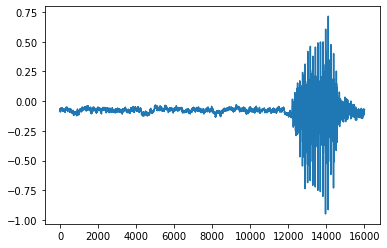

In [ ]:
print("Waveform Shaoe: {}".format(waveform.size()))
print("Waveform Sample Rate: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

In [ ]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

In [ ]:
waveform_first, *_ = train_set[0]
display(ipd.Audio(waveform_first.numpy(), rate=sample_rate))

waveform_second, *_ = train_set[1]
display(ipd.Audio(waveform_second.numpy(), rate=sample_rate))

In [ ]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

In [ ]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

display(ipd.Audio(transformed.numpy(), rate=new_sample_rate))


In [ ]:
def label_to_index(word):
    
    return torch.tensor(labels.index(word))


def index_to_label(index):
   
    return labels[index]


word_start = "wow"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

wow --> tensor(32) --> wow


In [ ]:
def pad_sequence(batch):
    
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    
   

    tensors, targets = [], []

    
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [ ]:
from torchvision import transforms

In [ ]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [ ]:
!pip install pyngrok --quiet

     |████████████████████████████████| 761 kB 5.0 MB/s 


In [ ]:
from pyngrok import ngrok
ngrok.kill()
NGROK_AUTH_TOKEN = ""
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

In [ ]:
import os
logs_base_dir = "runs"
os.makedirs(logs_base_dir, exist_ok=True)

In [ ]:
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [ ]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

   
        data = transform(data)
        output = model(data)


        loss = F.nll_loss(output.squeeze(), target)
        writer.add_scalar("Loss/train", loss, epoch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        pbar.update(pbar_update)

        losses.append(loss.item())

In [ ]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):

    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)


        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)


        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

In [ ]:
!tensorboard --logdir {} --host 0.0.0.0 --port 13000


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

TensorBoard 2.9.1 at http://0.0.0.0:13000/ (Press CTRL+C to quit)


In [ ]:
log_interval = 20
n_epoch = 100

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()
writer.flush()
writer.close()

  0%|          | 0.002188183807439825/100 [00:00<3:45:20, 135.21s/it]

Train Epoch: 1 [0/105829 (0%)]	Loss: 3.699587


  0%|          | 0.045951859956236345/100 [00:05<3:40:24, 132.30s/it]

Train Epoch: 1 [5120/105829 (5%)]	Loss: 2.943750


  0%|          | 0.08971553610503279/100 [00:11<3:44:57, 135.09s/it]

Train Epoch: 1 [10240/105829 (10%)]	Loss: 2.409783


  0%|          | 0.1334792122538292/100 [00:16<3:57:14, 142.53s/it] 

Train Epoch: 1 [15360/105829 (14%)]	Loss: 2.109631


  0%|          | 0.1772428884026256/100 [00:22<3:53:15, 140.21s/it] 

Train Epoch: 1 [20480/105829 (19%)]	Loss: 1.989242


  0%|          | 0.22100656455142198/100 [00:28<3:50:45, 138.76s/it]

Train Epoch: 1 [25600/105829 (24%)]	Loss: 1.994149


  0%|          | 0.26477024070021854/100 [00:34<3:51:25, 139.23s/it]

Train Epoch: 1 [30720/105829 (29%)]	Loss: 1.656324


  0%|          | 0.3085339168490155/100 [00:39<3:50:03, 138.46s/it] 

Train Epoch: 1 [35840/105829 (34%)]	Loss: 1.536751


  0%|          | 0.35229759299781244/100 [00:45<3:37:10, 130.76s/it]

Train Epoch: 1 [40960/105829 (39%)]	Loss: 1.795476


  0%|          | 0.39824945295404923/100 [00:50<3:01:10, 109.14s/it]

Train Epoch: 1 [46080/105829 (43%)]	Loss: 1.441321


  0%|          | 0.4420131291028462/100 [00:55<3:03:30, 110.60s/it] 

Train Epoch: 1 [51200/105829 (48%)]	Loss: 1.409931


  0%|          | 0.48577680525164313/100 [01:00<2:44:44, 99.32s/it]

Train Epoch: 1 [56320/105829 (53%)]	Loss: 1.515307


  1%|          | 0.5295404814004393/100 [01:05<2:46:47, 100.61s/it]

Train Epoch: 1 [61440/105829 (58%)]	Loss: 1.372196


  1%|          | 0.5711159737417953/100 [01:09<3:27:07, 124.99s/it]

Train Epoch: 1 [66560/105829 (63%)]	Loss: 1.320725


  1%|          | 0.617067833698031/100 [01:14<2:33:15, 92.52s/it]  

Train Epoch: 1 [71680/105829 (68%)]	Loss: 1.252536


  1%|          | 0.6608315098468268/100 [01:18<2:26:32, 88.51s/it]

Train Epoch: 1 [76800/105829 (72%)]	Loss: 1.056813


  1%|          | 0.7045951859956227/100 [01:22<2:26:20, 88.43s/it]

Train Epoch: 1 [81920/105829 (77%)]	Loss: 1.090475


  1%|          | 0.7483588621444185/100 [01:26<2:33:28, 92.78s/it] 

Train Epoch: 1 [87040/105829 (82%)]	Loss: 1.186893


  1%|          | 0.7921225382932143/100 [01:30<2:41:19, 97.56s/it] 

Train Epoch: 1 [92160/105829 (87%)]	Loss: 1.123861


  1%|          | 0.8358862144420102/100 [01:34<2:39:59, 96.80s/it] 

Train Epoch: 1 [97280/105829 (92%)]	Loss: 1.054984


  1%|          | 0.879649890590806/100 [01:39<2:41:46, 97.92s/it]  

Train Epoch: 1 [102400/105829 (97%)]	Loss: 1.058339


  1%|          | 1.0021881838074345/100 [01:44<46:33, 28.22s/it]


Test Epoch: 1	Accuracy: 7194/11005 (65%)

Train Epoch: 2 [0/105829 (0%)]	Loss: 1.122165


  1%|          | 1.0503282275711099/100 [01:45<57:37, 34.95s/it]  

Train Epoch: 2 [5120/105829 (5%)]	Loss: 1.104859


  1%|          | 1.0940919037199057/100 [01:47<57:44, 35.03s/it]  

Train Epoch: 2 [10240/105829 (10%)]	Loss: 0.827412


  1%|          | 1.1378555798687016/100 [01:49<57:35, 34.95s/it] 

Train Epoch: 2 [15360/105829 (14%)]	Loss: 0.971702


  1%|          | 1.1816192560174974/100 [01:50<57:30, 34.92s/it]  

Train Epoch: 2 [20480/105829 (19%)]	Loss: 0.948613


  1%|          | 1.2253829321662932/100 [01:52<57:34, 34.98s/it]

Train Epoch: 2 [25600/105829 (24%)]	Loss: 0.847882


  1%|▏         | 1.269146608315089/100 [01:53<57:46, 35.11s/it]   

Train Epoch: 2 [30720/105829 (29%)]	Loss: 1.089453


  1%|▏         | 1.312910284463885/100 [01:55<56:43, 34.49s/it] 

Train Epoch: 2 [35840/105829 (34%)]	Loss: 1.011790


  1%|▏         | 1.3566739606126808/100 [01:56<56:34, 34.41s/it]

Train Epoch: 2 [40960/105829 (39%)]	Loss: 0.935713


  1%|▏         | 1.4004376367614766/100 [01:58<57:05, 34.75s/it]

Train Epoch: 2 [46080/105829 (43%)]	Loss: 0.832149


  1%|▏         | 1.4442013129102724/100 [01:59<57:23, 34.94s/it]  

Train Epoch: 2 [51200/105829 (48%)]	Loss: 0.945469


  1%|▏         | 1.4879649890590683/100 [02:01<56:47, 34.59s/it]

Train Epoch: 2 [56320/105829 (53%)]	Loss: 0.853090


  2%|▏         | 1.531728665207864/100 [02:02<56:51, 34.64s/it] 

Train Epoch: 2 [61440/105829 (58%)]	Loss: 0.865110


  2%|▏         | 1.57549234135666/100 [02:04<56:33, 34.48s/it]  

Train Epoch: 2 [66560/105829 (63%)]	Loss: 0.751101


  2%|▏         | 1.6192560175054558/100 [02:06<57:04, 34.81s/it]

Train Epoch: 2 [71680/105829 (68%)]	Loss: 0.936971


  2%|▏         | 1.6630196936542516/100 [02:07<56:29, 34.47s/it]

Train Epoch: 2 [76800/105829 (72%)]	Loss: 0.740711


  2%|▏         | 1.7024070021881679/100 [02:08<59:57, 36.60s/it]

Train Epoch: 2 [81920/105829 (77%)]	Loss: 0.928178


  2%|▏         | 1.7505470459518433/100 [02:10<57:29, 35.11s/it]  

Train Epoch: 2 [87040/105829 (82%)]	Loss: 0.868659


  2%|▏         | 1.7943107221006391/100 [02:12<57:20, 35.03s/it]

Train Epoch: 2 [92160/105829 (87%)]	Loss: 0.854370


  2%|▏         | 1.838074398249435/100 [02:13<57:14, 34.99s/it] 

Train Epoch: 2 [97280/105829 (92%)]	Loss: 0.913705


  2%|▏         | 1.8818380743982308/100 [02:15<56:24, 34.49s/it]

Train Epoch: 2 [102400/105829 (97%)]	Loss: 0.996835


  2%|▏         | 2.004376367614859/100 [02:18<44:46, 27.42s/it] 


Test Epoch: 2	Accuracy: 8263/11005 (75%)

Train Epoch: 3 [0/105829 (0%)]	Loss: 0.648901


  2%|▏         | 2.048140043763655/100 [02:20<56:40, 34.72s/it] 

Train Epoch: 3 [5120/105829 (5%)]	Loss: 0.819169


  2%|▏         | 2.091903719912451/100 [02:21<56:22, 34.55s/it] 

Train Epoch: 3 [10240/105829 (10%)]	Loss: 0.760000


  2%|▏         | 2.1356673960612467/100 [02:23<58:45, 36.03s/it]

Train Epoch: 3 [15360/105829 (14%)]	Loss: 0.721385


  2%|▏         | 2.183807439824922/100 [02:24<55:49, 34.24s/it] 

Train Epoch: 3 [20480/105829 (19%)]	Loss: 0.684669


  2%|▏         | 2.2231947483588383/100 [02:26<56:06, 34.43s/it]

Train Epoch: 3 [25600/105829 (24%)]	Loss: 0.796480


  2%|▏         | 2.266958424507634/100 [02:27<56:48, 34.88s/it] 

Train Epoch: 3 [30720/105829 (29%)]	Loss: 0.723862


  2%|▏         | 2.31072210065643/100 [02:29<57:22, 35.24s/it]  

Train Epoch: 3 [35840/105829 (34%)]	Loss: 0.836865


  2%|▏         | 2.354485776805226/100 [02:30<56:41, 34.84s/it] 

Train Epoch: 3 [40960/105829 (39%)]	Loss: 0.840021


  2%|▏         | 2.3982494529540217/100 [02:32<56:30, 34.74s/it]

Train Epoch: 3 [46080/105829 (43%)]	Loss: 0.863146


  2%|▏         | 2.4420131291028175/100 [02:33<56:14, 34.59s/it]

Train Epoch: 3 [51200/105829 (48%)]	Loss: 0.648020


  2%|▏         | 2.4857768052516134/100 [02:35<56:45, 34.92s/it]

Train Epoch: 3 [56320/105829 (53%)]	Loss: 0.883928


  3%|▎         | 2.529540481400409/100 [02:36<56:09, 34.57s/it] 

Train Epoch: 3 [61440/105829 (58%)]	Loss: 0.697304


  3%|▎         | 2.573304157549205/100 [02:38<57:02, 35.13s/it] 

Train Epoch: 3 [66560/105829 (63%)]	Loss: 0.790516


  3%|▎         | 2.6214442013128805/100 [02:40<55:18, 34.08s/it]

Train Epoch: 3 [71680/105829 (68%)]	Loss: 0.712433


  3%|▎         | 2.6652078774616763/100 [02:41<56:08, 34.60s/it]

Train Epoch: 3 [76800/105829 (72%)]	Loss: 0.788808


  3%|▎         | 2.7045951859955926/100 [02:42<56:08, 34.62s/it]

Train Epoch: 3 [81920/105829 (77%)]	Loss: 0.667505


  3%|▎         | 2.752735229759268/100 [02:44<56:30, 34.86s/it] 

Train Epoch: 3 [87040/105829 (82%)]	Loss: 0.738016


  3%|▎         | 2.7921225382931842/100 [02:46<55:45, 34.42s/it]

Train Epoch: 3 [92160/105829 (87%)]	Loss: 0.576636


  3%|▎         | 2.8402625820568597/100 [02:47<56:20, 34.79s/it]

Train Epoch: 3 [97280/105829 (92%)]	Loss: 0.811258


  3%|▎         | 2.8840262582056555/100 [02:49<56:42, 35.03s/it]

Train Epoch: 3 [102400/105829 (97%)]	Loss: 0.725483


  3%|▎         | 3.0021881838074043/100 [02:52<43:20, 26.81s/it]


Test Epoch: 3	Accuracy: 8502/11005 (77%)

Train Epoch: 4 [0/105829 (0%)]	Loss: 0.661329


  3%|▎         | 3.0503282275710797/100 [02:53<55:47, 34.53s/it]

Train Epoch: 4 [5120/105829 (5%)]	Loss: 0.699594


  3%|▎         | 3.0940919037198755/100 [02:55<56:19, 34.88s/it]

Train Epoch: 4 [10240/105829 (10%)]	Loss: 0.662765


  3%|▎         | 3.1378555798686714/100 [02:57<55:44, 34.53s/it]

Train Epoch: 4 [15360/105829 (14%)]	Loss: 0.643472


  3%|▎         | 3.181619256017467/100 [02:58<56:07, 34.78s/it] 

Train Epoch: 4 [20480/105829 (19%)]	Loss: 0.658267


  3%|▎         | 3.225382932166263/100 [03:00<55:46, 34.58s/it] 

Train Epoch: 4 [25600/105829 (24%)]	Loss: 0.488403


  3%|▎         | 3.269146608315059/100 [03:01<56:27, 35.02s/it] 

Train Epoch: 4 [30720/105829 (29%)]	Loss: 0.790138


  3%|▎         | 3.3129102844638547/100 [03:03<54:41, 33.93s/it]

Train Epoch: 4 [35840/105829 (34%)]	Loss: 0.635242


  3%|▎         | 3.3566739606126506/100 [03:04<54:50, 34.05s/it]

Train Epoch: 4 [40960/105829 (39%)]	Loss: 0.660197


  3%|▎         | 3.4004376367614464/100 [03:06<55:40, 34.58s/it]

Train Epoch: 4 [46080/105829 (43%)]	Loss: 0.658321


  3%|▎         | 3.4442013129102422/100 [03:07<55:54, 34.74s/it]

Train Epoch: 4 [51200/105829 (48%)]	Loss: 0.649017


  3%|▎         | 3.487964989059038/100 [03:09<55:09, 34.29s/it] 

Train Epoch: 4 [56320/105829 (53%)]	Loss: 0.791337


  4%|▎         | 3.531728665207834/100 [03:10<54:37, 33.98s/it] 

Train Epoch: 4 [61440/105829 (58%)]	Loss: 0.541640


  4%|▎         | 3.5754923413566297/100 [03:12<54:49, 34.12s/it]

Train Epoch: 4 [66560/105829 (63%)]	Loss: 0.620503


  4%|▎         | 3.6192560175054256/100 [03:13<55:42, 34.68s/it]

Train Epoch: 4 [71680/105829 (68%)]	Loss: 0.586408


  4%|▎         | 3.6630196936542214/100 [03:15<55:41, 34.69s/it]

Train Epoch: 4 [76800/105829 (72%)]	Loss: 0.637538


  4%|▎         | 3.7067833698030173/100 [03:16<55:14, 34.42s/it]

Train Epoch: 4 [81920/105829 (77%)]	Loss: 0.814049


  4%|▍         | 3.750547045951813/100 [03:18<54:55, 34.24s/it] 

Train Epoch: 4 [87040/105829 (82%)]	Loss: 0.675981


  4%|▍         | 3.794310722100609/100 [03:19<56:44, 35.39s/it] 

Train Epoch: 4 [92160/105829 (87%)]	Loss: 0.683746


  4%|▍         | 3.8380743982494048/100 [03:21<55:59, 34.94s/it]

Train Epoch: 4 [97280/105829 (92%)]	Loss: 0.677450


  4%|▍         | 3.8818380743982006/100 [03:23<58:32, 36.55s/it]

Train Epoch: 4 [102400/105829 (97%)]	Loss: 0.766666


  4%|▍         | 4.002188183807389/100 [03:26<41:46, 26.11s/it]


Test Epoch: 4	Accuracy: 8504/11005 (77%)

Train Epoch: 5 [0/105829 (0%)]	Loss: 0.628296


  4%|▍         | 4.050328227571065/100 [03:27<55:28, 34.69s/it]

Train Epoch: 5 [5120/105829 (5%)]	Loss: 0.672469


  4%|▍         | 4.09409190371986/100 [03:29<54:33, 34.13s/it] 

Train Epoch: 5 [10240/105829 (10%)]	Loss: 0.725250


  4%|▍         | 4.137855579868656/100 [03:31<55:15, 34.59s/it]

Train Epoch: 5 [15360/105829 (14%)]	Loss: 0.817859


  4%|▍         | 4.181619256017452/100 [03:32<54:36, 34.20s/it] 

Train Epoch: 5 [20480/105829 (19%)]	Loss: 0.606377


  4%|▍         | 4.225382932166248/100 [03:34<56:12, 35.21s/it]

Train Epoch: 5 [25600/105829 (24%)]	Loss: 0.406327


  4%|▍         | 4.269146608315044/100 [03:35<54:24, 34.10s/it]

Train Epoch: 5 [30720/105829 (29%)]	Loss: 0.609910


  4%|▍         | 4.31291028446384/100 [03:37<55:28, 34.79s/it]

Train Epoch: 5 [35840/105829 (34%)]	Loss: 0.654476


  4%|▍         | 4.3566739606126355/100 [03:38<54:48, 34.39s/it]

Train Epoch: 5 [40960/105829 (39%)]	Loss: 0.674412


  4%|▍         | 4.400437636761431/100 [03:40<56:18, 35.34s/it]

Train Epoch: 5 [46080/105829 (43%)]	Loss: 0.714959


  4%|▍         | 4.444201312910227/100 [03:41<54:22, 34.14s/it] 

Train Epoch: 5 [51200/105829 (48%)]	Loss: 0.620925


  4%|▍         | 4.487964989059023/100 [03:43<55:45, 35.02s/it]

Train Epoch: 5 [56320/105829 (53%)]	Loss: 0.575113


  5%|▍         | 4.531728665207819/100 [03:44<54:40, 34.36s/it]

Train Epoch: 5 [61440/105829 (58%)]	Loss: 0.645368


  5%|▍         | 4.575492341356615/100 [03:46<54:45, 34.43s/it]

Train Epoch: 5 [66560/105829 (63%)]	Loss: 0.530068


  5%|▍         | 4.6192560175054105/100 [03:47<55:11, 34.72s/it]

Train Epoch: 5 [71680/105829 (68%)]	Loss: 0.668983


  5%|▍         | 4.663019693654206/100 [03:49<54:39, 34.39s/it]

Train Epoch: 5 [76800/105829 (72%)]	Loss: 0.656358


  5%|▍         | 4.706783369803002/100 [03:51<55:06, 34.70s/it]

Train Epoch: 5 [81920/105829 (77%)]	Loss: 0.641648


  5%|▍         | 4.750547045951798/100 [03:52<54:09, 34.12s/it]

Train Epoch: 5 [87040/105829 (82%)]	Loss: 0.662560


  5%|▍         | 4.794310722100594/100 [03:54<54:41, 34.46s/it]

Train Epoch: 5 [92160/105829 (87%)]	Loss: 0.657802


  5%|▍         | 4.83807439824939/100 [03:55<55:33, 35.03s/it]

Train Epoch: 5 [97280/105829 (92%)]	Loss: 0.633110


  5%|▍         | 4.8818380743981855/100 [03:57<56:14, 35.47s/it]

Train Epoch: 5 [102400/105829 (97%)]	Loss: 0.720683


  5%|▌         | 5.002188183807374/100 [04:00<41:01, 25.91s/it]


Test Epoch: 5	Accuracy: 8979/11005 (82%)

Train Epoch: 6 [0/105829 (0%)]	Loss: 0.478072


  5%|▌         | 5.0503282275710495/100 [04:02<55:12, 34.89s/it]

Train Epoch: 6 [5120/105829 (5%)]	Loss: 0.565266


  5%|▌         | 5.094091903719845/100 [04:03<54:54, 34.72s/it]

Train Epoch: 6 [10240/105829 (10%)]	Loss: 0.594287


  5%|▌         | 5.137855579868641/100 [04:05<55:13, 34.93s/it]

Train Epoch: 6 [15360/105829 (14%)]	Loss: 0.589912


  5%|▌         | 5.181619256017437/100 [04:06<54:42, 34.61s/it]

Train Epoch: 6 [20480/105829 (19%)]	Loss: 0.690482


  5%|▌         | 5.225382932166233/100 [04:08<54:26, 34.47s/it]

Train Epoch: 6 [25600/105829 (24%)]	Loss: 0.647565


  5%|▌         | 5.269146608315029/100 [04:09<54:17, 34.38s/it]

Train Epoch: 6 [30720/105829 (29%)]	Loss: 0.665008


  5%|▌         | 5.3129102844638245/100 [04:11<54:21, 34.44s/it]

Train Epoch: 6 [35840/105829 (34%)]	Loss: 0.553983


  5%|▌         | 5.35667396061262/100 [04:12<54:12, 34.37s/it] 

Train Epoch: 6 [40960/105829 (39%)]	Loss: 0.619893


  5%|▌         | 5.400437636761416/100 [04:14<55:11, 35.01s/it]

Train Epoch: 6 [46080/105829 (43%)]	Loss: 0.631624


  5%|▌         | 5.444201312910212/100 [04:15<54:17, 34.45s/it] 

Train Epoch: 6 [51200/105829 (48%)]	Loss: 0.523359


  5%|▌         | 5.487964989059008/100 [04:17<54:27, 34.57s/it]

Train Epoch: 6 [56320/105829 (53%)]	Loss: 0.656068


  6%|▌         | 5.531728665207804/100 [04:18<55:27, 35.23s/it]

Train Epoch: 6 [61440/105829 (58%)]	Loss: 0.534658


  6%|▌         | 5.5754923413565995/100 [04:20<54:30, 34.64s/it]

Train Epoch: 6 [66560/105829 (63%)]	Loss: 0.590351


  6%|▌         | 5.619256017505395/100 [04:22<55:56, 35.57s/it]

Train Epoch: 6 [71680/105829 (68%)]	Loss: 0.553345


  6%|▌         | 5.663019693654191/100 [04:23<54:43, 34.80s/it]

Train Epoch: 6 [76800/105829 (72%)]	Loss: 0.692313


  6%|▌         | 5.706783369802987/100 [04:25<53:43, 34.19s/it] 

Train Epoch: 6 [81920/105829 (77%)]	Loss: 0.632484


  6%|▌         | 5.750547045951783/100 [04:26<55:41, 35.46s/it]

Train Epoch: 6 [87040/105829 (82%)]	Loss: 0.635983


  6%|▌         | 5.794310722100579/100 [04:28<55:28, 35.33s/it]

Train Epoch: 6 [92160/105829 (87%)]	Loss: 0.588513


  6%|▌         | 5.838074398249375/100 [04:29<54:08, 34.50s/it]

Train Epoch: 6 [97280/105829 (92%)]	Loss: 0.605236


  6%|▌         | 5.88183807439817/100 [04:31<1:06:35, 42.45s/it] 

Train Epoch: 6 [102400/105829 (97%)]	Loss: 0.589828


  6%|▌         | 6.002188183807359/100 [04:35<43:34, 27.82s/it]


Test Epoch: 6	Accuracy: 8536/11005 (78%)

Train Epoch: 7 [0/105829 (0%)]	Loss: 0.660936


  6%|▌         | 6.050328227571034/100 [04:37<54:51, 35.04s/it]

Train Epoch: 7 [5120/105829 (5%)]	Loss: 0.470414


  6%|▌         | 6.09409190371983/100 [04:38<54:10, 34.62s/it] 

Train Epoch: 7 [10240/105829 (10%)]	Loss: 0.604347


  6%|▌         | 6.137855579868626/100 [04:40<54:02, 34.55s/it] 

Train Epoch: 7 [15360/105829 (14%)]	Loss: 0.682929


  6%|▌         | 6.181619256017422/100 [04:41<54:14, 34.68s/it]

Train Epoch: 7 [20480/105829 (19%)]	Loss: 0.536331


  6%|▌         | 6.225382932166218/100 [04:43<56:44, 36.31s/it]

Train Epoch: 7 [25600/105829 (24%)]	Loss: 0.641349


  6%|▋         | 6.269146608315014/100 [04:44<53:45, 34.41s/it]

Train Epoch: 7 [30720/105829 (29%)]	Loss: 0.623281


  6%|▋         | 6.312910284463809/100 [04:46<54:00, 34.58s/it]

Train Epoch: 7 [35840/105829 (34%)]	Loss: 0.592913


  6%|▋         | 6.356673960612605/100 [04:47<53:49, 34.49s/it]

Train Epoch: 7 [40960/105829 (39%)]	Loss: 0.543288


  6%|▋         | 6.400437636761401/100 [04:49<53:57, 34.59s/it] 

Train Epoch: 7 [46080/105829 (43%)]	Loss: 0.614214


  6%|▋         | 6.444201312910197/100 [04:50<54:15, 34.79s/it]

Train Epoch: 7 [51200/105829 (48%)]	Loss: 0.567745


  6%|▋         | 6.487964989058993/100 [04:52<53:48, 34.53s/it]

Train Epoch: 7 [56320/105829 (53%)]	Loss: 0.593188


  7%|▋         | 6.531728665207789/100 [04:53<54:21, 34.89s/it]

Train Epoch: 7 [61440/105829 (58%)]	Loss: 0.674857


  7%|▋         | 6.5754923413565844/100 [04:55<54:00, 34.68s/it]

Train Epoch: 7 [66560/105829 (63%)]	Loss: 0.570028


  7%|▋         | 6.61925601750538/100 [04:57<54:20, 34.91s/it] 

Train Epoch: 7 [71680/105829 (68%)]	Loss: 0.738674


  7%|▋         | 6.663019693654176/100 [04:58<55:20, 35.57s/it] 

Train Epoch: 7 [76800/105829 (72%)]	Loss: 0.558138


  7%|▋         | 6.706783369802972/100 [05:00<53:40, 34.52s/it]

Train Epoch: 7 [81920/105829 (77%)]	Loss: 0.489647


  7%|▋         | 6.750547045951768/100 [05:01<53:31, 34.44s/it]

Train Epoch: 7 [87040/105829 (82%)]	Loss: 0.848302


  7%|▋         | 6.794310722100564/100 [05:03<54:36, 35.16s/it]

Train Epoch: 7 [92160/105829 (87%)]	Loss: 0.696183


  7%|▋         | 6.8380743982493595/100 [05:04<53:27, 34.43s/it]

Train Epoch: 7 [97280/105829 (92%)]	Loss: 0.697439


  7%|▋         | 6.881838074398155/100 [05:06<54:42, 35.25s/it]

Train Epoch: 7 [102400/105829 (97%)]	Loss: 0.644734


  7%|▋         | 7.004376367614784/100 [05:09<44:00, 28.40s/it]


Test Epoch: 7	Accuracy: 8933/11005 (81%)

Train Epoch: 8 [0/105829 (0%)]	Loss: 0.500723


  7%|▋         | 7.0481400437635795/100 [05:11<56:19, 36.36s/it]

Train Epoch: 8 [5120/105829 (5%)]	Loss: 0.665091


  7%|▋         | 7.091903719912375/100 [05:12<53:24, 34.49s/it]

Train Epoch: 8 [10240/105829 (10%)]	Loss: 0.486799


  7%|▋         | 7.135667396061171/100 [05:14<54:43, 35.36s/it]

Train Epoch: 8 [15360/105829 (14%)]	Loss: 0.629740


  7%|▋         | 7.179431072209967/100 [05:15<53:16, 34.43s/it]

Train Epoch: 8 [20480/105829 (19%)]	Loss: 0.601429


  7%|▋         | 7.223194748358763/100 [05:17<53:56, 34.88s/it]

Train Epoch: 8 [25600/105829 (24%)]	Loss: 0.639171


  7%|▋         | 7.266958424507559/100 [05:18<54:27, 35.23s/it]

Train Epoch: 8 [30720/105829 (29%)]	Loss: 0.676151


  7%|▋         | 7.3107221006563545/100 [05:20<53:43, 34.78s/it]

Train Epoch: 8 [35840/105829 (34%)]	Loss: 0.477741


  7%|▋         | 7.35448577680515/100 [05:21<54:36, 35.36s/it] 

Train Epoch: 8 [40960/105829 (39%)]	Loss: 0.646526


  7%|▋         | 7.398249452953946/100 [05:23<54:00, 34.99s/it]

Train Epoch: 8 [46080/105829 (43%)]	Loss: 0.673864


  7%|▋         | 7.442013129102742/100 [05:24<52:58, 34.34s/it] 

Train Epoch: 8 [51200/105829 (48%)]	Loss: 0.507598


  7%|▋         | 7.485776805251538/100 [05:26<53:36, 34.77s/it]

Train Epoch: 8 [56320/105829 (53%)]	Loss: 0.567629


  8%|▊         | 7.533916849015213/100 [05:28<52:28, 34.05s/it]

Train Epoch: 8 [61440/105829 (58%)]	Loss: 0.680551


  8%|▊         | 7.57330415754913/100 [05:29<54:47, 35.57s/it]

Train Epoch: 8 [66560/105829 (63%)]	Loss: 0.624107


  8%|▊         | 7.617067833697925/100 [05:31<52:55, 34.38s/it]

Train Epoch: 8 [71680/105829 (68%)]	Loss: 0.717803


  8%|▊         | 7.660831509846721/100 [05:32<53:33, 34.80s/it]

Train Epoch: 8 [76800/105829 (72%)]	Loss: 0.667659


  8%|▊         | 7.704595185995517/100 [05:34<54:33, 35.47s/it] 

Train Epoch: 8 [81920/105829 (77%)]	Loss: 0.662448


  8%|▊         | 7.748358862144313/100 [05:35<52:46, 34.33s/it]

Train Epoch: 8 [87040/105829 (82%)]	Loss: 0.544316


  8%|▊         | 7.792122538293109/100 [05:37<53:13, 34.63s/it]

Train Epoch: 8 [92160/105829 (87%)]	Loss: 0.629065


  8%|▊         | 7.835886214441905/100 [05:38<52:36, 34.24s/it]

Train Epoch: 8 [97280/105829 (92%)]	Loss: 0.540146


  8%|▊         | 7.88402625820558/100 [05:40<53:11, 34.64s/it]

Train Epoch: 8 [102400/105829 (97%)]	Loss: 0.422798


  8%|▊         | 7.999999999999889/100 [05:43<34:43, 22.65s/it]


Test Epoch: 8	Accuracy: 9065/11005 (82%)

Train Epoch: 9 [0/105829 (0%)]	Loss: 0.444074


  8%|▊         | 8.050328227571024/100 [05:45<53:43, 35.06s/it]

Train Epoch: 9 [5120/105829 (5%)]	Loss: 0.420741


  8%|▊         | 8.094091903719837/100 [05:46<52:26, 34.23s/it]

Train Epoch: 9 [10240/105829 (10%)]	Loss: 0.429254


  8%|▊         | 8.137855579868651/100 [05:48<54:24, 35.53s/it]

Train Epoch: 9 [15360/105829 (14%)]	Loss: 0.674374


  8%|▊         | 8.181619256017465/100 [05:49<53:12, 34.77s/it]

Train Epoch: 9 [20480/105829 (19%)]	Loss: 0.424153


  8%|▊         | 8.225382932166278/100 [05:51<52:24, 34.27s/it]

Train Epoch: 9 [25600/105829 (24%)]	Loss: 0.540850


  8%|▊         | 8.269146608315092/100 [05:52<51:53, 33.94s/it]

Train Epoch: 9 [30720/105829 (29%)]	Loss: 0.633171


  8%|▊         | 8.312910284463905/100 [05:54<52:31, 34.37s/it]

Train Epoch: 9 [35840/105829 (34%)]	Loss: 0.643067


  8%|▊         | 8.356673960612719/100 [05:55<52:58, 34.68s/it]

Train Epoch: 9 [40960/105829 (39%)]	Loss: 0.500789


  8%|▊         | 8.400437636761533/100 [05:57<53:10, 34.83s/it]

Train Epoch: 9 [46080/105829 (43%)]	Loss: 0.691142


  8%|▊         | 8.444201312910346/100 [05:58<52:17, 34.27s/it]

Train Epoch: 9 [51200/105829 (48%)]	Loss: 0.504229


  8%|▊         | 8.48796498905916/100 [06:00<52:55, 34.70s/it] 

Train Epoch: 9 [56320/105829 (53%)]	Loss: 0.485471


  9%|▊         | 8.531728665207973/100 [06:01<52:53, 34.69s/it]

Train Epoch: 9 [61440/105829 (58%)]	Loss: 0.513951


  9%|▊         | 8.575492341356787/100 [06:03<52:45, 34.63s/it]

Train Epoch: 9 [66560/105829 (63%)]	Loss: 0.488027


  9%|▊         | 8.6192560175056/100 [06:04<53:11, 34.92s/it] 

Train Epoch: 9 [71680/105829 (68%)]	Loss: 0.538648


  9%|▊         | 8.663019693654414/100 [06:06<52:52, 34.73s/it]

Train Epoch: 9 [76800/105829 (72%)]	Loss: 0.566431


  9%|▊         | 8.706783369803228/100 [06:08<52:41, 34.63s/it]

Train Epoch: 9 [81920/105829 (77%)]	Loss: 0.809613


  9%|▉         | 8.750547045952041/100 [06:09<52:43, 34.67s/it]

Train Epoch: 9 [87040/105829 (82%)]	Loss: 0.604072


  9%|▉         | 8.794310722100855/100 [06:11<52:06, 34.28s/it]

Train Epoch: 9 [92160/105829 (87%)]	Loss: 0.646626


  9%|▉         | 8.838074398249669/100 [06:12<52:52, 34.80s/it]

Train Epoch: 9 [97280/105829 (92%)]	Loss: 0.647836


  9%|▉         | 8.881838074398482/100 [06:14<52:36, 34.64s/it]

Train Epoch: 9 [102400/105829 (97%)]	Loss: 0.616487


  9%|▉         | 9.00218818380772/100 [06:17<39:21, 25.95s/it] 


Test Epoch: 9	Accuracy: 9280/11005 (84%)

Train Epoch: 10 [0/105829 (0%)]	Loss: 0.559423


  9%|▉         | 9.050328227571415/100 [06:19<54:36, 36.03s/it]

Train Epoch: 10 [5120/105829 (5%)]	Loss: 0.469371


  9%|▉         | 9.094091903720228/100 [06:20<58:43, 38.75s/it]  

Train Epoch: 10 [10240/105829 (10%)]	Loss: 0.540105


  9%|▉         | 9.137855579869042/100 [06:22<52:32, 34.69s/it]

Train Epoch: 10 [15360/105829 (14%)]	Loss: 0.547651


  9%|▉         | 9.181619256017855/100 [06:23<52:41, 34.81s/it]

Train Epoch: 10 [20480/105829 (19%)]	Loss: 0.357163


  9%|▉         | 9.225382932166669/100 [06:25<51:51, 34.27s/it]

Train Epoch: 10 [25600/105829 (24%)]	Loss: 0.436513


  9%|▉         | 9.269146608315483/100 [06:26<52:12, 34.53s/it]

Train Epoch: 10 [30720/105829 (29%)]	Loss: 0.609299


  9%|▉         | 9.312910284464296/100 [06:28<53:13, 35.21s/it]

Train Epoch: 10 [35840/105829 (34%)]	Loss: 0.458558


  9%|▉         | 9.35667396061311/100 [06:30<53:38, 35.51s/it] 

Train Epoch: 10 [40960/105829 (39%)]	Loss: 0.459175


  9%|▉         | 9.400437636761923/100 [06:31<52:33, 34.81s/it]

Train Epoch: 10 [46080/105829 (43%)]	Loss: 0.605088


  9%|▉         | 9.444201312910737/100 [06:33<52:43, 34.94s/it]

Train Epoch: 10 [51200/105829 (48%)]	Loss: 0.494883


  9%|▉         | 9.48796498905955/100 [06:34<52:32, 34.83s/it]

Train Epoch: 10 [56320/105829 (53%)]	Loss: 0.572793


 10%|▉         | 9.531728665208364/100 [06:36<54:00, 35.82s/it]

Train Epoch: 10 [61440/105829 (58%)]	Loss: 0.599397


 10%|▉         | 9.575492341357178/100 [06:37<54:35, 36.23s/it]

Train Epoch: 10 [66560/105829 (63%)]	Loss: 0.634629


 10%|▉         | 9.619256017505991/100 [06:39<53:09, 35.29s/it]

Train Epoch: 10 [71680/105829 (68%)]	Loss: 0.581042


 10%|▉         | 9.663019693654805/100 [06:40<52:40, 34.98s/it]

Train Epoch: 10 [76800/105829 (72%)]	Loss: 0.475528


 10%|▉         | 9.706783369803619/100 [06:42<51:47, 34.41s/it]

Train Epoch: 10 [81920/105829 (77%)]	Loss: 0.547685


 10%|▉         | 9.750547045952432/100 [06:44<52:54, 35.18s/it]

Train Epoch: 10 [87040/105829 (82%)]	Loss: 0.510202


 10%|▉         | 9.794310722101246/100 [06:45<51:36, 34.32s/it]

Train Epoch: 10 [92160/105829 (87%)]	Loss: 0.698432


 10%|▉         | 9.83807439825006/100 [06:47<53:36, 35.67s/it] 

Train Epoch: 10 [97280/105829 (92%)]	Loss: 0.686358


 10%|▉         | 9.881838074398873/100 [06:48<52:36, 35.02s/it]

Train Epoch: 10 [102400/105829 (97%)]	Loss: 0.607431


 10%|█         | 10.00218818380811/100 [06:51<39:46, 26.51s/it]


Test Epoch: 10	Accuracy: 8791/11005 (80%)

Train Epoch: 11 [0/105829 (0%)]	Loss: 0.453841


 10%|█         | 10.050328227571805/100 [06:53<51:28, 34.34s/it]

Train Epoch: 11 [5120/105829 (5%)]	Loss: 0.571979


 10%|█         | 10.094091903720619/100 [06:54<51:09, 34.14s/it]

Train Epoch: 11 [10240/105829 (10%)]	Loss: 0.623966


 10%|█         | 10.137855579869433/100 [06:56<51:21, 34.30s/it]

Train Epoch: 11 [15360/105829 (14%)]	Loss: 0.501708


 10%|█         | 10.181619256018246/100 [06:58<50:58, 34.06s/it]

Train Epoch: 11 [20480/105829 (19%)]	Loss: 0.650716


 10%|█         | 10.22538293216706/100 [06:59<51:37, 34.51s/it] 

Train Epoch: 11 [25600/105829 (24%)]	Loss: 0.556153


 10%|█         | 10.269146608315873/100 [07:01<53:03, 35.48s/it]

Train Epoch: 11 [30720/105829 (29%)]	Loss: 0.486293


 10%|█         | 10.312910284464687/100 [07:02<52:02, 34.82s/it]

Train Epoch: 11 [35840/105829 (34%)]	Loss: 0.438046


 10%|█         | 10.3566739606135/100 [07:04<52:51, 35.37s/it] 

Train Epoch: 11 [40960/105829 (39%)]	Loss: 0.666024


 10%|█         | 10.400437636762314/100 [07:05<51:01, 34.17s/it]

Train Epoch: 11 [46080/105829 (43%)]	Loss: 0.548766


 10%|█         | 10.444201312911128/100 [07:07<51:55, 34.79s/it]

Train Epoch: 11 [51200/105829 (48%)]	Loss: 0.535190


 10%|█         | 10.487964989059941/100 [07:08<52:11, 34.98s/it]

Train Epoch: 11 [56320/105829 (53%)]	Loss: 0.445731


 11%|█         | 10.531728665208755/100 [07:10<51:54, 34.81s/it]

Train Epoch: 11 [61440/105829 (58%)]	Loss: 0.446484


 11%|█         | 10.575492341357569/100 [07:11<51:26, 34.52s/it]

Train Epoch: 11 [66560/105829 (63%)]	Loss: 0.487931


 11%|█         | 10.619256017506382/100 [07:13<52:22, 35.16s/it]

Train Epoch: 11 [71680/105829 (68%)]	Loss: 0.437823


 11%|█         | 10.663019693655196/100 [07:14<50:54, 34.20s/it]

Train Epoch: 11 [76800/105829 (72%)]	Loss: 0.615776


 11%|█         | 10.70678336980401/100 [07:16<51:37, 34.69s/it] 

Train Epoch: 11 [81920/105829 (77%)]	Loss: 0.532796


 11%|█         | 10.750547045952823/100 [07:17<52:21, 35.20s/it]

Train Epoch: 11 [87040/105829 (82%)]	Loss: 0.542241


 11%|█         | 10.794310722101637/100 [07:19<52:08, 35.07s/it]

Train Epoch: 11 [92160/105829 (87%)]	Loss: 0.588058


 11%|█         | 10.83807439825045/100 [07:21<51:45, 34.83s/it] 

Train Epoch: 11 [97280/105829 (92%)]	Loss: 0.723865


 11%|█         | 10.881838074399264/100 [07:22<51:13, 34.48s/it]

Train Epoch: 11 [102400/105829 (97%)]	Loss: 0.473823


 11%|█         | 11.00000000000106/100 [07:25<33:36, 22.66s/it] 


Test Epoch: 11	Accuracy: 9166/11005 (83%)

Train Epoch: 12 [0/105829 (0%)]	Loss: 0.485684


 11%|█         | 11.050328227572196/100 [07:27<51:42, 34.87s/it]

Train Epoch: 12 [5120/105829 (5%)]	Loss: 0.500560


 11%|█         | 11.09409190372101/100 [07:28<51:16, 34.60s/it] 

Train Epoch: 12 [10240/105829 (10%)]	Loss: 0.472376


 11%|█         | 11.137855579869823/100 [07:30<50:40, 34.22s/it]

Train Epoch: 12 [15360/105829 (14%)]	Loss: 0.524926


 11%|█         | 11.181619256018637/100 [07:32<52:46, 35.65s/it]

Train Epoch: 12 [20480/105829 (19%)]	Loss: 0.575978


 11%|█         | 11.22538293216745/100 [07:33<51:44, 34.97s/it]

Train Epoch: 12 [25600/105829 (24%)]	Loss: 0.653855


 11%|█▏        | 11.269146608316264/100 [07:35<50:56, 34.44s/it]

Train Epoch: 12 [30720/105829 (29%)]	Loss: 0.477202


 11%|█▏        | 11.312910284465078/100 [07:36<51:12, 34.65s/it]

Train Epoch: 12 [35840/105829 (34%)]	Loss: 0.431247


 11%|█▏        | 11.356673960613891/100 [07:38<51:26, 34.82s/it]

Train Epoch: 12 [40960/105829 (39%)]	Loss: 0.509810


 11%|█▏        | 11.400437636762705/100 [07:39<51:30, 34.89s/it]

Train Epoch: 12 [46080/105829 (43%)]	Loss: 0.593564


 11%|█▏        | 11.444201312911519/100 [07:41<51:56, 35.20s/it]

Train Epoch: 12 [51200/105829 (48%)]	Loss: 0.605839


 11%|█▏        | 11.487964989060332/100 [07:42<50:56, 34.53s/it]

Train Epoch: 12 [56320/105829 (53%)]	Loss: 0.676090


 12%|█▏        | 11.531728665209146/100 [07:44<51:30, 34.94s/it]

Train Epoch: 12 [61440/105829 (58%)]	Loss: 0.599497


 12%|█▏        | 11.57549234135796/100 [07:45<53:58, 36.62s/it] 

Train Epoch: 12 [66560/105829 (63%)]	Loss: 0.624818


 12%|█▏        | 11.619256017506773/100 [07:47<50:38, 34.38s/it]

Train Epoch: 12 [71680/105829 (68%)]	Loss: 0.544089


 12%|█▏        | 11.663019693655587/100 [07:49<51:27, 34.95s/it]

Train Epoch: 12 [76800/105829 (72%)]	Loss: 0.457982


 12%|█▏        | 11.7067833698044/100 [07:50<51:30, 35.00s/it]  

Train Epoch: 12 [81920/105829 (77%)]	Loss: 0.619472


 12%|█▏        | 11.750547045953214/100 [07:52<50:50, 34.56s/it]

Train Epoch: 12 [87040/105829 (82%)]	Loss: 0.465695


 12%|█▏        | 11.794310722102027/100 [07:53<51:09, 34.79s/it]

Train Epoch: 12 [92160/105829 (87%)]	Loss: 0.655551


 12%|█▏        | 11.838074398250841/100 [07:55<51:19, 34.93s/it]

Train Epoch: 12 [97280/105829 (92%)]	Loss: 0.471467


 12%|█▏        | 11.881838074399655/100 [07:56<50:57, 34.70s/it]

Train Epoch: 12 [102400/105829 (97%)]	Loss: 0.554833


 12%|█▏        | 12.002188183808892/100 [07:59<39:40, 27.05s/it]


Test Epoch: 12	Accuracy: 9355/11005 (85%)

Train Epoch: 13 [0/105829 (0%)]	Loss: 0.449468


 12%|█▏        | 12.050328227572587/100 [08:01<52:22, 35.74s/it]

Train Epoch: 13 [5120/105829 (5%)]	Loss: 0.587380


 12%|█▏        | 12.0940919037214/100 [08:03<51:11, 34.94s/it] 

Train Epoch: 13 [10240/105829 (10%)]	Loss: 0.582440


 12%|█▏        | 12.137855579870214/100 [08:04<50:39, 34.59s/it]

Train Epoch: 13 [15360/105829 (14%)]	Loss: 0.522622


 12%|█▏        | 12.181619256019028/100 [08:06<50:34, 34.55s/it]

Train Epoch: 13 [20480/105829 (19%)]	Loss: 0.409825


 12%|█▏        | 12.225382932167841/100 [08:07<50:20, 34.41s/it]

Train Epoch: 13 [25600/105829 (24%)]	Loss: 0.603006


 12%|█▏        | 12.269146608316655/100 [08:09<51:21, 35.13s/it]

Train Epoch: 13 [30720/105829 (29%)]	Loss: 0.581959


 12%|█▏        | 12.312910284465469/100 [08:10<50:29, 34.55s/it]

Train Epoch: 13 [35840/105829 (34%)]	Loss: 0.523964


 12%|█▏        | 12.356673960614282/100 [08:12<50:52, 34.83s/it]

Train Epoch: 13 [40960/105829 (39%)]	Loss: 0.524159


 12%|█▏        | 12.400437636763096/100 [08:13<50:21, 34.49s/it]

Train Epoch: 13 [46080/105829 (43%)]	Loss: 0.543397


 12%|█▏        | 12.44420131291191/100 [08:15<51:09, 35.06s/it] 

Train Epoch: 13 [51200/105829 (48%)]	Loss: 0.480146


 12%|█▏        | 12.487964989060723/100 [08:16<49:30, 33.94s/it]

Train Epoch: 13 [56320/105829 (53%)]	Loss: 0.600572


 13%|█▎        | 12.531728665209537/100 [08:18<51:19, 35.21s/it]

Train Epoch: 13 [61440/105829 (58%)]	Loss: 0.564948


 13%|█▎        | 12.57549234135835/100 [08:20<51:53, 35.61s/it] 

Train Epoch: 13 [66560/105829 (63%)]	Loss: 0.490852


 13%|█▎        | 12.619256017507164/100 [08:21<50:38, 34.78s/it]

Train Epoch: 13 [71680/105829 (68%)]	Loss: 0.479258


 13%|█▎        | 12.663019693655977/100 [08:23<50:12, 34.49s/it]

Train Epoch: 13 [76800/105829 (72%)]	Loss: 0.446091


 13%|█▎        | 12.706783369804791/100 [08:24<50:18, 34.58s/it]

Train Epoch: 13 [81920/105829 (77%)]	Loss: 0.384791


 13%|█▎        | 12.750547045953605/100 [08:26<50:36, 34.80s/it]

Train Epoch: 13 [87040/105829 (82%)]	Loss: 0.495226


 13%|█▎        | 12.794310722102418/100 [08:27<50:06, 34.48s/it]

Train Epoch: 13 [92160/105829 (87%)]	Loss: 0.593818


 13%|█▎        | 12.838074398251232/100 [08:29<51:09, 35.21s/it]

Train Epoch: 13 [97280/105829 (92%)]	Loss: 0.676514


 13%|█▎        | 12.881838074400045/100 [08:30<50:05, 34.49s/it]

Train Epoch: 13 [102400/105829 (97%)]	Loss: 0.590463


 13%|█▎        | 13.002188183809283/100 [08:33<37:56, 26.17s/it]


Test Epoch: 13	Accuracy: 9119/11005 (83%)

Train Epoch: 14 [0/105829 (0%)]	Loss: 0.478317


 13%|█▎        | 13.050328227572978/100 [08:35<50:14, 34.67s/it]

Train Epoch: 14 [5120/105829 (5%)]	Loss: 0.497804


 13%|█▎        | 13.094091903721791/100 [08:37<49:25, 34.12s/it]

Train Epoch: 14 [10240/105829 (10%)]	Loss: 0.530510


 13%|█▎        | 13.137855579870605/100 [08:38<49:48, 34.40s/it]

Train Epoch: 14 [15360/105829 (14%)]	Loss: 0.554682


 13%|█▎        | 13.181619256019419/100 [08:40<50:13, 34.71s/it]

Train Epoch: 14 [20480/105829 (19%)]	Loss: 0.610565


 13%|█▎        | 13.225382932168232/100 [08:41<50:14, 34.74s/it]

Train Epoch: 14 [25600/105829 (24%)]	Loss: 0.499025


 13%|█▎        | 13.269146608317046/100 [08:43<50:44, 35.11s/it]

Train Epoch: 14 [30720/105829 (29%)]	Loss: 0.491369


 13%|█▎        | 13.31291028446586/100 [08:44<49:42, 34.40s/it] 

Train Epoch: 14 [35840/105829 (34%)]	Loss: 0.409433


 13%|█▎        | 13.356673960614673/100 [08:46<50:29, 34.96s/it]

Train Epoch: 14 [40960/105829 (39%)]	Loss: 0.552973


 13%|█▎        | 13.400437636763487/100 [08:47<49:26, 34.26s/it]

Train Epoch: 14 [46080/105829 (43%)]	Loss: 0.590052


 13%|█▎        | 13.4442013129123/100 [08:49<49:29, 34.31s/it]  

Train Epoch: 14 [51200/105829 (48%)]	Loss: 0.430863


 13%|█▎        | 13.487964989061114/100 [08:51<50:30, 35.03s/it]

Train Epoch: 14 [56320/105829 (53%)]	Loss: 0.418576


 14%|█▎        | 13.531728665209927/100 [08:52<49:37, 34.44s/it]

Train Epoch: 14 [61440/105829 (58%)]	Loss: 0.519693


 14%|█▎        | 13.575492341358741/100 [08:54<50:13, 34.87s/it]

Train Epoch: 14 [66560/105829 (63%)]	Loss: 0.498695


 14%|█▎        | 13.619256017507555/100 [08:55<52:00, 36.12s/it]

Train Epoch: 14 [71680/105829 (68%)]	Loss: 0.613459


 14%|█▎        | 13.663019693656368/100 [08:57<1:04:53, 45.10s/it]

Train Epoch: 14 [76800/105829 (72%)]	Loss: 0.490914


 14%|█▎        | 13.706783369805182/100 [08:59<55:50, 38.83s/it]

Train Epoch: 14 [81920/105829 (77%)]	Loss: 0.589597


 14%|█▍        | 13.750547045953995/100 [09:01<50:06, 34.86s/it]

Train Epoch: 14 [87040/105829 (82%)]	Loss: 0.744201


 14%|█▍        | 13.794310722102809/100 [09:02<50:00, 34.81s/it]

Train Epoch: 14 [92160/105829 (87%)]	Loss: 0.513518


 14%|█▍        | 13.838074398251623/100 [09:04<50:18, 35.03s/it]

Train Epoch: 14 [97280/105829 (92%)]	Loss: 0.459883


 14%|█▍        | 13.881838074400436/100 [09:05<50:29, 35.18s/it]

Train Epoch: 14 [102400/105829 (97%)]	Loss: 0.548721


 14%|█▍        | 14.004376367617114/100 [09:08<39:41, 27.69s/it]


Test Epoch: 14	Accuracy: 9253/11005 (84%)

Train Epoch: 15 [0/105829 (0%)]	Loss: 0.449315


 14%|█▍        | 14.048140043765928/100 [09:10<54:38, 38.14s/it]

Train Epoch: 15 [5120/105829 (5%)]	Loss: 0.604237


 14%|█▍        | 14.091903719914741/100 [09:12<49:59, 34.91s/it]

Train Epoch: 15 [10240/105829 (10%)]	Loss: 0.435245


 14%|█▍        | 14.135667396063555/100 [09:13<49:33, 34.63s/it]

Train Epoch: 15 [15360/105829 (14%)]	Loss: 0.363907


 14%|█▍        | 14.179431072212369/100 [09:15<49:11, 34.39s/it]

Train Epoch: 15 [20480/105829 (19%)]	Loss: 0.723704


 14%|█▍        | 14.223194748361182/100 [09:16<49:24, 34.57s/it]

Train Epoch: 15 [25600/105829 (24%)]	Loss: 0.471445


 14%|█▍        | 14.266958424509996/100 [09:18<50:04, 35.05s/it]

Train Epoch: 15 [30720/105829 (29%)]	Loss: 0.514108


 14%|█▍        | 14.31072210065881/100 [09:19<49:05, 34.38s/it] 

Train Epoch: 15 [35840/105829 (34%)]	Loss: 0.602132


 14%|█▍        | 14.354485776807623/100 [09:21<50:44, 35.55s/it]

Train Epoch: 15 [40960/105829 (39%)]	Loss: 0.559174


 14%|█▍        | 14.398249452956437/100 [09:22<49:49, 34.92s/it]

Train Epoch: 15 [46080/105829 (43%)]	Loss: 0.514029


 14%|█▍        | 14.446389496720132/100 [09:24<49:40, 34.84s/it]

Train Epoch: 15 [51200/105829 (48%)]	Loss: 0.526229


 14%|█▍        | 14.485776805254064/100 [09:25<49:06, 34.46s/it]

Train Epoch: 15 [56320/105829 (53%)]	Loss: 0.487273


 15%|█▍        | 14.533916849017759/100 [09:27<48:34, 34.10s/it]

Train Epoch: 15 [61440/105829 (58%)]	Loss: 0.422818


 15%|█▍        | 14.573304157551691/100 [09:28<49:15, 34.60s/it]

Train Epoch: 15 [66560/105829 (63%)]	Loss: 0.480459


 15%|█▍        | 14.621444201315386/100 [09:30<48:55, 34.38s/it]

Train Epoch: 15 [71680/105829 (68%)]	Loss: 0.584044


 15%|█▍        | 14.660831509849318/100 [09:32<49:33, 34.84s/it]

Train Epoch: 15 [76800/105829 (72%)]	Loss: 0.563447


 15%|█▍        | 14.704595185998132/100 [09:33<51:22, 36.14s/it]

Train Epoch: 15 [81920/105829 (77%)]	Loss: 0.480732


 15%|█▍        | 14.752735229761827/100 [09:35<48:28, 34.11s/it]

Train Epoch: 15 [87040/105829 (82%)]	Loss: 0.468041


 15%|█▍        | 14.79649890591064/100 [09:36<49:06, 34.58s/it] 

Train Epoch: 15 [92160/105829 (87%)]	Loss: 0.476065


 15%|█▍        | 14.840262582059454/100 [09:38<48:47, 34.38s/it]

Train Epoch: 15 [97280/105829 (92%)]	Loss: 0.564080


 15%|█▍        | 14.879649890593386/100 [09:39<48:42, 34.33s/it]

Train Epoch: 15 [102400/105829 (97%)]	Loss: 0.527363


 15%|█▌        | 15.004376367617505/100 [09:42<38:58, 27.52s/it]


Test Epoch: 15	Accuracy: 9326/11005 (85%)

Train Epoch: 16 [0/105829 (0%)]	Loss: 0.524744


 15%|█▌        | 15.048140043766319/100 [09:44<49:28, 34.94s/it]

Train Epoch: 16 [5120/105829 (5%)]	Loss: 0.496662


 15%|█▌        | 15.096280087530014/100 [09:46<48:51, 34.53s/it]

Train Epoch: 16 [10240/105829 (10%)]	Loss: 0.468124


 15%|█▌        | 15.135667396063946/100 [09:47<49:37, 35.09s/it]

Train Epoch: 16 [15360/105829 (14%)]	Loss: 0.441181


 15%|█▌        | 15.17943107221276/100 [09:49<50:03, 35.41s/it] 

Train Epoch: 16 [20480/105829 (19%)]	Loss: 0.477936


 15%|█▌        | 15.223194748361573/100 [09:50<48:56, 34.64s/it]

Train Epoch: 16 [25600/105829 (24%)]	Loss: 0.667290


 15%|█▌        | 15.266958424510387/100 [09:52<47:51, 33.88s/it]

Train Epoch: 16 [30720/105829 (29%)]	Loss: 0.532784


 15%|█▌        | 15.3107221006592/100 [09:53<48:44, 34.54s/it]  

Train Epoch: 16 [35840/105829 (34%)]	Loss: 0.480803


 15%|█▌        | 15.358862144422895/100 [09:55<48:08, 34.12s/it]

Train Epoch: 16 [40960/105829 (39%)]	Loss: 0.682015


 15%|█▌        | 15.398249452956827/100 [09:56<48:20, 34.28s/it]

Train Epoch: 16 [46080/105829 (43%)]	Loss: 0.519625


 15%|█▌        | 15.442013129105641/100 [09:58<48:42, 34.57s/it]

Train Epoch: 16 [51200/105829 (48%)]	Loss: 0.470645


 15%|█▌        | 15.485776805254455/100 [09:59<48:23, 34.35s/it]

Train Epoch: 16 [56320/105829 (53%)]	Loss: 0.502204


 16%|█▌        | 15.53391684901815/100 [10:01<48:33, 34.49s/it] 

Train Epoch: 16 [61440/105829 (58%)]	Loss: 0.655883


 16%|█▌        | 15.573304157552082/100 [10:02<48:11, 34.25s/it]

Train Epoch: 16 [66560/105829 (63%)]	Loss: 0.450737


 16%|█▌        | 15.617067833700895/100 [10:04<50:04, 35.61s/it]

Train Epoch: 16 [71680/105829 (68%)]	Loss: 0.633330


 16%|█▌        | 15.660831509849709/100 [10:05<48:03, 34.19s/it]

Train Epoch: 16 [76800/105829 (72%)]	Loss: 0.461937


 16%|█▌        | 15.708971553613404/100 [10:07<48:15, 34.35s/it]

Train Epoch: 16 [81920/105829 (77%)]	Loss: 0.473941


 16%|█▌        | 15.748358862147336/100 [10:08<47:55, 34.13s/it]

Train Epoch: 16 [87040/105829 (82%)]	Loss: 0.534233


 16%|█▌        | 15.79212253829615/100 [10:10<48:42, 34.70s/it] 

Train Epoch: 16 [92160/105829 (87%)]	Loss: 0.528051


 16%|█▌        | 15.835886214444963/100 [10:11<48:51, 34.83s/it]

Train Epoch: 16 [97280/105829 (92%)]	Loss: 0.509109


 16%|█▌        | 15.879649890593777/100 [10:13<51:05, 36.44s/it]

Train Epoch: 16 [102400/105829 (97%)]	Loss: 0.544996


 16%|█▌        | 16.002188183810453/100 [10:16<38:21, 27.39s/it]


Test Epoch: 16	Accuracy: 9160/11005 (83%)

Train Epoch: 17 [0/105829 (0%)]	Loss: 0.521113


 16%|█▌        | 16.05032822757415/100 [10:18<48:46, 34.86s/it] 

Train Epoch: 17 [5120/105829 (5%)]	Loss: 0.522110


 16%|█▌        | 16.094091903722962/100 [10:19<48:20, 34.57s/it]

Train Epoch: 17 [10240/105829 (10%)]	Loss: 0.544812


 16%|█▌        | 16.137855579871776/100 [10:21<48:45, 34.88s/it]

Train Epoch: 17 [15360/105829 (14%)]	Loss: 0.439975


 16%|█▌        | 16.18161925602059/100 [10:22<48:58, 35.05s/it] 

Train Epoch: 17 [20480/105829 (19%)]	Loss: 0.426130


 16%|█▌        | 16.225382932169403/100 [10:24<49:35, 35.52s/it]

Train Epoch: 17 [25600/105829 (24%)]	Loss: 0.519851


 16%|█▋        | 16.269146608318216/100 [10:25<48:24, 34.69s/it]

Train Epoch: 17 [30720/105829 (29%)]	Loss: 0.569253


 16%|█▋        | 16.31291028446703/100 [10:27<48:19, 34.65s/it]

Train Epoch: 17 [35840/105829 (34%)]	Loss: 0.547756


 16%|█▋        | 16.356673960615844/100 [10:28<47:37, 34.16s/it]

Train Epoch: 17 [40960/105829 (39%)]	Loss: 0.666795


 16%|█▋        | 16.400437636764657/100 [10:30<48:57, 35.14s/it]

Train Epoch: 17 [46080/105829 (43%)]	Loss: 0.598988


 16%|█▋        | 16.44420131291347/100 [10:32<48:25, 34.77s/it]

Train Epoch: 17 [51200/105829 (48%)]	Loss: 0.451597


 16%|█▋        | 16.487964989062284/100 [10:33<58:40, 42.16s/it]  

Train Epoch: 17 [56320/105829 (53%)]	Loss: 0.530876


 17%|█▋        | 16.531728665211098/100 [10:35<48:15, 34.69s/it]

Train Epoch: 17 [61440/105829 (58%)]	Loss: 0.662428


 17%|█▋        | 16.57549234135991/100 [10:36<48:01, 34.54s/it]

Train Epoch: 17 [66560/105829 (63%)]	Loss: 0.482377


 17%|█▋        | 16.619256017508725/100 [10:38<48:26, 34.86s/it]

Train Epoch: 17 [71680/105829 (68%)]	Loss: 0.576773


 17%|█▋        | 16.66301969365754/100 [10:39<48:25, 34.86s/it] 

Train Epoch: 17 [76800/105829 (72%)]	Loss: 0.438825


 17%|█▋        | 16.706783369806352/100 [10:41<48:30, 34.95s/it]

Train Epoch: 17 [81920/105829 (77%)]	Loss: 0.527247


 17%|█▋        | 16.750547045955166/100 [10:42<48:04, 34.64s/it]

Train Epoch: 17 [87040/105829 (82%)]	Loss: 0.500069


 17%|█▋        | 16.79431072210398/100 [10:44<49:30, 35.70s/it] 

Train Epoch: 17 [92160/105829 (87%)]	Loss: 0.575205


 17%|█▋        | 16.838074398252793/100 [10:45<48:59, 35.35s/it]

Train Epoch: 17 [97280/105829 (92%)]	Loss: 0.555202


 17%|█▋        | 16.881838074401607/100 [10:47<48:03, 34.69s/it]

Train Epoch: 17 [102400/105829 (97%)]	Loss: 0.436212


 17%|█▋        | 17.002188183810844/100 [10:50<37:19, 26.98s/it]


Test Epoch: 17	Accuracy: 9232/11005 (84%)

Train Epoch: 18 [0/105829 (0%)]	Loss: 0.352603


 17%|█▋        | 17.05032822757454/100 [10:52<48:23, 35.00s/it] 

Train Epoch: 18 [5120/105829 (5%)]	Loss: 0.531479


 17%|█▋        | 17.094091903723353/100 [10:53<47:48, 34.60s/it]

Train Epoch: 18 [10240/105829 (10%)]	Loss: 0.551786


 17%|█▋        | 17.137855579872166/100 [10:55<48:02, 34.79s/it]

Train Epoch: 18 [15360/105829 (14%)]	Loss: 0.523273


 17%|█▋        | 17.18161925602098/100 [10:56<48:00, 34.78s/it]

Train Epoch: 18 [20480/105829 (19%)]	Loss: 0.491320


 17%|█▋        | 17.225382932169794/100 [10:58<47:10, 34.20s/it]

Train Epoch: 18 [25600/105829 (24%)]	Loss: 0.569579


 17%|█▋        | 17.269146608318607/100 [10:59<47:10, 34.22s/it]

Train Epoch: 18 [30720/105829 (29%)]	Loss: 0.483998


 17%|█▋        | 17.31291028446742/100 [11:01<48:08, 34.94s/it]

Train Epoch: 18 [35840/105829 (34%)]	Loss: 0.496587


 17%|█▋        | 17.356673960616234/100 [11:03<47:17, 34.33s/it]

Train Epoch: 18 [40960/105829 (39%)]	Loss: 0.537421


 17%|█▋        | 17.400437636765048/100 [11:04<47:30, 34.51s/it]

Train Epoch: 18 [46080/105829 (43%)]	Loss: 0.442698


 17%|█▋        | 17.44420131291386/100 [11:06<48:02, 34.92s/it]

Train Epoch: 18 [51200/105829 (48%)]	Loss: 0.545901


 17%|█▋        | 17.487964989062675/100 [11:07<47:22, 34.45s/it]

Train Epoch: 18 [56320/105829 (53%)]	Loss: 0.440208


 18%|█▊        | 17.53172866521149/100 [11:09<48:11, 35.06s/it] 

Train Epoch: 18 [61440/105829 (58%)]	Loss: 0.546923


 18%|█▊        | 17.575492341360302/100 [11:10<47:38, 34.68s/it]

Train Epoch: 18 [66560/105829 (63%)]	Loss: 0.508162


 18%|█▊        | 17.619256017509116/100 [11:12<47:59, 34.95s/it]

Train Epoch: 18 [71680/105829 (68%)]	Loss: 0.488463


 18%|█▊        | 17.66301969365793/100 [11:13<47:54, 34.91s/it] 

Train Epoch: 18 [76800/105829 (72%)]	Loss: 0.465334


 18%|█▊        | 17.706783369806743/100 [11:15<47:09, 34.38s/it]

Train Epoch: 18 [81920/105829 (77%)]	Loss: 0.399148


 18%|█▊        | 17.750547045955557/100 [11:16<46:50, 34.17s/it]

Train Epoch: 18 [87040/105829 (82%)]	Loss: 0.468630


 18%|█▊        | 17.79431072210437/100 [11:18<47:40, 34.79s/it]

Train Epoch: 18 [92160/105829 (87%)]	Loss: 0.593604


 18%|█▊        | 17.838074398253184/100 [11:19<47:07, 34.41s/it]

Train Epoch: 18 [97280/105829 (92%)]	Loss: 0.539323


 18%|█▊        | 17.881838074401998/100 [11:21<47:36, 34.78s/it]

Train Epoch: 18 [102400/105829 (97%)]	Loss: 0.570276


 18%|█▊        | 18.004376367618676/100 [11:24<39:36, 28.98s/it]


Test Epoch: 18	Accuracy: 9060/11005 (82%)

Train Epoch: 19 [0/105829 (0%)]	Loss: 0.462960


 18%|█▊        | 18.04814004376749/100 [11:26<47:33, 34.83s/it] 

Train Epoch: 19 [5120/105829 (5%)]	Loss: 0.452897


 18%|█▊        | 18.096280087531184/100 [11:27<46:58, 34.42s/it]

Train Epoch: 19 [10240/105829 (10%)]	Loss: 0.415114


 18%|█▊        | 18.140043763679998/100 [11:29<46:40, 34.22s/it]

Train Epoch: 19 [15360/105829 (14%)]	Loss: 0.475257


 18%|█▊        | 18.17943107221393/100 [11:30<46:24, 34.04s/it]

Train Epoch: 19 [20480/105829 (19%)]	Loss: 0.553620


 18%|█▊        | 18.223194748362744/100 [11:32<47:03, 34.52s/it]

Train Epoch: 19 [25600/105829 (24%)]	Loss: 0.451484


 18%|█▊        | 18.27133479212644/100 [11:33<46:36, 34.21s/it] 

Train Epoch: 19 [30720/105829 (29%)]	Loss: 0.526064


 18%|█▊        | 18.31072210066037/100 [11:35<47:49, 35.13s/it]

Train Epoch: 19 [35840/105829 (34%)]	Loss: 0.500162


 18%|█▊        | 18.354485776809184/100 [11:36<48:01, 35.29s/it]

Train Epoch: 19 [40960/105829 (39%)]	Loss: 0.455207


 18%|█▊        | 18.398249452957998/100 [11:38<47:08, 34.66s/it]

Train Epoch: 19 [46080/105829 (43%)]	Loss: 0.525320


 18%|█▊        | 18.44201312910681/100 [11:39<47:56, 35.27s/it]

Train Epoch: 19 [51200/105829 (48%)]	Loss: 0.439214


 18%|█▊        | 18.485776805255625/100 [11:41<48:30, 35.70s/it]

Train Epoch: 19 [56320/105829 (53%)]	Loss: 0.542720


 19%|█▊        | 18.52954048140444/100 [11:42<46:48, 34.47s/it] 

Train Epoch: 19 [61440/105829 (58%)]	Loss: 0.398297


 19%|█▊        | 18.573304157553252/100 [11:44<47:11, 34.77s/it]

Train Epoch: 19 [66560/105829 (63%)]	Loss: 0.565218


 19%|█▊        | 18.617067833702066/100 [11:46<47:07, 34.74s/it]

Train Epoch: 19 [71680/105829 (68%)]	Loss: 0.537701


 19%|█▊        | 18.66083150985088/100 [11:47<47:22, 34.94s/it]

Train Epoch: 19 [76800/105829 (72%)]	Loss: 0.363414


 19%|█▊        | 18.704595185999693/100 [11:49<48:05, 35.50s/it]

Train Epoch: 19 [81920/105829 (77%)]	Loss: 0.400737


 19%|█▊        | 18.748358862148507/100 [11:50<46:31, 34.36s/it]

Train Epoch: 19 [87040/105829 (82%)]	Loss: 0.654096


 19%|█▉        | 18.79212253829732/100 [11:52<47:19, 34.97s/it]

Train Epoch: 19 [92160/105829 (87%)]	Loss: 0.451720


 19%|█▉        | 18.835886214446134/100 [11:53<47:39, 35.23s/it]

Train Epoch: 19 [97280/105829 (92%)]	Loss: 0.473492


 19%|█▉        | 18.879649890594948/100 [11:55<47:16, 34.96s/it]

Train Epoch: 19 [102400/105829 (97%)]	Loss: 0.471957


 19%|█▉        | 19.002188183811626/100 [11:58<38:15, 28.34s/it]


Test Epoch: 19	Accuracy: 9208/11005 (84%)

Train Epoch: 20 [0/105829 (0%)]	Loss: 0.459074


 19%|█▉        | 19.05032822757532/100 [12:00<47:39, 35.32s/it]

Train Epoch: 20 [5120/105829 (5%)]	Loss: 0.509039


 19%|█▉        | 19.094091903724134/100 [12:01<48:04, 35.65s/it]

Train Epoch: 20 [10240/105829 (10%)]	Loss: 0.453391


 19%|█▉        | 19.137855579872948/100 [12:03<46:11, 34.28s/it]

Train Epoch: 20 [15360/105829 (14%)]	Loss: 0.445193


 19%|█▉        | 19.18161925602176/100 [12:05<46:31, 34.54s/it]

Train Epoch: 20 [20480/105829 (19%)]	Loss: 0.528322


 19%|█▉        | 19.225382932170575/100 [12:06<47:24, 35.22s/it]

Train Epoch: 20 [25600/105829 (24%)]	Loss: 0.585849


 19%|█▉        | 19.26914660831939/100 [12:08<46:26, 34.51s/it] 

Train Epoch: 20 [30720/105829 (29%)]	Loss: 0.466049


 19%|█▉        | 19.312910284468202/100 [12:09<46:57, 34.92s/it]

Train Epoch: 20 [35840/105829 (34%)]	Loss: 0.575807


 19%|█▉        | 19.356673960617016/100 [12:11<45:54, 34.15s/it]

Train Epoch: 20 [40960/105829 (39%)]	Loss: 0.466139


 19%|█▉        | 19.40043763676583/100 [12:12<45:50, 34.12s/it] 

Train Epoch: 20 [46080/105829 (43%)]	Loss: 0.400461


 19%|█▉        | 19.444201312914643/100 [12:14<46:10, 34.39s/it]

Train Epoch: 20 [51200/105829 (48%)]	Loss: 0.313641


 19%|█▉        | 19.487964989063457/100 [12:15<46:32, 34.68s/it]

Train Epoch: 20 [56320/105829 (53%)]	Loss: 0.615556


 20%|█▉        | 19.53172866521227/100 [12:17<47:39, 35.54s/it]

Train Epoch: 20 [61440/105829 (58%)]	Loss: 0.473111


 20%|█▉        | 19.575492341361084/100 [12:18<47:02, 35.10s/it]

Train Epoch: 20 [66560/105829 (63%)]	Loss: 0.600366


 20%|█▉        | 19.619256017509898/100 [12:20<46:41, 34.85s/it]

Train Epoch: 20 [71680/105829 (68%)]	Loss: 0.340684


 20%|█▉        | 19.66301969365871/100 [12:21<47:00, 35.11s/it]

Train Epoch: 20 [76800/105829 (72%)]	Loss: 0.463954


 20%|█▉        | 19.706783369807525/100 [12:23<46:44, 34.92s/it]

Train Epoch: 20 [81920/105829 (77%)]	Loss: 0.450654


 20%|█▉        | 19.75054704595634/100 [12:24<46:55, 35.09s/it] 

Train Epoch: 20 [87040/105829 (82%)]	Loss: 0.505177


 20%|█▉        | 19.794310722105152/100 [12:26<46:15, 34.60s/it]

Train Epoch: 20 [92160/105829 (87%)]	Loss: 0.434862


 20%|█▉        | 19.838074398253966/100 [12:27<46:25, 34.75s/it]

Train Epoch: 20 [97280/105829 (92%)]	Loss: 0.611926


 20%|█▉        | 19.88183807440278/100 [12:29<46:01, 34.47s/it] 

Train Epoch: 20 [102400/105829 (97%)]	Loss: 0.413454


 20%|██        | 20.004376367619457/100 [12:32<37:09, 27.87s/it]


Test Epoch: 20	Accuracy: 9262/11005 (84%)

Train Epoch: 21 [0/105829 (0%)]	Loss: 0.406823


 20%|██        | 20.052516411383152/100 [12:34<46:03, 34.57s/it]

Train Epoch: 21 [5120/105829 (5%)]	Loss: 0.411809


 20%|██        | 20.091903719917084/100 [12:35<46:07, 34.63s/it]

Train Epoch: 21 [10240/105829 (10%)]	Loss: 0.336894


 20%|██        | 20.135667396065898/100 [12:37<46:28, 34.92s/it]

Train Epoch: 21 [15360/105829 (14%)]	Loss: 0.465029


 20%|██        | 20.17943107221471/100 [12:38<46:27, 34.92s/it]

Train Epoch: 21 [20480/105829 (19%)]	Loss: 0.449821


 20%|██        | 20.223194748363525/100 [12:40<45:39, 34.33s/it]

Train Epoch: 21 [25600/105829 (24%)]	Loss: 0.391853


 20%|██        | 20.26695842451234/100 [12:41<45:59, 34.61s/it] 

Train Epoch: 21 [30720/105829 (29%)]	Loss: 0.361458


 20%|██        | 20.310722100661152/100 [12:43<46:56, 35.35s/it]

Train Epoch: 21 [35840/105829 (34%)]	Loss: 0.435918


 20%|██        | 20.354485776809966/100 [12:44<46:12, 34.81s/it]

Train Epoch: 21 [40960/105829 (39%)]	Loss: 0.390052


 20%|██        | 20.40262582057366/100 [12:46<45:54, 34.60s/it]

Train Epoch: 21 [46080/105829 (43%)]	Loss: 0.294825


 20%|██        | 20.442013129107593/100 [12:48<45:58, 34.67s/it]

Train Epoch: 21 [51200/105829 (48%)]	Loss: 0.319766


 20%|██        | 20.49015317287129/100 [12:49<45:31, 34.36s/it] 

Train Epoch: 21 [56320/105829 (53%)]	Loss: 0.419128


 21%|██        | 20.52954048140522/100 [12:51<45:19, 34.22s/it]

Train Epoch: 21 [61440/105829 (58%)]	Loss: 0.431026


 21%|██        | 20.577680525168915/100 [12:52<45:21, 34.26s/it]

Train Epoch: 21 [66560/105829 (63%)]	Loss: 0.407693


 21%|██        | 20.617067833702848/100 [12:54<46:55, 35.47s/it]

Train Epoch: 21 [71680/105829 (68%)]	Loss: 0.343216


 21%|██        | 20.66083150985166/100 [12:55<45:13, 34.20s/it]

Train Epoch: 21 [76800/105829 (72%)]	Loss: 0.389033


 21%|██        | 20.704595186000475/100 [12:57<46:21, 35.08s/it]

Train Epoch: 21 [81920/105829 (77%)]	Loss: 0.368360


 21%|██        | 20.74835886214929/100 [12:58<45:47, 34.66s/it] 

Train Epoch: 21 [87040/105829 (82%)]	Loss: 0.327156


 21%|██        | 20.792122538298102/100 [13:00<45:02, 34.12s/it]

Train Epoch: 21 [92160/105829 (87%)]	Loss: 0.432053


 21%|██        | 20.835886214446916/100 [13:01<45:08, 34.22s/it]

Train Epoch: 21 [97280/105829 (92%)]	Loss: 0.386825


 21%|██        | 20.87964989059573/100 [13:03<45:56, 34.84s/it] 

Train Epoch: 21 [102400/105829 (97%)]	Loss: 0.373792


 21%|██        | 21.000000000004967/100 [13:06<29:56, 22.75s/it]


Test Epoch: 21	Accuracy: 9950/11005 (90%)

Train Epoch: 22 [0/105829 (0%)]	Loss: 0.270778


 21%|██        | 21.050328227576102/100 [13:08<45:24, 34.51s/it]

Train Epoch: 22 [5120/105829 (5%)]	Loss: 0.317365


 21%|██        | 21.094091903724916/100 [13:09<46:14, 35.16s/it]

Train Epoch: 22 [10240/105829 (10%)]	Loss: 0.318270


 21%|██        | 21.13785557987373/100 [13:11<45:25, 34.56s/it] 

Train Epoch: 22 [15360/105829 (14%)]	Loss: 0.239710


 21%|██        | 21.181619256022543/100 [13:12<45:32, 34.67s/it]

Train Epoch: 22 [20480/105829 (19%)]	Loss: 0.330375


 21%|██        | 21.225382932171357/100 [13:14<45:52, 34.94s/it]

Train Epoch: 22 [25600/105829 (24%)]	Loss: 0.323130


 21%|██▏       | 21.26914660832017/100 [13:15<46:37, 35.54s/it]

Train Epoch: 22 [30720/105829 (29%)]	Loss: 0.318010


 21%|██▏       | 21.312910284468984/100 [13:17<46:19, 35.33s/it]

Train Epoch: 22 [35840/105829 (34%)]	Loss: 0.323802


 21%|██▏       | 21.356673960617798/100 [13:19<1:00:01, 45.79s/it]

Train Epoch: 22 [40960/105829 (39%)]	Loss: 0.344051


 21%|██▏       | 21.40043763676661/100 [13:21<58:17, 44.50s/it]  

Train Epoch: 22 [46080/105829 (43%)]	Loss: 0.310902


 21%|██▏       | 21.444201312915425/100 [13:23<46:41, 35.67s/it]

Train Epoch: 22 [51200/105829 (48%)]	Loss: 0.405673


 21%|██▏       | 21.48796498906424/100 [13:24<46:11, 35.29s/it] 

Train Epoch: 22 [56320/105829 (53%)]	Loss: 0.423736


 22%|██▏       | 21.531728665213052/100 [13:26<45:17, 34.63s/it]

Train Epoch: 22 [61440/105829 (58%)]	Loss: 0.310214


 22%|██▏       | 21.575492341361866/100 [13:27<44:52, 34.33s/it]

Train Epoch: 22 [66560/105829 (63%)]	Loss: 0.347210


 22%|██▏       | 21.61925601751068/100 [13:29<45:24, 34.76s/it] 

Train Epoch: 22 [71680/105829 (68%)]	Loss: 0.378972


 22%|██▏       | 21.663019693659493/100 [13:30<45:10, 34.60s/it]

Train Epoch: 22 [76800/105829 (72%)]	Loss: 0.352495


 22%|██▏       | 21.706783369808306/100 [13:32<44:42, 34.27s/it]

Train Epoch: 22 [81920/105829 (77%)]	Loss: 0.341415


 22%|██▏       | 21.75054704595712/100 [13:33<44:34, 34.18s/it]

Train Epoch: 22 [87040/105829 (82%)]	Loss: 0.335569


 22%|██▏       | 21.794310722105934/100 [13:35<45:46, 35.12s/it]

Train Epoch: 22 [92160/105829 (87%)]	Loss: 0.297155


 22%|██▏       | 21.838074398254747/100 [13:36<45:32, 34.96s/it]

Train Epoch: 22 [97280/105829 (92%)]	Loss: 0.409568


 22%|██▏       | 21.88183807440356/100 [13:38<45:43, 35.12s/it]

Train Epoch: 22 [102400/105829 (97%)]	Loss: 0.363364


 22%|██▏       | 22.002188183812798/100 [13:41<38:07, 29.33s/it]


Test Epoch: 22	Accuracy: 10036/11005 (91%)

Train Epoch: 23 [0/105829 (0%)]	Loss: 0.294302


 22%|██▏       | 22.050328227576493/100 [13:43<46:19, 35.66s/it]

Train Epoch: 23 [5120/105829 (5%)]	Loss: 0.271637


 22%|██▏       | 22.094091903725307/100 [13:44<44:43, 34.44s/it]

Train Epoch: 23 [10240/105829 (10%)]	Loss: 0.319745


 22%|██▏       | 22.13785557987412/100 [13:46<45:00, 34.69s/it]

Train Epoch: 23 [15360/105829 (14%)]	Loss: 0.423278


 22%|██▏       | 22.181619256022934/100 [13:47<44:34, 34.37s/it]

Train Epoch: 23 [20480/105829 (19%)]	Loss: 0.336831


 22%|██▏       | 22.225382932171748/100 [13:49<44:51, 34.60s/it]

Train Epoch: 23 [25600/105829 (24%)]	Loss: 0.323019


 22%|██▏       | 22.26914660832056/100 [13:51<47:10, 36.41s/it]

Train Epoch: 23 [30720/105829 (29%)]	Loss: 0.368739


 22%|██▏       | 22.312910284469375/100 [13:52<45:18, 34.99s/it]

Train Epoch: 23 [35840/105829 (34%)]	Loss: 0.337373


 22%|██▏       | 22.35667396061819/100 [13:54<44:57, 34.74s/it] 

Train Epoch: 23 [40960/105829 (39%)]	Loss: 0.185249


 22%|██▏       | 22.400437636767002/100 [13:55<44:42, 34.57s/it]

Train Epoch: 23 [46080/105829 (43%)]	Loss: 0.365110


 22%|██▏       | 22.444201312915816/100 [13:57<44:04, 34.10s/it]

Train Epoch: 23 [51200/105829 (48%)]	Loss: 0.329402


 22%|██▏       | 22.48796498906463/100 [13:58<44:32, 34.48s/it] 

Train Epoch: 23 [56320/105829 (53%)]	Loss: 0.293289


 23%|██▎       | 22.531728665213443/100 [14:00<44:46, 34.67s/it]

Train Epoch: 23 [61440/105829 (58%)]	Loss: 0.293217


 23%|██▎       | 22.575492341362256/100 [14:01<44:32, 34.51s/it]

Train Epoch: 23 [66560/105829 (63%)]	Loss: 0.389949


 23%|██▎       | 22.61925601751107/100 [14:03<44:04, 34.18s/it]

Train Epoch: 23 [71680/105829 (68%)]	Loss: 0.347694


 23%|██▎       | 22.663019693659884/100 [14:04<44:36, 34.61s/it]

Train Epoch: 23 [76800/105829 (72%)]	Loss: 0.331985


 23%|██▎       | 22.706783369808697/100 [14:06<44:22, 34.44s/it]

Train Epoch: 23 [81920/105829 (77%)]	Loss: 0.262277


 23%|██▎       | 22.75054704595751/100 [14:07<44:35, 34.64s/it]

Train Epoch: 23 [87040/105829 (82%)]	Loss: 0.316787


 23%|██▎       | 22.794310722106324/100 [14:09<45:08, 35.08s/it]

Train Epoch: 23 [92160/105829 (87%)]	Loss: 0.296898


 23%|██▎       | 22.838074398255138/100 [14:10<47:51, 37.22s/it]

Train Epoch: 23 [97280/105829 (92%)]	Loss: 0.334420


 23%|██▎       | 22.88183807440395/100 [14:12<44:46, 34.84s/it]

Train Epoch: 23 [102400/105829 (97%)]	Loss: 0.378630


 23%|██▎       | 23.00437636762063/100 [14:15<37:17, 29.06s/it]


Test Epoch: 23	Accuracy: 10047/11005 (91%)

Train Epoch: 24 [0/105829 (0%)]	Loss: 0.322236


 23%|██▎       | 23.048140043769443/100 [14:17<44:26, 34.66s/it]

Train Epoch: 24 [5120/105829 (5%)]	Loss: 0.350800


 23%|██▎       | 23.091903719918257/100 [14:18<45:54, 35.82s/it]

Train Epoch: 24 [10240/105829 (10%)]	Loss: 0.381366


 23%|██▎       | 23.13566739606707/100 [14:20<44:13, 34.52s/it]

Train Epoch: 24 [15360/105829 (14%)]	Loss: 0.275711


 23%|██▎       | 23.179431072215884/100 [14:21<45:43, 35.71s/it]

Train Epoch: 24 [20480/105829 (19%)]	Loss: 0.227796


 23%|██▎       | 23.223194748364698/100 [14:23<43:50, 34.26s/it]

Train Epoch: 24 [25600/105829 (24%)]	Loss: 0.327362


 23%|██▎       | 23.271334792128393/100 [14:25<43:52, 34.31s/it]

Train Epoch: 24 [30720/105829 (29%)]	Loss: 0.416421


 23%|██▎       | 23.315098468277206/100 [14:26<43:36, 34.12s/it]

Train Epoch: 24 [35840/105829 (34%)]	Loss: 0.306954


 23%|██▎       | 23.35448577681114/100 [14:27<45:32, 35.65s/it] 

Train Epoch: 24 [40960/105829 (39%)]	Loss: 0.309100


 23%|██▎       | 23.402625820574833/100 [14:29<43:46, 34.28s/it]

Train Epoch: 24 [46080/105829 (43%)]	Loss: 0.343884


 23%|██▎       | 23.442013129108766/100 [14:31<44:23, 34.79s/it]

Train Epoch: 24 [51200/105829 (48%)]	Loss: 0.445856


 23%|██▎       | 23.48577680525758/100 [14:32<44:32, 34.93s/it] 

Train Epoch: 24 [56320/105829 (53%)]	Loss: 0.284621


 24%|██▎       | 23.529540481406393/100 [14:34<45:09, 35.43s/it]

Train Epoch: 24 [61440/105829 (58%)]	Loss: 0.397989


 24%|██▎       | 23.577680525170088/100 [14:35<43:59, 34.54s/it]

Train Epoch: 24 [66560/105829 (63%)]	Loss: 0.404742


 24%|██▎       | 23.61706783370402/100 [14:37<45:00, 35.35s/it]

Train Epoch: 24 [71680/105829 (68%)]	Loss: 0.378546


 24%|██▎       | 23.660831509852834/100 [14:38<44:49, 35.23s/it]

Train Epoch: 24 [76800/105829 (72%)]	Loss: 0.384366


 24%|██▎       | 23.704595186001647/100 [14:40<45:20, 35.65s/it]

Train Epoch: 24 [81920/105829 (77%)]	Loss: 0.359981


 24%|██▎       | 23.74835886215046/100 [14:41<45:27, 35.77s/it]

Train Epoch: 24 [87040/105829 (82%)]	Loss: 0.410797


 24%|██▍       | 23.792122538299274/100 [14:43<44:55, 35.37s/it]

Train Epoch: 24 [92160/105829 (87%)]	Loss: 0.258058


 24%|██▍       | 23.835886214448088/100 [14:44<43:30, 34.28s/it]

Train Epoch: 24 [97280/105829 (92%)]	Loss: 0.238937


 24%|██▍       | 23.8796498905969/100 [14:46<45:47, 36.09s/it] 

Train Epoch: 24 [102400/105829 (97%)]	Loss: 0.272532


 24%|██▍       | 24.00437636762102/100 [14:49<37:31, 29.63s/it]


Test Epoch: 24	Accuracy: 10068/11005 (91%)

Train Epoch: 25 [0/105829 (0%)]	Loss: 0.310898


 24%|██▍       | 24.048140043769834/100 [14:51<43:59, 34.75s/it]

Train Epoch: 25 [5120/105829 (5%)]	Loss: 0.239816


 24%|██▍       | 24.091903719918648/100 [14:52<43:31, 34.40s/it]

Train Epoch: 25 [10240/105829 (10%)]	Loss: 0.336613


 24%|██▍       | 24.13566739606746/100 [14:54<43:09, 34.13s/it]

Train Epoch: 25 [15360/105829 (14%)]	Loss: 0.481430


 24%|██▍       | 24.179431072216275/100 [14:55<43:19, 34.29s/it]

Train Epoch: 25 [20480/105829 (19%)]	Loss: 0.347455


 24%|██▍       | 24.22319474836509/100 [14:57<43:17, 34.28s/it] 

Train Epoch: 25 [25600/105829 (24%)]	Loss: 0.323945


 24%|██▍       | 24.271334792128783/100 [14:59<43:21, 34.35s/it]

Train Epoch: 25 [30720/105829 (29%)]	Loss: 0.313461


 24%|██▍       | 24.310722100662716/100 [15:00<43:33, 34.52s/it]

Train Epoch: 25 [35840/105829 (34%)]	Loss: 0.334617


 24%|██▍       | 24.35448577681153/100 [15:01<44:04, 34.96s/it] 

Train Epoch: 25 [40960/105829 (39%)]	Loss: 0.306344


 24%|██▍       | 24.398249452960343/100 [15:03<43:28, 34.50s/it]

Train Epoch: 25 [46080/105829 (43%)]	Loss: 0.267916


 24%|██▍       | 24.442013129109156/100 [15:05<43:39, 34.67s/it]

Train Epoch: 25 [51200/105829 (48%)]	Loss: 0.329484


 24%|██▍       | 24.48577680525797/100 [15:06<43:07, 34.26s/it]

Train Epoch: 25 [56320/105829 (53%)]	Loss: 0.334927


 25%|██▍       | 24.529540481406784/100 [15:08<43:23, 34.50s/it]

Train Epoch: 25 [61440/105829 (58%)]	Loss: 0.287100


 25%|██▍       | 24.573304157555597/100 [15:09<43:16, 34.42s/it]

Train Epoch: 25 [66560/105829 (63%)]	Loss: 0.429216


 25%|██▍       | 24.61706783370441/100 [15:11<43:12, 34.39s/it]

Train Epoch: 25 [71680/105829 (68%)]	Loss: 0.301831


 25%|██▍       | 24.665207877468106/100 [15:12<44:03, 35.09s/it]

Train Epoch: 25 [76800/105829 (72%)]	Loss: 0.256507


 25%|██▍       | 24.70897155361692/100 [15:14<43:06, 34.35s/it] 

Train Epoch: 25 [81920/105829 (77%)]	Loss: 0.340439


 25%|██▍       | 24.74835886215085/100 [15:15<43:51, 34.97s/it]

Train Epoch: 25 [87040/105829 (82%)]	Loss: 0.391616


 25%|██▍       | 24.792122538299665/100 [15:17<43:33, 34.75s/it]

Train Epoch: 25 [92160/105829 (87%)]	Loss: 0.250363


 25%|██▍       | 24.83588621444848/100 [15:18<43:30, 34.73s/it] 

Train Epoch: 25 [97280/105829 (92%)]	Loss: 0.371519


 25%|██▍       | 24.879649890597292/100 [15:20<43:49, 35.01s/it]

Train Epoch: 25 [102400/105829 (97%)]	Loss: 0.315535


 25%|██▌       | 25.00437636762141/100 [15:23<37:37, 30.11s/it]


Test Epoch: 25	Accuracy: 10104/11005 (92%)

Train Epoch: 26 [0/105829 (0%)]	Loss: 0.330216


 25%|██▌       | 25.052516411385106/100 [15:25<43:51, 35.11s/it]

Train Epoch: 26 [5120/105829 (5%)]	Loss: 0.226311


 25%|██▌       | 25.09190371991904/100 [15:26<43:14, 34.64s/it] 

Train Epoch: 26 [10240/105829 (10%)]	Loss: 0.252647


 25%|██▌       | 25.135667396067852/100 [15:28<43:44, 35.06s/it]

Train Epoch: 26 [15360/105829 (14%)]	Loss: 0.335442


 25%|██▌       | 25.179431072216666/100 [15:29<42:40, 34.22s/it]

Train Epoch: 26 [20480/105829 (19%)]	Loss: 0.291368


 25%|██▌       | 25.22319474836548/100 [15:31<43:19, 34.76s/it] 

Train Epoch: 26 [25600/105829 (24%)]	Loss: 0.289830


 25%|██▌       | 25.266958424514293/100 [15:32<42:52, 34.42s/it]

Train Epoch: 26 [30720/105829 (29%)]	Loss: 0.251292


 25%|██▌       | 25.310722100663106/100 [15:34<43:48, 35.19s/it]

Train Epoch: 26 [35840/105829 (34%)]	Loss: 0.340706


 25%|██▌       | 25.35448577681192/100 [15:35<42:59, 34.56s/it]

Train Epoch: 26 [40960/105829 (39%)]	Loss: 0.436003


 25%|██▌       | 25.398249452960734/100 [15:37<43:39, 35.12s/it]

Train Epoch: 26 [46080/105829 (43%)]	Loss: 0.258082


 25%|██▌       | 25.442013129109547/100 [15:38<43:03, 34.65s/it]

Train Epoch: 26 [51200/105829 (48%)]	Loss: 0.359585


 25%|██▌       | 25.48577680525836/100 [15:40<42:40, 34.36s/it]

Train Epoch: 26 [56320/105829 (53%)]	Loss: 0.324061


 26%|██▌       | 25.529540481407174/100 [15:41<43:09, 34.77s/it]

Train Epoch: 26 [61440/105829 (58%)]	Loss: 0.269500


 26%|██▌       | 25.573304157555988/100 [15:43<44:46, 36.09s/it]

Train Epoch: 26 [66560/105829 (63%)]	Loss: 0.372838


 26%|██▌       | 25.621444201319683/100 [15:45<42:48, 34.54s/it]

Train Epoch: 26 [71680/105829 (68%)]	Loss: 0.266749


 26%|██▌       | 25.665207877468497/100 [15:46<43:14, 34.91s/it]

Train Epoch: 26 [76800/105829 (72%)]	Loss: 0.383643


 26%|██▌       | 25.70459518600243/100 [15:48<43:00, 34.73s/it] 

Train Epoch: 26 [81920/105829 (77%)]	Loss: 0.299840


 26%|██▌       | 25.752735229766124/100 [15:49<42:41, 34.51s/it]

Train Epoch: 26 [87040/105829 (82%)]	Loss: 0.240233


 26%|██▌       | 25.796498905914937/100 [15:51<42:35, 34.43s/it]

Train Epoch: 26 [92160/105829 (87%)]	Loss: 0.281241


 26%|██▌       | 25.83588621444887/100 [15:52<43:15, 35.00s/it]

Train Epoch: 26 [97280/105829 (92%)]	Loss: 0.196924


 26%|██▌       | 25.879649890597683/100 [15:54<43:33, 35.27s/it]

Train Epoch: 26 [102400/105829 (97%)]	Loss: 0.367168


 26%|██▌       | 26.004376367621802/100 [15:57<36:42, 29.77s/it]


Test Epoch: 26	Accuracy: 10117/11005 (92%)

Train Epoch: 27 [0/105829 (0%)]	Loss: 0.286909


 26%|██▌       | 26.048140043770616/100 [15:59<43:48, 35.54s/it]

Train Epoch: 27 [5120/105829 (5%)]	Loss: 0.292815


 26%|██▌       | 26.09190371991943/100 [16:00<42:24, 34.42s/it] 

Train Epoch: 27 [10240/105829 (10%)]	Loss: 0.221521


 26%|██▌       | 26.135667396068243/100 [16:02<43:08, 35.05s/it]

Train Epoch: 27 [15360/105829 (14%)]	Loss: 0.269610


 26%|██▌       | 26.179431072217056/100 [16:03<42:52, 34.84s/it]

Train Epoch: 27 [20480/105829 (19%)]	Loss: 0.358428


 26%|██▌       | 26.22319474836587/100 [16:05<43:14, 35.17s/it]

Train Epoch: 27 [25600/105829 (24%)]	Loss: 0.282891


 26%|██▋       | 26.266958424514684/100 [16:06<42:18, 34.42s/it]

Train Epoch: 27 [30720/105829 (29%)]	Loss: 0.284006


 26%|██▋       | 26.310722100663497/100 [16:08<54:55, 44.72s/it]

Train Epoch: 27 [35840/105829 (34%)]	Loss: 0.255080


 26%|██▋       | 26.35448577681231/100 [16:09<43:19, 35.30s/it]

Train Epoch: 27 [40960/105829 (39%)]	Loss: 0.395829


 26%|██▋       | 26.402625820576006/100 [16:11<41:54, 34.17s/it]

Train Epoch: 27 [46080/105829 (43%)]	Loss: 0.265018


 26%|██▋       | 26.442013129109938/100 [16:12<41:50, 34.13s/it]

Train Epoch: 27 [51200/105829 (48%)]	Loss: 0.271991


 26%|██▋       | 26.48577680525875/100 [16:14<42:50, 34.96s/it]

Train Epoch: 27 [56320/105829 (53%)]	Loss: 0.390527


 27%|██▋       | 26.529540481407565/100 [16:16<42:19, 34.57s/it]

Train Epoch: 27 [61440/105829 (58%)]	Loss: 0.272938


 27%|██▋       | 26.57330415755638/100 [16:17<42:12, 34.49s/it] 

Train Epoch: 27 [66560/105829 (63%)]	Loss: 0.242682


 27%|██▋       | 26.617067833705192/100 [16:19<43:35, 35.64s/it]

Train Epoch: 27 [71680/105829 (68%)]	Loss: 0.241888


 27%|██▋       | 26.660831509854006/100 [16:20<42:17, 34.60s/it]

Train Epoch: 27 [76800/105829 (72%)]	Loss: 0.244136


 27%|██▋       | 26.70459518600282/100 [16:22<44:52, 36.74s/it]

Train Epoch: 27 [81920/105829 (77%)]	Loss: 0.290335


 27%|██▋       | 26.748358862151633/100 [16:23<43:30, 35.63s/it]

Train Epoch: 27 [87040/105829 (82%)]	Loss: 0.260386


 27%|██▋       | 26.792122538300447/100 [16:25<43:57, 36.03s/it]

Train Epoch: 27 [92160/105829 (87%)]	Loss: 0.263866


 27%|██▋       | 26.83588621444926/100 [16:26<42:14, 34.64s/it]

Train Epoch: 27 [97280/105829 (92%)]	Loss: 0.399693


 27%|██▋       | 26.879649890598074/100 [16:28<42:36, 34.96s/it]

Train Epoch: 27 [102400/105829 (97%)]	Loss: 0.332764


 27%|██▋       | 27.004376367622193/100 [16:31<36:29, 29.99s/it]


Test Epoch: 27	Accuracy: 10146/11005 (92%)

Train Epoch: 28 [0/105829 (0%)]	Loss: 0.295040


 27%|██▋       | 27.048140043771006/100 [16:33<44:09, 36.32s/it]

Train Epoch: 28 [5120/105829 (5%)]	Loss: 0.313520


 27%|██▋       | 27.0962800875347/100 [16:35<42:10, 34.72s/it] 

Train Epoch: 28 [10240/105829 (10%)]	Loss: 0.338704


 27%|██▋       | 27.135667396068634/100 [16:36<42:51, 35.29s/it]

Train Epoch: 28 [15360/105829 (14%)]	Loss: 0.274677


 27%|██▋       | 27.179431072217447/100 [16:37<42:39, 35.15s/it]

Train Epoch: 28 [20480/105829 (19%)]	Loss: 0.199684


 27%|██▋       | 27.22319474836626/100 [16:39<42:16, 34.86s/it]

Train Epoch: 28 [25600/105829 (24%)]	Loss: 0.253494


 27%|██▋       | 27.266958424515074/100 [16:41<42:38, 35.17s/it]

Train Epoch: 28 [30720/105829 (29%)]	Loss: 0.241390


 27%|██▋       | 27.310722100663888/100 [16:42<42:50, 35.37s/it]

Train Epoch: 28 [35840/105829 (34%)]	Loss: 0.279403


 27%|██▋       | 27.3544857768127/100 [16:44<43:10, 35.65s/it] 

Train Epoch: 28 [40960/105829 (39%)]	Loss: 0.210924


 27%|██▋       | 27.402625820576397/100 [16:45<42:48, 35.37s/it]

Train Epoch: 28 [46080/105829 (43%)]	Loss: 0.260966


 27%|██▋       | 27.44201312911033/100 [16:47<41:59, 34.73s/it] 

Train Epoch: 28 [51200/105829 (48%)]	Loss: 0.290591


 27%|██▋       | 27.485776805259142/100 [16:48<42:39, 35.29s/it]

Train Epoch: 28 [56320/105829 (53%)]	Loss: 0.274828


 28%|██▊       | 27.529540481407956/100 [16:50<42:22, 35.08s/it]

Train Epoch: 28 [61440/105829 (58%)]	Loss: 0.280495


 28%|██▊       | 27.57330415755677/100 [16:51<42:13, 34.99s/it]

Train Epoch: 28 [66560/105829 (63%)]	Loss: 0.262339


 28%|██▊       | 27.617067833705583/100 [16:53<42:34, 35.29s/it]

Train Epoch: 28 [71680/105829 (68%)]	Loss: 0.231765


 28%|██▊       | 27.660831509854397/100 [16:54<43:06, 35.76s/it]

Train Epoch: 28 [76800/105829 (72%)]	Loss: 0.354341


 28%|██▊       | 27.70459518600321/100 [16:56<43:01, 35.71s/it]

Train Epoch: 28 [81920/105829 (77%)]	Loss: 0.269351


 28%|██▊       | 27.748358862152024/100 [16:57<42:27, 35.26s/it]

Train Epoch: 28 [87040/105829 (82%)]	Loss: 0.242072


 28%|██▊       | 27.792122538300838/100 [16:59<42:44, 35.52s/it]

Train Epoch: 28 [92160/105829 (87%)]	Loss: 0.367029


 28%|██▊       | 27.83588621444965/100 [17:01<42:23, 35.24s/it]

Train Epoch: 28 [97280/105829 (92%)]	Loss: 0.230453


 28%|██▊       | 27.879649890598465/100 [17:02<41:56, 34.89s/it]

Train Epoch: 28 [102400/105829 (97%)]	Loss: 0.243620


 28%|██▊       | 28.002188183815143/100 [17:05<34:51, 29.04s/it]


Test Epoch: 28	Accuracy: 10176/11005 (92%)

Train Epoch: 29 [0/105829 (0%)]	Loss: 0.278048


 28%|██▊       | 28.050328227578838/100 [17:07<42:12, 35.20s/it]

Train Epoch: 29 [5120/105829 (5%)]	Loss: 0.277472


 28%|██▊       | 28.09409190372765/100 [17:09<41:38, 34.75s/it]

Train Epoch: 29 [10240/105829 (10%)]	Loss: 0.356540


 28%|██▊       | 28.137855579876465/100 [17:10<41:58, 35.05s/it]

Train Epoch: 29 [15360/105829 (14%)]	Loss: 0.360500


 28%|██▊       | 28.18161925602528/100 [17:12<42:02, 35.12s/it] 

Train Epoch: 29 [20480/105829 (19%)]	Loss: 0.216724


 28%|██▊       | 28.225382932174092/100 [17:13<41:20, 34.56s/it]

Train Epoch: 29 [25600/105829 (24%)]	Loss: 0.258826


 28%|██▊       | 28.269146608322906/100 [17:15<41:18, 34.55s/it]

Train Epoch: 29 [30720/105829 (29%)]	Loss: 0.260140


 28%|██▊       | 28.31291028447172/100 [17:16<41:26, 34.68s/it] 

Train Epoch: 29 [35840/105829 (34%)]	Loss: 0.263829


 28%|██▊       | 28.356673960620533/100 [17:18<41:56, 35.12s/it]

Train Epoch: 29 [40960/105829 (39%)]	Loss: 0.264292


 28%|██▊       | 28.400437636769347/100 [17:20<41:47, 35.03s/it]

Train Epoch: 29 [46080/105829 (43%)]	Loss: 0.324110


 28%|██▊       | 28.44420131291816/100 [17:21<41:44, 35.00s/it]

Train Epoch: 29 [51200/105829 (48%)]	Loss: 0.233991


 28%|██▊       | 28.487964989066974/100 [17:23<41:45, 35.04s/it]

Train Epoch: 29 [56320/105829 (53%)]	Loss: 0.367384


 29%|██▊       | 28.531728665215788/100 [17:24<41:59, 35.26s/it]

Train Epoch: 29 [61440/105829 (58%)]	Loss: 0.292759


 29%|██▊       | 28.5754923413646/100 [17:26<41:20, 34.74s/it] 

Train Epoch: 29 [66560/105829 (63%)]	Loss: 0.331635


 29%|██▊       | 28.619256017513415/100 [17:27<41:55, 35.24s/it]

Train Epoch: 29 [71680/105829 (68%)]	Loss: 0.302055


 29%|██▊       | 28.66301969366223/100 [17:29<41:56, 35.27s/it] 

Train Epoch: 29 [76800/105829 (72%)]	Loss: 0.213334


 29%|██▊       | 28.706783369811042/100 [17:30<41:37, 35.04s/it]

Train Epoch: 29 [81920/105829 (77%)]	Loss: 0.320083


 29%|██▉       | 28.750547045959856/100 [17:32<41:08, 34.65s/it]

Train Epoch: 29 [87040/105829 (82%)]	Loss: 0.317841


 29%|██▉       | 28.79431072210867/100 [17:34<42:22, 35.71s/it] 

Train Epoch: 29 [92160/105829 (87%)]	Loss: 0.307180


 29%|██▉       | 28.838074398257483/100 [17:35<41:21, 34.87s/it]

Train Epoch: 29 [97280/105829 (92%)]	Loss: 0.245347


 29%|██▉       | 28.881838074406296/100 [17:37<52:20, 44.17s/it]

Train Epoch: 29 [102400/105829 (97%)]	Loss: 0.321752


 29%|██▉       | 29.004376367622974/100 [17:41<34:48, 29.41s/it]


Test Epoch: 29	Accuracy: 10165/11005 (92%)

Train Epoch: 30 [0/105829 (0%)]	Loss: 0.245269


 29%|██▉       | 29.05251641138667/100 [17:43<40:41, 34.42s/it] 

Train Epoch: 30 [5120/105829 (5%)]	Loss: 0.251719


 29%|██▉       | 29.0919037199206/100 [17:44<41:38, 35.23s/it] 

Train Epoch: 30 [10240/105829 (10%)]	Loss: 0.332381


 29%|██▉       | 29.135667396069415/100 [17:46<41:36, 35.23s/it]

Train Epoch: 30 [15360/105829 (14%)]	Loss: 0.437265


 29%|██▉       | 29.18380743983311/100 [17:47<40:24, 34.24s/it]

Train Epoch: 30 [20480/105829 (19%)]	Loss: 0.258665


 29%|██▉       | 29.223194748367042/100 [17:49<41:11, 34.93s/it]

Train Epoch: 30 [25600/105829 (24%)]	Loss: 0.357765


 29%|██▉       | 29.271334792130737/100 [17:50<40:24, 34.28s/it]

Train Epoch: 30 [30720/105829 (29%)]	Loss: 0.258802


 29%|██▉       | 29.31072210066467/100 [17:52<41:16, 35.03s/it]

Train Epoch: 30 [35840/105829 (34%)]	Loss: 0.292309


 29%|██▉       | 29.354485776813483/100 [17:53<40:42, 34.57s/it]

Train Epoch: 30 [40960/105829 (39%)]	Loss: 0.311967


 29%|██▉       | 29.398249452962297/100 [17:55<40:26, 34.36s/it]

Train Epoch: 30 [46080/105829 (43%)]	Loss: 0.350439


 29%|██▉       | 29.44201312911111/100 [17:56<40:55, 34.80s/it]

Train Epoch: 30 [51200/105829 (48%)]	Loss: 0.298900


 29%|██▉       | 29.485776805259924/100 [17:58<40:55, 34.82s/it]

Train Epoch: 30 [56320/105829 (53%)]	Loss: 0.231656


 30%|██▉       | 29.529540481408738/100 [17:59<40:37, 34.59s/it]

Train Epoch: 30 [61440/105829 (58%)]	Loss: 0.338903


 30%|██▉       | 29.57330415755755/100 [18:01<40:46, 34.74s/it]

Train Epoch: 30 [66560/105829 (63%)]	Loss: 0.257905


 30%|██▉       | 29.617067833706365/100 [18:02<40:56, 34.90s/it]

Train Epoch: 30 [71680/105829 (68%)]	Loss: 0.336222


 30%|██▉       | 29.66083150985518/100 [18:04<40:49, 34.83s/it] 

Train Epoch: 30 [76800/105829 (72%)]	Loss: 0.276754


 30%|██▉       | 29.704595186003992/100 [18:05<40:46, 34.80s/it]

Train Epoch: 30 [81920/105829 (77%)]	Loss: 0.320012


 30%|██▉       | 29.748358862152806/100 [18:07<41:39, 35.58s/it]

Train Epoch: 30 [87040/105829 (82%)]	Loss: 0.269971


 30%|██▉       | 29.79212253830162/100 [18:08<41:34, 35.54s/it] 

Train Epoch: 30 [92160/105829 (87%)]	Loss: 0.338518


 30%|██▉       | 29.835886214450433/100 [18:10<41:39, 35.62s/it]

Train Epoch: 30 [97280/105829 (92%)]	Loss: 0.374498


 30%|██▉       | 29.879649890599246/100 [18:11<40:35, 34.74s/it]

Train Epoch: 30 [102400/105829 (97%)]	Loss: 0.234320


 30%|███       | 30.002188183815925/100 [18:15<34:47, 29.82s/it]


Test Epoch: 30	Accuracy: 10208/11005 (93%)

Train Epoch: 31 [0/105829 (0%)]	Loss: 0.313084


 30%|███       | 30.05032822757962/100 [18:17<41:14, 35.37s/it] 

Train Epoch: 31 [5120/105829 (5%)]	Loss: 0.234791


 30%|███       | 30.094091903728433/100 [18:18<40:33, 34.81s/it]

Train Epoch: 31 [10240/105829 (10%)]	Loss: 0.308215


 30%|███       | 30.137855579877247/100 [18:20<40:13, 34.54s/it]

Train Epoch: 31 [15360/105829 (14%)]	Loss: 0.342357


 30%|███       | 30.18161925602606/100 [18:21<40:30, 34.81s/it]

Train Epoch: 31 [20480/105829 (19%)]	Loss: 0.301990


 30%|███       | 30.225382932174874/100 [18:23<40:39, 34.96s/it]

Train Epoch: 31 [25600/105829 (24%)]	Loss: 0.225485


 30%|███       | 30.269146608323688/100 [18:24<40:01, 34.45s/it]

Train Epoch: 31 [30720/105829 (29%)]	Loss: 0.323600


 30%|███       | 30.3129102844725/100 [18:26<41:21, 35.60s/it] 

Train Epoch: 31 [35840/105829 (34%)]	Loss: 0.271708


 30%|███       | 30.356673960621315/100 [18:27<40:35, 34.97s/it]

Train Epoch: 31 [40960/105829 (39%)]	Loss: 0.284290


 30%|███       | 30.40043763677013/100 [18:29<40:01, 34.51s/it] 

Train Epoch: 31 [46080/105829 (43%)]	Loss: 0.281394


 30%|███       | 30.444201312918942/100 [18:30<40:00, 34.51s/it]

Train Epoch: 31 [51200/105829 (48%)]	Loss: 0.324263


 30%|███       | 30.487964989067756/100 [18:32<40:17, 34.78s/it]

Train Epoch: 31 [56320/105829 (53%)]	Loss: 0.368262


 31%|███       | 30.53172866521657/100 [18:33<41:03, 35.46s/it] 

Train Epoch: 31 [61440/105829 (58%)]	Loss: 0.288250


 31%|███       | 30.575492341365383/100 [18:35<41:19, 35.71s/it]

Train Epoch: 31 [66560/105829 (63%)]	Loss: 0.208014


 31%|███       | 30.619256017514196/100 [18:36<41:15, 35.69s/it]

Train Epoch: 31 [71680/105829 (68%)]	Loss: 0.304941


 31%|███       | 30.66301969366301/100 [18:38<40:51, 35.35s/it]

Train Epoch: 31 [76800/105829 (72%)]	Loss: 0.307736


 31%|███       | 30.706783369811824/100 [18:40<40:19, 34.92s/it]

Train Epoch: 31 [81920/105829 (77%)]	Loss: 0.264805


 31%|███       | 30.750547045960637/100 [18:41<40:59, 35.52s/it]

Train Epoch: 31 [87040/105829 (82%)]	Loss: 0.243675


 31%|███       | 30.79431072210945/100 [18:43<41:34, 36.04s/it]

Train Epoch: 31 [92160/105829 (87%)]	Loss: 0.360577


 31%|███       | 30.838074398258264/100 [18:44<40:13, 34.90s/it]

Train Epoch: 31 [97280/105829 (92%)]	Loss: 0.266525


 31%|███       | 30.881838074407078/100 [18:46<41:34, 36.10s/it]

Train Epoch: 31 [102400/105829 (97%)]	Loss: 0.278691


 31%|███       | 31.004376367623756/100 [18:49<34:55, 30.37s/it]


Test Epoch: 31	Accuracy: 10186/11005 (93%)

Train Epoch: 32 [0/105829 (0%)]	Loss: 0.278221


 31%|███       | 31.04814004377257/100 [18:51<42:39, 37.12s/it]

Train Epoch: 32 [5120/105829 (5%)]	Loss: 0.354093


 31%|███       | 31.096280087536265/100 [18:52<39:49, 34.69s/it]

Train Epoch: 32 [10240/105829 (10%)]	Loss: 0.267876


 31%|███       | 31.135667396070197/100 [18:54<40:39, 35.42s/it]

Train Epoch: 32 [15360/105829 (14%)]	Loss: 0.335973


 31%|███       | 31.17943107221901/100 [18:55<40:10, 35.02s/it]

Train Epoch: 32 [20480/105829 (19%)]	Loss: 0.347614


 31%|███       | 31.227571115982705/100 [18:57<42:01, 36.66s/it]

Train Epoch: 32 [25600/105829 (24%)]	Loss: 0.335218


 31%|███▏      | 31.266958424516638/100 [18:59<39:55, 34.85s/it]

Train Epoch: 32 [30720/105829 (29%)]	Loss: 0.199655


 31%|███▏      | 31.315098468280333/100 [19:00<39:35, 34.58s/it]

Train Epoch: 32 [35840/105829 (34%)]	Loss: 0.287938


 31%|███▏      | 31.354485776814265/100 [19:02<40:19, 35.24s/it]

Train Epoch: 32 [40960/105829 (39%)]	Loss: 0.342364


 31%|███▏      | 31.39824945296308/100 [19:03<39:37, 34.65s/it] 

Train Epoch: 32 [46080/105829 (43%)]	Loss: 0.228485


 31%|███▏      | 31.442013129111892/100 [19:05<39:39, 34.71s/it]

Train Epoch: 32 [51200/105829 (48%)]	Loss: 0.298376


 31%|███▏      | 31.490153172875587/100 [19:06<39:17, 34.40s/it]

Train Epoch: 32 [56320/105829 (53%)]	Loss: 0.233824


 32%|███▏      | 31.52954048140952/100 [19:08<39:39, 34.75s/it] 

Train Epoch: 32 [61440/105829 (58%)]	Loss: 0.371076


 32%|███▏      | 31.573304157558333/100 [19:09<39:55, 35.00s/it]

Train Epoch: 32 [66560/105829 (63%)]	Loss: 0.268628


 32%|███▏      | 31.617067833707146/100 [19:11<39:39, 34.80s/it]

Train Epoch: 32 [71680/105829 (68%)]	Loss: 0.366401


 32%|███▏      | 31.66520787747084/100 [19:12<39:17, 34.50s/it]

Train Epoch: 32 [76800/105829 (72%)]	Loss: 0.288674


 32%|███▏      | 31.704595186004774/100 [19:14<39:39, 34.84s/it]

Train Epoch: 32 [81920/105829 (77%)]	Loss: 0.317752


 32%|███▏      | 31.748358862153587/100 [19:15<39:13, 34.49s/it]

Train Epoch: 32 [87040/105829 (82%)]	Loss: 0.303133


 32%|███▏      | 31.7921225383024/100 [19:17<39:32, 34.78s/it] 

Train Epoch: 32 [92160/105829 (87%)]	Loss: 0.255861


 32%|███▏      | 31.835886214451214/100 [19:18<40:06, 35.30s/it]

Train Epoch: 32 [97280/105829 (92%)]	Loss: 0.292358


 32%|███▏      | 31.879649890600028/100 [19:20<39:52, 35.13s/it]

Train Epoch: 32 [102400/105829 (97%)]	Loss: 0.274315


 32%|███▏      | 32.00437636762415/100 [19:23<34:18, 30.28s/it] 


Test Epoch: 32	Accuracy: 10194/11005 (93%)

Train Epoch: 33 [0/105829 (0%)]	Loss: 0.281829


 32%|███▏      | 32.04814004377296/100 [19:25<39:46, 35.12s/it]

Train Epoch: 33 [5120/105829 (5%)]	Loss: 0.268510


 32%|███▏      | 32.096280087536655/100 [19:27<39:11, 34.62s/it]

Train Epoch: 33 [10240/105829 (10%)]	Loss: 0.202608


 32%|███▏      | 32.13566739607059/100 [19:28<40:17, 35.62s/it] 

Train Epoch: 33 [15360/105829 (14%)]	Loss: 0.226018


 32%|███▏      | 32.1794310722194/100 [19:30<39:41, 35.12s/it] 

Train Epoch: 33 [20480/105829 (19%)]	Loss: 0.386890


 32%|███▏      | 32.223194748368215/100 [19:31<39:29, 34.96s/it]

Train Epoch: 33 [25600/105829 (24%)]	Loss: 0.275492


 32%|███▏      | 32.26695842451703/100 [19:33<40:19, 35.72s/it]

Train Epoch: 33 [30720/105829 (29%)]	Loss: 0.253378


 32%|███▏      | 32.31072210066584/100 [19:34<39:48, 35.28s/it]

Train Epoch: 33 [35840/105829 (34%)]	Loss: 0.321259


 32%|███▏      | 32.354485776814656/100 [19:36<40:02, 35.51s/it]

Train Epoch: 33 [40960/105829 (39%)]	Loss: 0.266386


 32%|███▏      | 32.39824945296347/100 [19:37<38:53, 34.52s/it]

Train Epoch: 33 [46080/105829 (43%)]	Loss: 0.324368


 32%|███▏      | 32.44201312911228/100 [19:39<38:51, 34.52s/it]

Train Epoch: 33 [51200/105829 (48%)]	Loss: 0.282756


 32%|███▏      | 32.4857768052611/100 [19:40<38:41, 34.38s/it]  

Train Epoch: 33 [56320/105829 (53%)]	Loss: 0.322508


 33%|███▎      | 32.52954048140991/100 [19:42<39:37, 35.23s/it]

Train Epoch: 33 [61440/105829 (58%)]	Loss: 0.317808


 33%|███▎      | 32.573304157558724/100 [19:43<39:02, 34.75s/it]

Train Epoch: 33 [66560/105829 (63%)]	Loss: 0.316506


 33%|███▎      | 32.61706783370754/100 [19:45<40:29, 36.06s/it] 

Train Epoch: 33 [71680/105829 (68%)]	Loss: 0.361257


 33%|███▎      | 32.66083150985635/100 [19:47<40:00, 35.65s/it]

Train Epoch: 33 [76800/105829 (72%)]	Loss: 0.389487


 33%|███▎      | 32.704595186005164/100 [19:48<39:42, 35.41s/it]

Train Epoch: 33 [81920/105829 (77%)]	Loss: 0.289313


 33%|███▎      | 32.74835886215398/100 [19:50<39:18, 35.07s/it]

Train Epoch: 33 [87040/105829 (82%)]	Loss: 0.268518


 33%|███▎      | 32.79212253830279/100 [19:51<39:08, 34.94s/it]

Train Epoch: 33 [92160/105829 (87%)]	Loss: 0.341523


 33%|███▎      | 32.835886214451605/100 [19:53<39:34, 35.36s/it]

Train Epoch: 33 [97280/105829 (92%)]	Loss: 0.338567


 33%|███▎      | 32.87964989060042/100 [19:54<39:08, 34.99s/it]

Train Epoch: 33 [102400/105829 (97%)]	Loss: 0.397132


 33%|███▎      | 33.0021881838171/100 [19:58<33:52, 30.33s/it]  


Test Epoch: 33	Accuracy: 10218/11005 (93%)

Train Epoch: 34 [0/105829 (0%)]	Loss: 0.211983


 33%|███▎      | 33.05032822758079/100 [19:59<39:27, 35.36s/it]

Train Epoch: 34 [5120/105829 (5%)]	Loss: 0.208908


 33%|███▎      | 33.094091903729606/100 [20:01<39:09, 35.12s/it]

Train Epoch: 34 [10240/105829 (10%)]	Loss: 0.288611


 33%|███▎      | 33.13785557987842/100 [20:03<40:19, 36.19s/it]

Train Epoch: 34 [15360/105829 (14%)]	Loss: 0.240879


 33%|███▎      | 33.18161925602723/100 [20:04<39:41, 35.64s/it]

Train Epoch: 34 [20480/105829 (19%)]	Loss: 0.289937


 33%|███▎      | 33.225382932176046/100 [20:06<39:07, 35.15s/it]

Train Epoch: 34 [25600/105829 (24%)]	Loss: 0.286992


 33%|███▎      | 33.26914660832486/100 [20:07<38:59, 35.06s/it]

Train Epoch: 34 [30720/105829 (29%)]	Loss: 0.245753


 33%|███▎      | 33.31291028447367/100 [20:09<39:08, 35.21s/it]

Train Epoch: 34 [35840/105829 (34%)]	Loss: 0.334048


 33%|███▎      | 33.35667396062249/100 [20:10<39:43, 35.77s/it] 

Train Epoch: 34 [40960/105829 (39%)]	Loss: 0.296529


 33%|███▎      | 33.4004376367713/100 [20:12<39:05, 35.22s/it] 

Train Epoch: 34 [46080/105829 (43%)]	Loss: 0.289969


 33%|███▎      | 33.444201312920114/100 [20:13<39:48, 35.89s/it]

Train Epoch: 34 [51200/105829 (48%)]	Loss: 0.278941


 33%|███▎      | 33.48796498906893/100 [20:15<38:48, 35.01s/it]

Train Epoch: 34 [56320/105829 (53%)]	Loss: 0.256409


 34%|███▎      | 33.53172866521774/100 [20:16<39:19, 35.50s/it]

Train Epoch: 34 [61440/105829 (58%)]	Loss: 0.321255


 34%|███▎      | 33.575492341366555/100 [20:18<38:28, 34.76s/it]

Train Epoch: 34 [66560/105829 (63%)]	Loss: 0.320701


 34%|███▎      | 33.61925601751537/100 [20:20<38:40, 34.96s/it]

Train Epoch: 34 [71680/105829 (68%)]	Loss: 0.289553


 34%|███▎      | 33.66301969366418/100 [20:21<46:22, 41.95s/it]

Train Epoch: 34 [76800/105829 (72%)]	Loss: 0.334956


 34%|███▎      | 33.706783369812996/100 [20:23<39:58, 36.18s/it]

Train Epoch: 34 [81920/105829 (77%)]	Loss: 0.246570


 34%|███▍      | 33.75054704596181/100 [20:24<38:06, 34.51s/it]

Train Epoch: 34 [87040/105829 (82%)]	Loss: 0.287723


 34%|███▍      | 33.79431072211062/100 [20:26<38:16, 34.69s/it]

Train Epoch: 34 [92160/105829 (87%)]	Loss: 0.271333


 34%|███▍      | 33.83807439825944/100 [20:27<38:35, 34.99s/it] 

Train Epoch: 34 [97280/105829 (92%)]	Loss: 0.338056


 34%|███▍      | 33.88183807440825/100 [20:29<37:56, 34.43s/it]

Train Epoch: 34 [102400/105829 (97%)]	Loss: 0.302081


 34%|███▍      | 34.00437636762493/100 [20:32<32:40, 29.70s/it]


Test Epoch: 34	Accuracy: 10245/11005 (93%)

Train Epoch: 35 [0/105829 (0%)]	Loss: 0.241605


 34%|███▍      | 34.04814004377374/100 [20:34<39:05, 35.57s/it]

Train Epoch: 35 [5120/105829 (5%)]	Loss: 0.358919


 34%|███▍      | 34.091903719922556/100 [20:35<37:58, 34.58s/it]

Train Epoch: 35 [10240/105829 (10%)]	Loss: 0.214927


 34%|███▍      | 34.13566739607137/100 [20:37<38:45, 35.31s/it]

Train Epoch: 35 [15360/105829 (14%)]	Loss: 0.246184


 34%|███▍      | 34.17943107222018/100 [20:38<38:02, 34.67s/it]

Train Epoch: 35 [20480/105829 (19%)]	Loss: 0.264686


 34%|███▍      | 34.223194748368996/100 [20:40<38:05, 34.75s/it]

Train Epoch: 35 [25600/105829 (24%)]	Loss: 0.228853


 34%|███▍      | 34.26695842451781/100 [20:42<38:24, 35.06s/it]

Train Epoch: 35 [30720/105829 (29%)]	Loss: 0.246996


 34%|███▍      | 34.310722100666624/100 [20:43<39:04, 35.70s/it]

Train Epoch: 35 [35840/105829 (34%)]	Loss: 0.220172


 34%|███▍      | 34.35448577681544/100 [20:45<38:49, 35.49s/it] 

Train Epoch: 35 [40960/105829 (39%)]	Loss: 0.252919


 34%|███▍      | 34.39824945296425/100 [20:46<38:53, 35.57s/it]

Train Epoch: 35 [46080/105829 (43%)]	Loss: 0.338367


 34%|███▍      | 34.442013129113064/100 [20:48<39:28, 36.13s/it]

Train Epoch: 35 [51200/105829 (48%)]	Loss: 0.284188


 34%|███▍      | 34.48577680526188/100 [20:49<37:30, 34.35s/it]

Train Epoch: 35 [56320/105829 (53%)]	Loss: 0.239437


 35%|███▍      | 34.52954048141069/100 [20:51<37:33, 34.42s/it]

Train Epoch: 35 [61440/105829 (58%)]	Loss: 0.315487


 35%|███▍      | 34.573304157559505/100 [20:52<38:05, 34.93s/it]

Train Epoch: 35 [66560/105829 (63%)]	Loss: 0.180078


 35%|███▍      | 34.61706783370832/100 [20:54<38:10, 35.03s/it]

Train Epoch: 35 [71680/105829 (68%)]	Loss: 0.284476


 35%|███▍      | 34.66083150985713/100 [20:55<37:58, 34.87s/it]

Train Epoch: 35 [76800/105829 (72%)]	Loss: 0.259796


 35%|███▍      | 34.704595186005946/100 [20:57<37:39, 34.61s/it]

Train Epoch: 35 [81920/105829 (77%)]	Loss: 0.356500


 35%|███▍      | 34.75273522976964/100 [20:59<37:30, 34.50s/it]

Train Epoch: 35 [87040/105829 (82%)]	Loss: 0.273973


 35%|███▍      | 34.79212253830357/100 [21:00<37:32, 34.54s/it]

Train Epoch: 35 [92160/105829 (87%)]	Loss: 0.223527


 35%|███▍      | 34.83588621445239/100 [21:01<38:24, 35.36s/it] 

Train Epoch: 35 [97280/105829 (92%)]	Loss: 0.321886


 35%|███▍      | 34.8796498906012/100 [21:03<37:26, 34.50s/it] 

Train Epoch: 35 [102400/105829 (97%)]	Loss: 0.262502


 35%|███▌      | 35.00437636762532/100 [21:06<32:06, 29.64s/it]


Test Epoch: 35	Accuracy: 10170/11005 (92%)

Train Epoch: 36 [0/105829 (0%)]	Loss: 0.293127


 35%|███▌      | 35.04814004377413/100 [21:08<38:04, 35.17s/it]

Train Epoch: 36 [5120/105829 (5%)]	Loss: 0.223151


 35%|███▌      | 35.091903719922946/100 [21:09<37:45, 34.91s/it]

Train Epoch: 36 [10240/105829 (10%)]	Loss: 0.263487


 35%|███▌      | 35.14004376368664/100 [21:11<37:05, 34.31s/it]

Train Epoch: 36 [15360/105829 (14%)]	Loss: 0.259762


 35%|███▌      | 35.179431072220574/100 [21:12<37:34, 34.78s/it]

Train Epoch: 36 [20480/105829 (19%)]	Loss: 0.212808


 35%|███▌      | 35.22319474836939/100 [21:14<37:48, 35.01s/it] 

Train Epoch: 36 [25600/105829 (24%)]	Loss: 0.359741


 35%|███▌      | 35.2669584245182/100 [21:16<38:19, 35.52s/it] 

Train Epoch: 36 [30720/105829 (29%)]	Loss: 0.246298


 35%|███▌      | 35.310722100667014/100 [21:17<37:38, 34.91s/it]

Train Epoch: 36 [35840/105829 (34%)]	Loss: 0.328106


 35%|███▌      | 35.35448577681583/100 [21:19<38:21, 35.60s/it]

Train Epoch: 36 [40960/105829 (39%)]	Loss: 0.220888


 35%|███▌      | 35.39824945296464/100 [21:20<37:24, 34.75s/it]

Train Epoch: 36 [46080/105829 (43%)]	Loss: 0.249297


 35%|███▌      | 35.442013129113455/100 [21:22<38:00, 35.32s/it]

Train Epoch: 36 [51200/105829 (48%)]	Loss: 0.319445


 35%|███▌      | 35.48577680526227/100 [21:23<37:21, 34.75s/it]

Train Epoch: 36 [56320/105829 (53%)]	Loss: 0.276280


 36%|███▌      | 35.52954048141108/100 [21:25<37:44, 35.12s/it]

Train Epoch: 36 [61440/105829 (58%)]	Loss: 0.245113


 36%|███▌      | 35.573304157559896/100 [21:26<38:01, 35.41s/it]

Train Epoch: 36 [66560/105829 (63%)]	Loss: 0.289436


 36%|███▌      | 35.61706783370871/100 [21:28<37:35, 35.03s/it]

Train Epoch: 36 [71680/105829 (68%)]	Loss: 0.352552


 36%|███▌      | 35.66083150985752/100 [21:29<37:18, 34.79s/it]

Train Epoch: 36 [76800/105829 (72%)]	Loss: 0.372112


 36%|███▌      | 35.70459518600634/100 [21:31<37:44, 35.22s/it] 

Train Epoch: 36 [81920/105829 (77%)]	Loss: 0.270121


 36%|███▌      | 35.74835886215515/100 [21:32<36:52, 34.44s/it]

Train Epoch: 36 [87040/105829 (82%)]	Loss: 0.215518


 36%|███▌      | 35.792122538303964/100 [21:34<38:13, 35.72s/it]

Train Epoch: 36 [92160/105829 (87%)]	Loss: 0.298791


 36%|███▌      | 35.83588621445278/100 [21:35<37:04, 34.67s/it] 

Train Epoch: 36 [97280/105829 (92%)]	Loss: 0.333507


 36%|███▌      | 35.87964989060159/100 [21:37<36:58, 34.60s/it]

Train Epoch: 36 [102400/105829 (97%)]	Loss: 0.194072


 36%|███▌      | 36.00218818381827/100 [21:40<31:29, 29.53s/it]


Test Epoch: 36	Accuracy: 10216/11005 (93%)

Train Epoch: 37 [0/105829 (0%)]	Loss: 0.298511


 36%|███▌      | 36.050328227581964/100 [21:42<37:48, 35.47s/it]

Train Epoch: 37 [5120/105829 (5%)]	Loss: 0.279232


 36%|███▌      | 36.09409190373078/100 [21:44<36:42, 34.46s/it]

Train Epoch: 37 [10240/105829 (10%)]	Loss: 0.313422


 36%|███▌      | 36.13785557987959/100 [21:45<38:34, 36.24s/it]

Train Epoch: 37 [15360/105829 (14%)]	Loss: 0.235727


 36%|███▌      | 36.181619256028405/100 [21:47<37:35, 35.35s/it]

Train Epoch: 37 [20480/105829 (19%)]	Loss: 0.236318


 36%|███▌      | 36.22538293217722/100 [21:48<39:01, 36.72s/it]

Train Epoch: 37 [25600/105829 (24%)]	Loss: 0.292073


 36%|███▋      | 36.26914660832603/100 [21:50<40:25, 38.07s/it]

Train Epoch: 37 [30720/105829 (29%)]	Loss: 0.260285


 36%|███▋      | 36.312910284474846/100 [21:52<48:29, 45.69s/it]

Train Epoch: 37 [35840/105829 (34%)]	Loss: 0.177042


 36%|███▋      | 36.35667396062366/100 [21:54<40:50, 38.50s/it]

Train Epoch: 37 [40960/105829 (39%)]	Loss: 0.295187


 36%|███▋      | 36.40043763677247/100 [21:56<37:51, 35.71s/it]

Train Epoch: 37 [46080/105829 (43%)]	Loss: 0.283085


 36%|███▋      | 36.44420131292129/100 [21:57<37:21, 35.27s/it] 

Train Epoch: 37 [51200/105829 (48%)]	Loss: 0.225577


 36%|███▋      | 36.4879649890701/100 [21:59<37:01, 34.98s/it] 

Train Epoch: 37 [56320/105829 (53%)]	Loss: 0.240773


 37%|███▋      | 36.531728665218914/100 [22:00<36:45, 34.76s/it]

Train Epoch: 37 [61440/105829 (58%)]	Loss: 0.198281


 37%|███▋      | 36.57549234136773/100 [22:02<36:39, 34.68s/it] 

Train Epoch: 37 [66560/105829 (63%)]	Loss: 0.257239


 37%|███▋      | 36.61925601751654/100 [22:03<36:58, 35.00s/it]

Train Epoch: 37 [71680/105829 (68%)]	Loss: 0.268887


 37%|███▋      | 36.663019693665355/100 [22:05<37:52, 35.88s/it]

Train Epoch: 37 [76800/105829 (72%)]	Loss: 0.305014


 37%|███▋      | 36.70678336981417/100 [22:06<36:56, 35.02s/it]

Train Epoch: 37 [81920/105829 (77%)]	Loss: 0.268162


 37%|███▋      | 36.75054704596298/100 [22:08<37:46, 35.84s/it]

Train Epoch: 37 [87040/105829 (82%)]	Loss: 0.365312


 37%|███▋      | 36.794310722111796/100 [22:09<37:05, 35.21s/it]

Train Epoch: 37 [92160/105829 (87%)]	Loss: 0.344572


 37%|███▋      | 36.83807439826061/100 [22:11<36:59, 35.15s/it]

Train Epoch: 37 [97280/105829 (92%)]	Loss: 0.251756


 37%|███▋      | 36.88183807440942/100 [22:13<36:39, 34.84s/it]

Train Epoch: 37 [102400/105829 (97%)]	Loss: 0.221721


 37%|███▋      | 37.00218818381866/100 [22:16<31:07, 29.65s/it]


Test Epoch: 37	Accuracy: 10262/11005 (93%)

Train Epoch: 38 [0/105829 (0%)]	Loss: 0.267891


 37%|███▋      | 37.050328227582355/100 [22:18<37:15, 35.52s/it]

Train Epoch: 38 [5120/105829 (5%)]	Loss: 0.337973


 37%|███▋      | 37.09409190373117/100 [22:19<37:31, 35.79s/it]

Train Epoch: 38 [10240/105829 (10%)]	Loss: 0.316419


 37%|███▋      | 37.13785557987998/100 [22:21<36:34, 34.91s/it]

Train Epoch: 38 [15360/105829 (14%)]	Loss: 0.258388


 37%|███▋      | 37.181619256028796/100 [22:22<37:22, 35.71s/it]

Train Epoch: 38 [20480/105829 (19%)]	Loss: 0.257050


 37%|███▋      | 37.22538293217761/100 [22:24<36:23, 34.78s/it]

Train Epoch: 38 [25600/105829 (24%)]	Loss: 0.327522


 37%|███▋      | 37.26914660832642/100 [22:25<35:55, 34.36s/it]

Train Epoch: 38 [30720/105829 (29%)]	Loss: 0.235937


 37%|███▋      | 37.31291028447524/100 [22:27<36:47, 35.21s/it] 

Train Epoch: 38 [35840/105829 (34%)]	Loss: 0.320483


 37%|███▋      | 37.35667396062405/100 [22:28<36:30, 34.96s/it]

Train Epoch: 38 [40960/105829 (39%)]	Loss: 0.319331


 37%|███▋      | 37.400437636772864/100 [22:30<36:05, 34.59s/it]

Train Epoch: 38 [46080/105829 (43%)]	Loss: 0.286443


 37%|███▋      | 37.44420131292168/100 [22:31<36:36, 35.11s/it] 

Train Epoch: 38 [51200/105829 (48%)]	Loss: 0.247276


 37%|███▋      | 37.48796498907049/100 [22:33<36:23, 34.94s/it]

Train Epoch: 38 [56320/105829 (53%)]	Loss: 0.265165


 38%|███▊      | 37.531728665219305/100 [22:34<35:57, 34.54s/it]

Train Epoch: 38 [61440/105829 (58%)]	Loss: 0.265551


 38%|███▊      | 37.57549234136812/100 [22:36<36:10, 34.77s/it]

Train Epoch: 38 [66560/105829 (63%)]	Loss: 0.289660


 38%|███▊      | 37.61925601751693/100 [22:37<36:36, 35.21s/it]

Train Epoch: 38 [71680/105829 (68%)]	Loss: 0.285099


 38%|███▊      | 37.663019693665746/100 [22:39<36:42, 35.33s/it]

Train Epoch: 38 [76800/105829 (72%)]	Loss: 0.248641


 38%|███▊      | 37.70678336981456/100 [22:41<35:58, 34.64s/it]

Train Epoch: 38 [81920/105829 (77%)]	Loss: 0.280754


 38%|███▊      | 37.75054704596337/100 [22:42<36:07, 34.82s/it]

Train Epoch: 38 [87040/105829 (82%)]	Loss: 0.277230


 38%|███▊      | 37.794310722112186/100 [22:44<36:30, 35.22s/it]

Train Epoch: 38 [92160/105829 (87%)]	Loss: 0.334077


 38%|███▊      | 37.838074398261/100 [22:45<36:05, 34.83s/it]  

Train Epoch: 38 [97280/105829 (92%)]	Loss: 0.273417


 38%|███▊      | 37.88183807440981/100 [22:47<36:16, 35.04s/it]

Train Epoch: 38 [102400/105829 (97%)]	Loss: 0.263857


 38%|███▊      | 38.00437636762649/100 [22:50<30:56, 29.95s/it]


Test Epoch: 38	Accuracy: 10261/11005 (93%)

Train Epoch: 39 [0/105829 (0%)]	Loss: 0.153337


 38%|███▊      | 38.048140043775305/100 [22:52<35:50, 34.72s/it]

Train Epoch: 39 [5120/105829 (5%)]	Loss: 0.312932


 38%|███▊      | 38.09190371992412/100 [22:53<35:08, 34.06s/it]

Train Epoch: 39 [10240/105829 (10%)]	Loss: 0.205892


 38%|███▊      | 38.13566739607293/100 [22:55<36:12, 35.11s/it]

Train Epoch: 39 [15360/105829 (14%)]	Loss: 0.297518


 38%|███▊      | 38.179431072221746/100 [22:56<36:25, 35.36s/it]

Train Epoch: 39 [20480/105829 (19%)]	Loss: 0.250839


 38%|███▊      | 38.22319474837056/100 [22:58<36:20, 35.30s/it]

Train Epoch: 39 [25600/105829 (24%)]	Loss: 0.353726


 38%|███▊      | 38.26695842451937/100 [22:59<35:45, 34.76s/it]

Train Epoch: 39 [30720/105829 (29%)]	Loss: 0.248858


 38%|███▊      | 38.31072210066819/100 [23:01<35:24, 34.43s/it] 

Train Epoch: 39 [35840/105829 (34%)]	Loss: 0.273071


 38%|███▊      | 38.354485776817/100 [23:02<35:36, 34.65s/it]  

Train Epoch: 39 [40960/105829 (39%)]	Loss: 0.220592


 38%|███▊      | 38.402625820580695/100 [23:04<35:28, 34.56s/it]

Train Epoch: 39 [46080/105829 (43%)]	Loss: 0.310924


 38%|███▊      | 38.44201312911463/100 [23:05<35:43, 34.83s/it] 

Train Epoch: 39 [51200/105829 (48%)]	Loss: 0.246958


 38%|███▊      | 38.48577680526344/100 [23:07<35:40, 34.79s/it]

Train Epoch: 39 [56320/105829 (53%)]	Loss: 0.318542


 39%|███▊      | 38.533916849027136/100 [23:09<35:26, 34.60s/it]

Train Epoch: 39 [61440/105829 (58%)]	Loss: 0.274688


 39%|███▊      | 38.57330415756107/100 [23:10<37:34, 36.70s/it]

Train Epoch: 39 [66560/105829 (63%)]	Loss: 0.252179


 39%|███▊      | 38.61706783370988/100 [23:12<36:10, 35.37s/it]

Train Epoch: 39 [71680/105829 (68%)]	Loss: 0.298050


 39%|███▊      | 38.660831509858696/100 [23:13<35:27, 34.69s/it]

Train Epoch: 39 [76800/105829 (72%)]	Loss: 0.306991


 39%|███▊      | 38.70459518600751/100 [23:15<35:39, 34.90s/it]

Train Epoch: 39 [81920/105829 (77%)]	Loss: 0.247728


 39%|███▊      | 38.74835886215632/100 [23:16<35:36, 34.88s/it]

Train Epoch: 39 [87040/105829 (82%)]	Loss: 0.267076


 39%|███▉      | 38.79212253830514/100 [23:18<35:25, 34.72s/it] 

Train Epoch: 39 [92160/105829 (87%)]	Loss: 0.208600


 39%|███▉      | 38.83588621445395/100 [23:19<36:04, 35.38s/it]

Train Epoch: 39 [97280/105829 (92%)]	Loss: 0.277179


 39%|███▉      | 38.879649890602764/100 [23:21<35:29, 34.84s/it]

Train Epoch: 39 [102400/105829 (97%)]	Loss: 0.417218


 39%|███▉      | 39.00218818381944/100 [23:24<29:56, 29.45s/it]


Test Epoch: 39	Accuracy: 10255/11005 (93%)

Train Epoch: 40 [0/105829 (0%)]	Loss: 0.310883


 39%|███▉      | 39.05032822758314/100 [23:26<36:13, 35.67s/it] 

Train Epoch: 40 [5120/105829 (5%)]	Loss: 0.234607


 39%|███▉      | 39.09409190373195/100 [23:28<35:47, 35.26s/it]

Train Epoch: 40 [10240/105829 (10%)]	Loss: 0.256811


 39%|███▉      | 39.137855579880764/100 [23:29<35:20, 34.84s/it]

Train Epoch: 40 [15360/105829 (14%)]	Loss: 0.292091


 39%|███▉      | 39.18161925602958/100 [23:31<35:12, 34.74s/it] 

Train Epoch: 40 [20480/105829 (19%)]	Loss: 0.233709


 39%|███▉      | 39.22538293217839/100 [23:32<35:08, 34.70s/it]

Train Epoch: 40 [25600/105829 (24%)]	Loss: 0.216873


 39%|███▉      | 39.269146608327205/100 [23:34<34:51, 34.44s/it]

Train Epoch: 40 [30720/105829 (29%)]	Loss: 0.266946


 39%|███▉      | 39.31291028447602/100 [23:35<35:06, 34.71s/it]

Train Epoch: 40 [35840/105829 (34%)]	Loss: 0.264438


 39%|███▉      | 39.35667396062483/100 [23:37<35:04, 34.70s/it]

Train Epoch: 40 [40960/105829 (39%)]	Loss: 0.292813


 39%|███▉      | 39.400437636773646/100 [23:38<35:11, 34.85s/it]

Train Epoch: 40 [46080/105829 (43%)]	Loss: 0.257631


 39%|███▉      | 39.44420131292246/100 [23:40<35:47, 35.46s/it]

Train Epoch: 40 [51200/105829 (48%)]	Loss: 0.231376


 39%|███▉      | 39.48796498907127/100 [23:41<34:36, 34.31s/it]

Train Epoch: 40 [56320/105829 (53%)]	Loss: 0.221361


 40%|███▉      | 39.531728665220086/100 [23:43<35:53, 35.61s/it]

Train Epoch: 40 [61440/105829 (58%)]	Loss: 0.354447


 40%|███▉      | 39.5754923413689/100 [23:44<35:06, 34.85s/it] 

Train Epoch: 40 [66560/105829 (63%)]	Loss: 0.267005


 40%|███▉      | 39.61925601751771/100 [23:46<35:50, 35.62s/it]

Train Epoch: 40 [71680/105829 (68%)]	Loss: 0.217779


 40%|███▉      | 39.66301969366653/100 [23:47<35:09, 34.96s/it] 

Train Epoch: 40 [76800/105829 (72%)]	Loss: 0.383028


 40%|███▉      | 39.70678336981534/100 [23:49<35:20, 35.17s/it]

Train Epoch: 40 [81920/105829 (77%)]	Loss: 0.190433


 40%|███▉      | 39.750547045964154/100 [23:50<35:08, 34.99s/it]

Train Epoch: 40 [87040/105829 (82%)]	Loss: 0.204250


 40%|███▉      | 39.79431072211297/100 [23:52<35:22, 35.26s/it]

Train Epoch: 40 [92160/105829 (87%)]	Loss: 0.281622


 40%|███▉      | 39.83807439826178/100 [23:54<35:46, 35.68s/it]

Train Epoch: 40 [97280/105829 (92%)]	Loss: 0.323553


 40%|███▉      | 39.881838074410595/100 [23:55<34:46, 34.70s/it]

Train Epoch: 40 [102400/105829 (97%)]	Loss: 0.239424


 40%|████      | 40.00218818381983/100 [23:58<29:32, 29.55s/it]


Test Epoch: 40	Accuracy: 10288/11005 (93%)

Train Epoch: 41 [0/105829 (0%)]	Loss: 0.261489


 40%|████      | 40.05032822758353/100 [24:00<35:29, 35.52s/it] 

Train Epoch: 41 [5120/105829 (5%)]	Loss: 0.284367


 40%|████      | 40.09409190373234/100 [24:02<35:07, 35.19s/it]

Train Epoch: 41 [10240/105829 (10%)]	Loss: 0.237551


 40%|████      | 40.137855579881155/100 [24:03<34:50, 34.92s/it]

Train Epoch: 41 [15360/105829 (14%)]	Loss: 0.237095


 40%|████      | 40.18161925602997/100 [24:05<34:49, 34.94s/it]

Train Epoch: 41 [20480/105829 (19%)]	Loss: 0.221892


 40%|████      | 40.22538293217878/100 [24:06<35:17, 35.42s/it]

Train Epoch: 41 [25600/105829 (24%)]	Loss: 0.192294


 40%|████      | 40.269146608327596/100 [24:08<34:32, 34.70s/it]

Train Epoch: 41 [30720/105829 (29%)]	Loss: 0.300534


 40%|████      | 40.31291028447641/100 [24:09<34:54, 35.09s/it]

Train Epoch: 41 [35840/105829 (34%)]	Loss: 0.233187


 40%|████      | 40.35667396062522/100 [24:11<34:27, 34.66s/it]

Train Epoch: 41 [40960/105829 (39%)]	Loss: 0.240109


 40%|████      | 40.400437636774036/100 [24:12<34:47, 35.03s/it]

Train Epoch: 41 [46080/105829 (43%)]	Loss: 0.277973


 40%|████      | 40.44420131292285/100 [24:14<34:27, 34.71s/it]

Train Epoch: 41 [51200/105829 (48%)]	Loss: 0.310149


 40%|████      | 40.48796498907166/100 [24:15<35:10, 35.46s/it]

Train Epoch: 41 [56320/105829 (53%)]	Loss: 0.208358


 41%|████      | 40.53172866522048/100 [24:17<34:55, 35.24s/it] 

Train Epoch: 41 [61440/105829 (58%)]	Loss: 0.181256


 41%|████      | 40.57549234136929/100 [24:19<35:40, 36.02s/it]

Train Epoch: 41 [66560/105829 (63%)]	Loss: 0.279205


 41%|████      | 40.619256017518104/100 [24:20<34:41, 35.05s/it]

Train Epoch: 41 [71680/105829 (68%)]	Loss: 0.282314


 41%|████      | 40.66301969366692/100 [24:22<35:41, 36.09s/it]

Train Epoch: 41 [76800/105829 (72%)]	Loss: 0.188700


 41%|████      | 40.70678336981573/100 [24:23<35:42, 36.13s/it]

Train Epoch: 41 [81920/105829 (77%)]	Loss: 0.251975


 41%|████      | 40.750547045964545/100 [24:25<34:10, 34.60s/it]

Train Epoch: 41 [87040/105829 (82%)]	Loss: 0.316895


 41%|████      | 40.79431072211336/100 [24:26<34:34, 35.04s/it]

Train Epoch: 41 [92160/105829 (87%)]	Loss: 0.277427


 41%|████      | 40.83807439826217/100 [24:28<35:16, 35.77s/it]

Train Epoch: 41 [97280/105829 (92%)]	Loss: 0.241165


 41%|████      | 40.881838074410986/100 [24:29<34:26, 34.95s/it]

Train Epoch: 41 [102400/105829 (97%)]	Loss: 0.287045


 41%|████      | 41.004376367627664/100 [24:33<29:15, 29.76s/it]


Test Epoch: 41	Accuracy: 10334/11005 (94%)

Train Epoch: 42 [0/105829 (0%)]	Loss: 0.224490


 41%|████      | 41.04814004377648/100 [24:34<37:31, 38.19s/it] 

Train Epoch: 42 [5120/105829 (5%)]	Loss: 0.255919


 41%|████      | 41.09190371992529/100 [24:36<34:28, 35.12s/it]

Train Epoch: 42 [10240/105829 (10%)]	Loss: 0.247336


 41%|████      | 41.135667396074105/100 [24:37<34:23, 35.06s/it]

Train Epoch: 42 [15360/105829 (14%)]	Loss: 0.228153


 41%|████      | 41.17943107222292/100 [24:39<34:34, 35.27s/it]

Train Epoch: 42 [20480/105829 (19%)]	Loss: 0.272317


 41%|████      | 41.22757111598661/100 [24:41<33:39, 34.37s/it]

Train Epoch: 42 [25600/105829 (24%)]	Loss: 0.204148


 41%|████▏     | 41.266958424520546/100 [24:42<34:36, 35.35s/it]

Train Epoch: 42 [30720/105829 (29%)]	Loss: 0.331596


 41%|████▏     | 41.31072210066936/100 [24:44<33:49, 34.57s/it]

Train Epoch: 42 [35840/105829 (34%)]	Loss: 0.284017


 41%|████▏     | 41.358862144433054/100 [24:45<33:42, 34.48s/it]

Train Epoch: 42 [40960/105829 (39%)]	Loss: 0.251034


 41%|████▏     | 41.398249452966986/100 [24:47<34:01, 34.84s/it]

Train Epoch: 42 [46080/105829 (43%)]	Loss: 0.191514


 41%|████▏     | 41.4420131291158/100 [24:48<34:08, 34.98s/it] 

Train Epoch: 42 [51200/105829 (48%)]	Loss: 0.206884


 41%|████▏     | 41.485776805264614/100 [24:50<33:26, 34.30s/it]

Train Epoch: 42 [56320/105829 (53%)]	Loss: 0.176539


 42%|████▏     | 41.52954048141343/100 [24:51<34:00, 34.89s/it] 

Train Epoch: 42 [61440/105829 (58%)]	Loss: 0.271172


 42%|████▏     | 41.57330415756224/100 [24:53<33:53, 34.80s/it]

Train Epoch: 42 [66560/105829 (63%)]	Loss: 0.297661


 42%|████▏     | 41.617067833711054/100 [24:54<34:56, 35.92s/it]

Train Epoch: 42 [71680/105829 (68%)]	Loss: 0.268932


 42%|████▏     | 41.66083150985987/100 [24:56<33:43, 34.68s/it]

Train Epoch: 42 [76800/105829 (72%)]	Loss: 0.266726


 42%|████▏     | 41.70459518600868/100 [24:57<34:22, 35.39s/it]

Train Epoch: 42 [81920/105829 (77%)]	Loss: 0.251930


 42%|████▏     | 41.748358862157495/100 [24:59<33:34, 34.58s/it]

Train Epoch: 42 [87040/105829 (82%)]	Loss: 0.282135


 42%|████▏     | 41.79212253830631/100 [25:01<33:56, 34.98s/it]

Train Epoch: 42 [92160/105829 (87%)]	Loss: 0.185031


 42%|████▏     | 41.83588621445512/100 [25:02<34:04, 35.15s/it]

Train Epoch: 42 [97280/105829 (92%)]	Loss: 0.223151


 42%|████▏     | 41.879649890603936/100 [25:04<34:00, 35.12s/it]

Train Epoch: 42 [102400/105829 (97%)]	Loss: 0.170745


 42%|████▏     | 42.002188183820614/100 [25:07<28:15, 29.24s/it]


Test Epoch: 42	Accuracy: 10345/11005 (94%)

Train Epoch: 43 [0/105829 (0%)]	Loss: 0.227765


 42%|████▏     | 42.05032822758431/100 [25:09<34:20, 35.56s/it]

Train Epoch: 43 [5120/105829 (5%)]	Loss: 0.182723


 42%|████▏     | 42.09409190373312/100 [25:10<33:57, 35.18s/it]

Train Epoch: 43 [10240/105829 (10%)]	Loss: 0.214354


 42%|████▏     | 42.137855579881936/100 [25:12<34:06, 35.37s/it]

Train Epoch: 43 [15360/105829 (14%)]	Loss: 0.268700


 42%|████▏     | 42.18161925603075/100 [25:13<33:50, 35.12s/it]

Train Epoch: 43 [20480/105829 (19%)]	Loss: 0.282965


 42%|████▏     | 42.22538293217956/100 [25:15<33:46, 35.08s/it]

Train Epoch: 43 [25600/105829 (24%)]	Loss: 0.249535


 42%|████▏     | 42.26914660832838/100 [25:16<33:43, 35.05s/it] 

Train Epoch: 43 [30720/105829 (29%)]	Loss: 0.207545


 42%|████▏     | 42.31291028447719/100 [25:18<34:15, 35.63s/it]

Train Epoch: 43 [35840/105829 (34%)]	Loss: 0.307463


 42%|████▏     | 42.356673960626004/100 [25:20<33:48, 35.19s/it]

Train Epoch: 43 [40960/105829 (39%)]	Loss: 0.279220


 42%|████▏     | 42.40043763677482/100 [25:21<33:20, 34.73s/it]

Train Epoch: 43 [46080/105829 (43%)]	Loss: 0.232826


 42%|████▏     | 42.44420131292363/100 [25:23<34:16, 35.73s/it]

Train Epoch: 43 [51200/105829 (48%)]	Loss: 0.155503


 42%|████▏     | 42.487964989072445/100 [25:24<34:48, 36.32s/it]

Train Epoch: 43 [56320/105829 (53%)]	Loss: 0.258066


 43%|████▎     | 42.53172866522126/100 [25:26<34:25, 35.94s/it]

Train Epoch: 43 [61440/105829 (58%)]	Loss: 0.202574


 43%|████▎     | 42.57549234137007/100 [25:27<33:51, 35.37s/it]

Train Epoch: 43 [66560/105829 (63%)]	Loss: 0.258794


 43%|████▎     | 42.619256017518886/100 [25:29<33:45, 35.30s/it]

Train Epoch: 43 [71680/105829 (68%)]	Loss: 0.261925


 43%|████▎     | 42.6630196936677/100 [25:30<33:31, 35.09s/it] 

Train Epoch: 43 [76800/105829 (72%)]	Loss: 0.258217


 43%|████▎     | 42.70678336981651/100 [25:32<34:08, 35.75s/it]

Train Epoch: 43 [81920/105829 (77%)]	Loss: 0.204384


 43%|████▎     | 42.75054704596533/100 [25:34<33:50, 35.47s/it] 

Train Epoch: 43 [87040/105829 (82%)]	Loss: 0.223475


 43%|████▎     | 42.79431072211414/100 [25:35<33:35, 35.23s/it]

Train Epoch: 43 [92160/105829 (87%)]	Loss: 0.248691


 43%|████▎     | 42.838074398262954/100 [25:37<32:48, 34.43s/it]

Train Epoch: 43 [97280/105829 (92%)]	Loss: 0.257918


 43%|████▎     | 42.88183807441177/100 [25:38<32:58, 34.63s/it] 

Train Epoch: 43 [102400/105829 (97%)]	Loss: 0.260011


 43%|████▎     | 43.002188183821005/100 [25:41<28:17, 29.79s/it]


Test Epoch: 43	Accuracy: 10348/11005 (94%)

Train Epoch: 44 [0/105829 (0%)]	Loss: 0.193023


 43%|████▎     | 43.0503282275847/100 [25:43<33:40, 35.48s/it] 

Train Epoch: 44 [5120/105829 (5%)]	Loss: 0.254925


 43%|████▎     | 43.09409190373351/100 [25:45<33:13, 35.03s/it]

Train Epoch: 44 [10240/105829 (10%)]	Loss: 0.205148


 43%|████▎     | 43.13785557988233/100 [25:46<32:47, 34.59s/it] 

Train Epoch: 44 [15360/105829 (14%)]	Loss: 0.328339


 43%|████▎     | 43.18161925603114/100 [25:48<32:53, 34.74s/it]

Train Epoch: 44 [20480/105829 (19%)]	Loss: 0.247441


 43%|████▎     | 43.225382932179954/100 [25:49<33:06, 34.98s/it]

Train Epoch: 44 [25600/105829 (24%)]	Loss: 0.316623


 43%|████▎     | 43.26914660832877/100 [25:51<32:54, 34.81s/it]

Train Epoch: 44 [30720/105829 (29%)]	Loss: 0.271325


 43%|████▎     | 43.31291028447758/100 [25:52<33:17, 35.24s/it]

Train Epoch: 44 [35840/105829 (34%)]	Loss: 0.244347


 43%|████▎     | 43.356673960626395/100 [25:54<34:29, 36.54s/it]

Train Epoch: 44 [40960/105829 (39%)]	Loss: 0.267790


 43%|████▎     | 43.40043763677521/100 [25:55<33:21, 35.37s/it]

Train Epoch: 44 [46080/105829 (43%)]	Loss: 0.191586


 43%|████▎     | 43.44420131292402/100 [25:57<32:42, 34.71s/it]

Train Epoch: 44 [51200/105829 (48%)]	Loss: 0.227201


 43%|████▎     | 43.487964989072836/100 [25:59<39:28, 41.91s/it]

Train Epoch: 44 [56320/105829 (53%)]	Loss: 0.190529


 44%|████▎     | 43.53172866522165/100 [26:00<32:26, 34.47s/it]

Train Epoch: 44 [61440/105829 (58%)]	Loss: 0.289466


 44%|████▎     | 43.57549234137046/100 [26:02<38:46, 41.24s/it]

Train Epoch: 44 [66560/105829 (63%)]	Loss: 0.361745


 44%|████▎     | 43.614879649904395/100 [26:04<46:25, 49.40s/it]

Train Epoch: 44 [71680/105829 (68%)]	Loss: 0.187660


 44%|████▎     | 43.66083150986065/100 [26:06<36:02, 38.39s/it]

Train Epoch: 44 [76800/105829 (72%)]	Loss: 0.220220


 44%|████▎     | 43.70459518600946/100 [26:07<32:28, 34.61s/it]

Train Epoch: 44 [81920/105829 (77%)]	Loss: 0.215725


 44%|████▎     | 43.74835886215828/100 [26:09<33:08, 35.35s/it] 

Train Epoch: 44 [87040/105829 (82%)]	Loss: 0.320876


 44%|████▍     | 43.79212253830709/100 [26:10<33:18, 35.56s/it]

Train Epoch: 44 [92160/105829 (87%)]	Loss: 0.252791


 44%|████▍     | 43.835886214455904/100 [26:12<32:36, 34.83s/it]

Train Epoch: 44 [97280/105829 (92%)]	Loss: 0.257949


 44%|████▍     | 43.8840262582196/100 [26:14<32:11, 34.42s/it] 

Train Epoch: 44 [102400/105829 (97%)]	Loss: 0.205426


 44%|████▍     | 44.004376367628836/100 [26:17<28:08, 30.16s/it]


Test Epoch: 44	Accuracy: 10360/11005 (94%)

Train Epoch: 45 [0/105829 (0%)]	Loss: 0.291916


 44%|████▍     | 44.04814004377765/100 [26:18<32:50, 35.22s/it]

Train Epoch: 45 [5120/105829 (5%)]	Loss: 0.256563


 44%|████▍     | 44.091903719926464/100 [26:20<32:27, 34.83s/it]

Train Epoch: 45 [10240/105829 (10%)]	Loss: 0.216447


 44%|████▍     | 44.14004376369016/100 [26:22<31:41, 34.03s/it]

Train Epoch: 45 [15360/105829 (14%)]	Loss: 0.254304


 44%|████▍     | 44.18380743983897/100 [26:23<32:14, 34.66s/it]

Train Epoch: 45 [20480/105829 (19%)]	Loss: 0.225955


 44%|████▍     | 44.223194748372904/100 [26:25<32:16, 34.71s/it]

Train Epoch: 45 [25600/105829 (24%)]	Loss: 0.238161


 44%|████▍     | 44.26695842452172/100 [26:26<33:50, 36.44s/it]

Train Epoch: 45 [30720/105829 (29%)]	Loss: 0.239340


 44%|████▍     | 44.31072210067053/100 [26:28<32:19, 34.83s/it]

Train Epoch: 45 [35840/105829 (34%)]	Loss: 0.213780


 44%|████▍     | 44.354485776819345/100 [26:29<32:34, 35.13s/it]

Train Epoch: 45 [40960/105829 (39%)]	Loss: 0.280567


 44%|████▍     | 44.39824945296816/100 [26:31<32:21, 34.92s/it]

Train Epoch: 45 [46080/105829 (43%)]	Loss: 0.233859


 44%|████▍     | 44.44201312911697/100 [26:32<32:15, 34.83s/it]

Train Epoch: 45 [51200/105829 (48%)]	Loss: 0.178766


 44%|████▍     | 44.485776805265786/100 [26:34<32:05, 34.68s/it]

Train Epoch: 45 [56320/105829 (53%)]	Loss: 0.303774


 45%|████▍     | 44.5295404814146/100 [26:35<32:05, 34.72s/it] 

Train Epoch: 45 [61440/105829 (58%)]	Loss: 0.214935


 45%|████▍     | 44.57330415756341/100 [26:37<32:13, 34.88s/it]

Train Epoch: 45 [66560/105829 (63%)]	Loss: 0.281827


 45%|████▍     | 44.61706783371223/100 [26:38<32:06, 34.79s/it] 

Train Epoch: 45 [71680/105829 (68%)]	Loss: 0.288020


 45%|████▍     | 44.66083150986104/100 [26:40<32:19, 35.04s/it]

Train Epoch: 45 [76800/105829 (72%)]	Loss: 0.221711


 45%|████▍     | 44.704595186009854/100 [26:41<32:25, 35.18s/it]

Train Epoch: 45 [81920/105829 (77%)]	Loss: 0.287280


 45%|████▍     | 44.74835886215867/100 [26:43<33:08, 35.99s/it] 

Train Epoch: 45 [87040/105829 (82%)]	Loss: 0.233437


 45%|████▍     | 44.79649890592236/100 [26:45<32:04, 34.86s/it]

Train Epoch: 45 [92160/105829 (87%)]	Loss: 0.260880


 45%|████▍     | 44.835886214456295/100 [26:46<32:19, 35.16s/it]

Train Epoch: 45 [97280/105829 (92%)]	Loss: 0.323108


 45%|████▍     | 44.87964989060511/100 [26:48<33:18, 36.26s/it]

Train Epoch: 45 [102400/105829 (97%)]	Loss: 0.254480


 45%|████▌     | 45.00218818382179/100 [26:51<27:40, 30.19s/it] 


Test Epoch: 45	Accuracy: 10370/11005 (94%)

Train Epoch: 46 [0/105829 (0%)]	Loss: 0.215809


 45%|████▌     | 45.05032822758548/100 [26:53<32:04, 35.02s/it]

Train Epoch: 46 [5120/105829 (5%)]	Loss: 0.302404


 45%|████▌     | 45.094091903734295/100 [26:54<31:37, 34.56s/it]

Train Epoch: 46 [10240/105829 (10%)]	Loss: 0.259463


 45%|████▌     | 45.13785557988311/100 [26:56<32:47, 35.87s/it]

Train Epoch: 46 [15360/105829 (14%)]	Loss: 0.159611


 45%|████▌     | 45.18161925603192/100 [26:57<32:21, 35.42s/it]

Train Epoch: 46 [20480/105829 (19%)]	Loss: 0.191423


 45%|████▌     | 45.225382932180736/100 [26:59<32:16, 35.36s/it]

Train Epoch: 46 [25600/105829 (24%)]	Loss: 0.206886


 45%|████▌     | 45.26914660832955/100 [27:00<31:54, 34.99s/it]

Train Epoch: 46 [30720/105829 (29%)]	Loss: 0.254471


 45%|████▌     | 45.31291028447836/100 [27:02<31:54, 35.01s/it]

Train Epoch: 46 [35840/105829 (34%)]	Loss: 0.237849


 45%|████▌     | 45.35667396062718/100 [27:04<31:41, 34.80s/it] 

Train Epoch: 46 [40960/105829 (39%)]	Loss: 0.269108


 45%|████▌     | 45.40043763677599/100 [27:05<31:45, 34.89s/it]

Train Epoch: 46 [46080/105829 (43%)]	Loss: 0.297992


 45%|████▌     | 45.444201312924804/100 [27:07<32:28, 35.72s/it]

Train Epoch: 46 [51200/105829 (48%)]	Loss: 0.339708


 45%|████▌     | 45.48796498907362/100 [27:08<32:12, 35.46s/it] 

Train Epoch: 46 [56320/105829 (53%)]	Loss: 0.283774


 46%|████▌     | 45.53172866522243/100 [27:10<32:21, 35.65s/it]

Train Epoch: 46 [61440/105829 (58%)]	Loss: 0.262294


 46%|████▌     | 45.575492341371245/100 [27:11<31:24, 34.63s/it]

Train Epoch: 46 [66560/105829 (63%)]	Loss: 0.221645


 46%|████▌     | 45.61925601752006/100 [27:13<32:20, 35.68s/it]

Train Epoch: 46 [71680/105829 (68%)]	Loss: 0.303218


 46%|████▌     | 45.66301969366887/100 [27:14<31:53, 35.22s/it]

Train Epoch: 46 [76800/105829 (72%)]	Loss: 0.228090


 46%|████▌     | 45.706783369817686/100 [27:16<32:01, 35.39s/it]

Train Epoch: 46 [81920/105829 (77%)]	Loss: 0.231401


 46%|████▌     | 45.7505470459665/100 [27:17<31:41, 35.04s/it] 

Train Epoch: 46 [87040/105829 (82%)]	Loss: 0.300583


 46%|████▌     | 45.79431072211531/100 [27:19<32:47, 36.29s/it]

Train Epoch: 46 [92160/105829 (87%)]	Loss: 0.272193


 46%|████▌     | 45.838074398264126/100 [27:21<31:50, 35.28s/it]

Train Epoch: 46 [97280/105829 (92%)]	Loss: 0.248771


 46%|████▌     | 45.88183807441294/100 [27:22<32:40, 36.23s/it]

Train Epoch: 46 [102400/105829 (97%)]	Loss: 0.230795


 46%|████▌     | 46.00437636762962/100 [27:26<27:56, 31.05s/it]


Test Epoch: 46	Accuracy: 10355/11005 (94%)

Train Epoch: 47 [0/105829 (0%)]	Loss: 0.228410


 46%|████▌     | 46.04814004377843/100 [27:27<33:44, 37.52s/it]

Train Epoch: 47 [5120/105829 (5%)]	Loss: 0.212369


 46%|████▌     | 46.09628008754213/100 [27:29<31:07, 34.65s/it] 

Train Epoch: 47 [10240/105829 (10%)]	Loss: 0.177520


 46%|████▌     | 46.14004376369094/100 [27:31<31:05, 34.64s/it]

Train Epoch: 47 [15360/105829 (14%)]	Loss: 0.253085


 46%|████▌     | 46.17943107222487/100 [27:32<31:12, 34.79s/it]

Train Epoch: 47 [20480/105829 (19%)]	Loss: 0.218418


 46%|████▌     | 46.223194748373686/100 [27:33<31:30, 35.15s/it]

Train Epoch: 47 [25600/105829 (24%)]	Loss: 0.224992


 46%|████▋     | 46.2669584245225/100 [27:35<31:15, 34.91s/it] 

Train Epoch: 47 [30720/105829 (29%)]	Loss: 0.234418


 46%|████▋     | 46.31072210067131/100 [27:37<31:17, 34.97s/it]

Train Epoch: 47 [35840/105829 (34%)]	Loss: 0.205542


 46%|████▋     | 46.35448577682013/100 [27:38<30:51, 34.52s/it] 

Train Epoch: 47 [40960/105829 (39%)]	Loss: 0.193134


 46%|████▋     | 46.39824945296894/100 [27:40<31:38, 35.43s/it]

Train Epoch: 47 [46080/105829 (43%)]	Loss: 0.230151


 46%|████▋     | 46.442013129117754/100 [27:41<30:39, 34.34s/it]

Train Epoch: 47 [51200/105829 (48%)]	Loss: 0.206354


 46%|████▋     | 46.48577680526657/100 [27:43<31:03, 34.82s/it] 

Train Epoch: 47 [56320/105829 (53%)]	Loss: 0.214936


 47%|████▋     | 46.52954048141538/100 [27:44<30:49, 34.59s/it]

Train Epoch: 47 [61440/105829 (58%)]	Loss: 0.160492


 47%|████▋     | 46.573304157564195/100 [27:46<31:18, 35.16s/it]

Train Epoch: 47 [66560/105829 (63%)]	Loss: 0.237342


 47%|████▋     | 46.61706783371301/100 [27:47<31:00, 34.85s/it]

Train Epoch: 47 [71680/105829 (68%)]	Loss: 0.321837


 47%|████▋     | 46.66083150986182/100 [27:49<31:21, 35.28s/it]

Train Epoch: 47 [76800/105829 (72%)]	Loss: 0.242530


 47%|████▋     | 46.704595186010636/100 [27:50<30:33, 34.41s/it]

Train Epoch: 47 [81920/105829 (77%)]	Loss: 0.227377


 47%|████▋     | 46.74835886215945/100 [27:52<31:00, 34.94s/it]

Train Epoch: 47 [87040/105829 (82%)]	Loss: 0.205022


 47%|████▋     | 46.79212253830826/100 [27:53<30:28, 34.37s/it]

Train Epoch: 47 [92160/105829 (87%)]	Loss: 0.185862


 47%|████▋     | 46.83588621445708/100 [27:55<30:56, 34.92s/it] 

Train Epoch: 47 [97280/105829 (92%)]	Loss: 0.261243


 47%|████▋     | 46.87964989060589/100 [27:56<30:04, 33.97s/it]

Train Epoch: 47 [102400/105829 (97%)]	Loss: 0.187381


 47%|████▋     | 47.00218818382257/100 [28:00<26:36, 30.13s/it]


Test Epoch: 47	Accuracy: 10371/11005 (94%)

Train Epoch: 48 [0/105829 (0%)]	Loss: 0.250222


 47%|████▋     | 47.05032822758626/100 [28:02<31:02, 35.17s/it]

Train Epoch: 48 [5120/105829 (5%)]	Loss: 0.222961


 47%|████▋     | 47.09409190373508/100 [28:03<30:52, 35.02s/it] 

Train Epoch: 48 [10240/105829 (10%)]	Loss: 0.275112


 47%|████▋     | 47.13785557988389/100 [28:05<31:00, 35.19s/it]

Train Epoch: 48 [15360/105829 (14%)]	Loss: 0.169715


 47%|████▋     | 47.181619256032704/100 [28:06<31:06, 35.33s/it]

Train Epoch: 48 [20480/105829 (19%)]	Loss: 0.144278


 47%|████▋     | 47.22538293218152/100 [28:08<30:40, 34.88s/it] 

Train Epoch: 48 [25600/105829 (24%)]	Loss: 0.270128


 47%|████▋     | 47.26914660833033/100 [28:09<30:53, 35.14s/it]

Train Epoch: 48 [30720/105829 (29%)]	Loss: 0.224685


 47%|████▋     | 47.312910284479145/100 [28:11<31:27, 35.82s/it]

Train Epoch: 48 [35840/105829 (34%)]	Loss: 0.265326


 47%|████▋     | 47.35667396062796/100 [28:12<30:54, 35.23s/it]

Train Epoch: 48 [40960/105829 (39%)]	Loss: 0.196269


 47%|████▋     | 47.40043763677677/100 [28:14<30:54, 35.25s/it]

Train Epoch: 48 [46080/105829 (43%)]	Loss: 0.249777


 47%|████▋     | 47.444201312925586/100 [28:15<30:44, 35.09s/it]

Train Epoch: 48 [51200/105829 (48%)]	Loss: 0.262200


 47%|████▋     | 47.4879649890744/100 [28:17<30:36, 34.98s/it] 

Train Epoch: 48 [56320/105829 (53%)]	Loss: 0.256252


 48%|████▊     | 47.53172866522321/100 [28:18<31:27, 35.97s/it]

Train Epoch: 48 [61440/105829 (58%)]	Loss: 0.274438


 48%|████▊     | 47.575492341372026/100 [28:20<30:28, 34.88s/it]

Train Epoch: 48 [66560/105829 (63%)]	Loss: 0.231685


 48%|████▊     | 47.61925601752084/100 [28:22<30:26, 34.86s/it]

Train Epoch: 48 [71680/105829 (68%)]	Loss: 0.243623


 48%|████▊     | 47.66301969366965/100 [28:23<31:50, 36.50s/it]

Train Epoch: 48 [76800/105829 (72%)]	Loss: 0.191748


 48%|████▊     | 47.70678336981847/100 [28:25<30:44, 35.27s/it] 

Train Epoch: 48 [81920/105829 (77%)]	Loss: 0.205347


 48%|████▊     | 47.75054704596728/100 [28:26<30:41, 35.24s/it]

Train Epoch: 48 [87040/105829 (82%)]	Loss: 0.217648


 48%|████▊     | 47.794310722116094/100 [28:28<32:18, 37.13s/it]

Train Epoch: 48 [92160/105829 (87%)]	Loss: 0.275617


 48%|████▊     | 47.83807439826491/100 [28:29<31:19, 36.04s/it]

Train Epoch: 48 [97280/105829 (92%)]	Loss: 0.247771


 48%|████▊     | 47.88183807441372/100 [28:31<30:28, 35.09s/it]

Train Epoch: 48 [102400/105829 (97%)]	Loss: 0.226432


 48%|████▊     | 48.00218818382296/100 [28:34<26:00, 30.02s/it]


Test Epoch: 48	Accuracy: 10366/11005 (94%)

Train Epoch: 49 [0/105829 (0%)]	Loss: 0.377221


 48%|████▊     | 48.050328227586654/100 [28:36<30:39, 35.41s/it]

Train Epoch: 49 [5120/105829 (5%)]	Loss: 0.228618


 48%|████▊     | 48.09409190373547/100 [28:37<30:17, 35.01s/it] 

Train Epoch: 49 [10240/105829 (10%)]	Loss: 0.230915


 48%|████▊     | 48.13785557988428/100 [28:39<30:52, 35.72s/it]

Train Epoch: 49 [15360/105829 (14%)]	Loss: 0.275985


 48%|████▊     | 48.181619256033095/100 [28:41<30:24, 35.20s/it]

Train Epoch: 49 [20480/105829 (19%)]	Loss: 0.255938


 48%|████▊     | 48.22538293218191/100 [28:42<30:16, 35.09s/it]

Train Epoch: 49 [25600/105829 (24%)]	Loss: 0.244960


 48%|████▊     | 48.26914660833072/100 [28:44<30:11, 35.02s/it]

Train Epoch: 49 [30720/105829 (29%)]	Loss: 0.227221


 48%|████▊     | 48.312910284479536/100 [28:45<30:02, 34.87s/it]

Train Epoch: 49 [35840/105829 (34%)]	Loss: 0.150238


 48%|████▊     | 48.35667396062835/100 [28:47<30:38, 35.60s/it]

Train Epoch: 49 [40960/105829 (39%)]	Loss: 0.221258


 48%|████▊     | 48.40043763677716/100 [28:48<32:20, 37.60s/it]

Train Epoch: 49 [46080/105829 (43%)]	Loss: 0.236179


 48%|████▊     | 48.444201312925976/100 [28:50<30:26, 35.42s/it]

Train Epoch: 49 [51200/105829 (48%)]	Loss: 0.230406


 48%|████▊     | 48.48796498907479/100 [28:51<30:02, 34.99s/it]

Train Epoch: 49 [56320/105829 (53%)]	Loss: 0.246788


 49%|████▊     | 48.5317286652236/100 [28:53<29:47, 34.73s/it] 

Train Epoch: 49 [61440/105829 (58%)]	Loss: 0.256594


 49%|████▊     | 48.57549234137242/100 [28:55<29:58, 34.98s/it] 

Train Epoch: 49 [66560/105829 (63%)]	Loss: 0.256034


 49%|████▊     | 48.61925601752123/100 [28:56<30:04, 35.13s/it]

Train Epoch: 49 [71680/105829 (68%)]	Loss: 0.233752


 49%|████▊     | 48.663019693670044/100 [28:58<30:05, 35.16s/it]

Train Epoch: 49 [76800/105829 (72%)]	Loss: 0.198286


 49%|████▊     | 48.70678336981886/100 [28:59<30:49, 36.07s/it]

Train Epoch: 49 [81920/105829 (77%)]	Loss: 0.269974


 49%|████▉     | 48.75054704596767/100 [29:01<30:13, 35.38s/it]

Train Epoch: 49 [87040/105829 (82%)]	Loss: 0.166058


 49%|████▉     | 48.794310722116485/100 [29:02<30:05, 35.25s/it]

Train Epoch: 49 [92160/105829 (87%)]	Loss: 0.230050


 49%|████▉     | 48.8380743982653/100 [29:04<29:47, 34.94s/it] 

Train Epoch: 49 [97280/105829 (92%)]	Loss: 0.175801


 49%|████▉     | 48.88183807441411/100 [29:05<29:57, 35.15s/it]

Train Epoch: 49 [102400/105829 (97%)]	Loss: 0.237579


 49%|████▉     | 49.00437636763079/100 [29:09<25:42, 30.25s/it]


Test Epoch: 49	Accuracy: 10371/11005 (94%)

Train Epoch: 50 [0/105829 (0%)]	Loss: 0.171744


 49%|████▉     | 49.048140043779604/100 [29:10<30:49, 36.29s/it]

Train Epoch: 50 [5120/105829 (5%)]	Loss: 0.212471


 49%|████▉     | 49.0962800875433/100 [29:12<29:00, 34.20s/it] 

Train Epoch: 50 [10240/105829 (10%)]	Loss: 0.189298


 49%|████▉     | 49.13566739607723/100 [29:13<29:43, 35.05s/it]

Train Epoch: 50 [15360/105829 (14%)]	Loss: 0.278083


 49%|████▉     | 49.183807439840926/100 [29:15<29:09, 34.43s/it]

Train Epoch: 50 [20480/105829 (19%)]	Loss: 0.224317


 49%|████▉     | 49.22319474837486/100 [29:16<29:42, 35.10s/it]

Train Epoch: 50 [25600/105829 (24%)]	Loss: 0.310827


 49%|████▉     | 49.26695842452367/100 [29:18<29:18, 34.67s/it]

Train Epoch: 50 [30720/105829 (29%)]	Loss: 0.291727


 49%|████▉     | 49.31509846828737/100 [29:20<29:29, 34.91s/it] 

Train Epoch: 50 [35840/105829 (34%)]	Loss: 0.204993


 49%|████▉     | 49.3544857768213/100 [29:21<29:27, 34.89s/it] 

Train Epoch: 50 [40960/105829 (39%)]	Loss: 0.296184


 49%|████▉     | 49.39824945297011/100 [29:23<29:33, 35.04s/it]

Train Epoch: 50 [46080/105829 (43%)]	Loss: 0.193900


 49%|████▉     | 49.442013129118926/100 [29:24<29:14, 34.71s/it]

Train Epoch: 50 [51200/105829 (48%)]	Loss: 0.177519


 49%|████▉     | 49.48577680526774/100 [29:26<29:47, 35.38s/it]

Train Epoch: 50 [56320/105829 (53%)]	Loss: 0.234870


 50%|████▉     | 49.529540481416554/100 [29:27<29:51, 35.50s/it]

Train Epoch: 50 [61440/105829 (58%)]	Loss: 0.207922


 50%|████▉     | 49.57330415756537/100 [29:29<29:52, 35.55s/it] 

Train Epoch: 50 [66560/105829 (63%)]	Loss: 0.239650


 50%|████▉     | 49.61706783371418/100 [29:30<29:14, 34.83s/it]

Train Epoch: 50 [71680/105829 (68%)]	Loss: 0.206057


 50%|████▉     | 49.660831509862994/100 [29:32<29:24, 35.05s/it]

Train Epoch: 50 [76800/105829 (72%)]	Loss: 0.183453


 50%|████▉     | 49.70459518601181/100 [29:33<29:08, 34.76s/it]

Train Epoch: 50 [81920/105829 (77%)]	Loss: 0.245998


 50%|████▉     | 49.7527352297755/100 [29:35<28:59, 34.61s/it] 

Train Epoch: 50 [87040/105829 (82%)]	Loss: 0.250160


 50%|████▉     | 49.792122538309435/100 [29:36<28:59, 34.64s/it]

Train Epoch: 50 [92160/105829 (87%)]	Loss: 0.309434


 50%|████▉     | 49.83588621445825/100 [29:38<29:24, 35.18s/it]

Train Epoch: 50 [97280/105829 (92%)]	Loss: 0.263774


 50%|████▉     | 49.87964989060706/100 [29:40<29:25, 35.22s/it]

Train Epoch: 50 [102400/105829 (97%)]	Loss: 0.321655


 50%|█████     | 50.00218818382374/100 [29:43<26:04, 31.29s/it]


Test Epoch: 50	Accuracy: 10378/11005 (94%)

Train Epoch: 51 [0/105829 (0%)]	Loss: 0.234513


 50%|█████     | 50.050328227587435/100 [29:45<30:12, 36.28s/it]

Train Epoch: 51 [5120/105829 (5%)]	Loss: 0.247569


 50%|█████     | 50.09409190373625/100 [29:46<29:45, 35.77s/it]

Train Epoch: 51 [10240/105829 (10%)]	Loss: 0.215500


 50%|█████     | 50.13785557988506/100 [29:48<28:56, 34.82s/it]

Train Epoch: 51 [15360/105829 (14%)]	Loss: 0.252103


 50%|█████     | 50.181619256033876/100 [29:49<29:01, 34.96s/it]

Train Epoch: 51 [20480/105829 (19%)]	Loss: 0.269779


 50%|█████     | 50.22538293218269/100 [29:51<28:56, 34.90s/it]

Train Epoch: 51 [25600/105829 (24%)]	Loss: 0.302721


 50%|█████     | 50.2691466083315/100 [29:52<29:01, 35.02s/it] 

Train Epoch: 51 [30720/105829 (29%)]	Loss: 0.345378


 50%|█████     | 50.31291028448032/100 [29:54<28:49, 34.81s/it] 

Train Epoch: 51 [35840/105829 (34%)]	Loss: 0.202443


 50%|█████     | 50.35667396062913/100 [29:55<28:42, 34.69s/it]

Train Epoch: 51 [40960/105829 (39%)]	Loss: 0.210073


 50%|█████     | 50.400437636777944/100 [29:57<28:58, 35.06s/it]

Train Epoch: 51 [46080/105829 (43%)]	Loss: 0.247444


 50%|█████     | 50.44420131292676/100 [29:59<28:32, 34.56s/it]

Train Epoch: 51 [51200/105829 (48%)]	Loss: 0.237162


 50%|█████     | 50.48796498907557/100 [30:00<30:03, 36.42s/it]

Train Epoch: 51 [56320/105829 (53%)]	Loss: 0.335424


 51%|█████     | 50.531728665224385/100 [30:02<29:20, 35.58s/it]

Train Epoch: 51 [61440/105829 (58%)]	Loss: 0.272131


 51%|█████     | 50.5754923413732/100 [30:03<28:30, 34.61s/it] 

Train Epoch: 51 [66560/105829 (63%)]	Loss: 0.275124


 51%|█████     | 50.61925601752201/100 [30:05<28:35, 34.75s/it]

Train Epoch: 51 [71680/105829 (68%)]	Loss: 0.224743


 51%|█████     | 50.663019693670826/100 [30:06<28:57, 35.22s/it]

Train Epoch: 51 [76800/105829 (72%)]	Loss: 0.183484


 51%|█████     | 50.70678336981964/100 [30:08<29:15, 35.62s/it]

Train Epoch: 51 [81920/105829 (77%)]	Loss: 0.215514


 51%|█████     | 50.75054704596845/100 [30:09<28:25, 34.63s/it]

Train Epoch: 51 [87040/105829 (82%)]	Loss: 0.217082


 51%|█████     | 50.79431072211727/100 [30:11<29:15, 35.67s/it] 

Train Epoch: 51 [92160/105829 (87%)]	Loss: 0.146903


 51%|█████     | 50.83807439826608/100 [30:13<41:20, 50.45s/it]

Train Epoch: 51 [97280/105829 (92%)]	Loss: 0.200435


 51%|█████     | 50.881838074414894/100 [30:15<40:35, 49.58s/it]

Train Epoch: 51 [102400/105829 (97%)]	Loss: 0.326260


 51%|█████     | 51.00437636763157/100 [30:19<25:13, 30.88s/it]


Test Epoch: 51	Accuracy: 10374/11005 (94%)

Train Epoch: 52 [0/105829 (0%)]	Loss: 0.222282


 51%|█████     | 51.05251641139527/100 [30:20<28:11, 34.56s/it] 

Train Epoch: 52 [5120/105829 (5%)]	Loss: 0.292951


 51%|█████     | 51.0919037199292/100 [30:22<29:24, 36.08s/it] 

Train Epoch: 52 [10240/105829 (10%)]	Loss: 0.300193


 51%|█████     | 51.13566739607801/100 [30:23<29:13, 35.88s/it]

Train Epoch: 52 [15360/105829 (14%)]	Loss: 0.183285


 51%|█████     | 51.179431072226826/100 [30:25<28:45, 35.35s/it]

Train Epoch: 52 [20480/105829 (19%)]	Loss: 0.201265


 51%|█████     | 51.22319474837564/100 [30:26<28:44, 35.35s/it]

Train Epoch: 52 [25600/105829 (24%)]	Loss: 0.207404


 51%|█████▏    | 51.266958424524454/100 [30:28<28:39, 35.28s/it]

Train Epoch: 52 [30720/105829 (29%)]	Loss: 0.246860


 51%|█████▏    | 51.31072210067327/100 [30:29<28:18, 34.89s/it] 

Train Epoch: 52 [35840/105829 (34%)]	Loss: 0.252270


 51%|█████▏    | 51.35448577682208/100 [30:31<28:39, 35.35s/it]

Train Epoch: 52 [40960/105829 (39%)]	Loss: 0.260597


 51%|█████▏    | 51.398249452970894/100 [30:32<27:56, 34.48s/it]

Train Epoch: 52 [46080/105829 (43%)]	Loss: 0.223671


 51%|█████▏    | 51.44201312911971/100 [30:34<28:36, 35.34s/it]

Train Epoch: 52 [51200/105829 (48%)]	Loss: 0.259564


 51%|█████▏    | 51.48577680526852/100 [30:36<28:11, 34.88s/it]

Train Epoch: 52 [56320/105829 (53%)]	Loss: 0.276176


 52%|█████▏    | 51.529540481417335/100 [30:37<28:13, 34.93s/it]

Train Epoch: 52 [61440/105829 (58%)]	Loss: 0.330752


 52%|█████▏    | 51.57768052518103/100 [30:39<27:44, 34.37s/it]

Train Epoch: 52 [66560/105829 (63%)]	Loss: 0.255245


 52%|█████▏    | 51.61706783371496/100 [30:40<28:01, 34.74s/it]

Train Epoch: 52 [71680/105829 (68%)]	Loss: 0.278293


 52%|█████▏    | 51.660831509863776/100 [30:42<28:12, 35.01s/it]

Train Epoch: 52 [76800/105829 (72%)]	Loss: 0.225084


 52%|█████▏    | 51.70459518601259/100 [30:43<28:59, 36.02s/it]

Train Epoch: 52 [81920/105829 (77%)]	Loss: 0.189967


 52%|█████▏    | 51.7483588621614/100 [30:45<28:17, 35.17s/it] 

Train Epoch: 52 [87040/105829 (82%)]	Loss: 0.283494


 52%|█████▏    | 51.79212253831022/100 [30:46<28:21, 35.29s/it] 

Train Epoch: 52 [92160/105829 (87%)]	Loss: 0.143853


 52%|█████▏    | 51.83588621445903/100 [30:48<28:35, 35.62s/it]

Train Epoch: 52 [97280/105829 (92%)]	Loss: 0.219896


 52%|█████▏    | 51.879649890607844/100 [30:49<28:24, 35.43s/it]

Train Epoch: 52 [102400/105829 (97%)]	Loss: 0.303153


 52%|█████▏    | 52.00437636763196/100 [30:53<24:56, 31.19s/it]


Test Epoch: 52	Accuracy: 10350/11005 (94%)

Train Epoch: 53 [0/105829 (0%)]	Loss: 0.194954


 52%|█████▏    | 52.048140043780776/100 [30:55<28:38, 35.84s/it]

Train Epoch: 53 [5120/105829 (5%)]	Loss: 0.294188


 52%|█████▏    | 52.09628008754447/100 [30:56<27:39, 34.65s/it]

Train Epoch: 53 [10240/105829 (10%)]	Loss: 0.231272


 52%|█████▏    | 52.135667396078404/100 [30:58<28:19, 35.50s/it]

Train Epoch: 53 [15360/105829 (14%)]	Loss: 0.307648


 52%|█████▏    | 52.1838074398421/100 [30:59<27:18, 34.27s/it] 

Train Epoch: 53 [20480/105829 (19%)]	Loss: 0.242758


 52%|█████▏    | 52.22319474837603/100 [31:01<29:04, 36.52s/it]

Train Epoch: 53 [25600/105829 (24%)]	Loss: 0.232428


 52%|█████▏    | 52.266958424524844/100 [31:02<27:44, 34.87s/it]

Train Epoch: 53 [30720/105829 (29%)]	Loss: 0.218348


 52%|█████▏    | 52.31072210067366/100 [31:04<27:57, 35.18s/it]

Train Epoch: 53 [35840/105829 (34%)]	Loss: 0.209432


 52%|█████▏    | 52.35886214443735/100 [31:05<27:18, 34.40s/it]

Train Epoch: 53 [40960/105829 (39%)]	Loss: 0.278235


 52%|█████▏    | 52.398249452971285/100 [31:07<27:47, 35.02s/it]

Train Epoch: 53 [46080/105829 (43%)]	Loss: 0.185734


 52%|█████▏    | 52.44638949673498/100 [31:09<27:07, 34.22s/it]

Train Epoch: 53 [51200/105829 (48%)]	Loss: 0.259925


 52%|█████▏    | 52.490153172883794/100 [31:10<27:31, 34.75s/it]

Train Epoch: 53 [56320/105829 (53%)]	Loss: 0.206066


 53%|█████▎    | 52.529540481417726/100 [31:11<27:26, 34.69s/it]

Train Epoch: 53 [61440/105829 (58%)]	Loss: 0.231356


 53%|█████▎    | 52.57330415756654/100 [31:13<27:48, 35.19s/it]

Train Epoch: 53 [66560/105829 (63%)]	Loss: 0.208207


 53%|█████▎    | 52.61706783371535/100 [31:15<27:42, 35.09s/it]

Train Epoch: 53 [71680/105829 (68%)]	Loss: 0.137272


 53%|█████▎    | 52.66083150986417/100 [31:16<27:26, 34.77s/it] 

Train Epoch: 53 [76800/105829 (72%)]	Loss: 0.228581


 53%|█████▎    | 52.70459518601298/100 [31:18<27:09, 34.46s/it]

Train Epoch: 53 [81920/105829 (77%)]	Loss: 0.166089


 53%|█████▎    | 52.748358862161794/100 [31:19<27:37, 35.07s/it]

Train Epoch: 53 [87040/105829 (82%)]	Loss: 0.256309


 53%|█████▎    | 52.79649890592549/100 [31:21<26:55, 34.23s/it]

Train Epoch: 53 [92160/105829 (87%)]	Loss: 0.250036


 53%|█████▎    | 52.8402625820743/100 [31:22<27:58, 35.60s/it] 

Train Epoch: 53 [97280/105829 (92%)]	Loss: 0.241041


 53%|█████▎    | 52.879649890608235/100 [31:24<27:20, 34.82s/it]

Train Epoch: 53 [102400/105829 (97%)]	Loss: 0.284350


 53%|█████▎    | 53.00218818382491/100 [31:27<25:03, 31.99s/it]


Test Epoch: 53	Accuracy: 10384/11005 (94%)

Train Epoch: 54 [0/105829 (0%)]	Loss: 0.250948


 53%|█████▎    | 53.05032822758861/100 [31:29<27:41, 35.38s/it]

Train Epoch: 54 [5120/105829 (5%)]	Loss: 0.274155


 53%|█████▎    | 53.09409190373742/100 [31:31<27:26, 35.10s/it]

Train Epoch: 54 [10240/105829 (10%)]	Loss: 0.133344


 53%|█████▎    | 53.137855579886235/100 [31:32<28:08, 36.03s/it]

Train Epoch: 54 [15360/105829 (14%)]	Loss: 0.252240


 53%|█████▎    | 53.18161925603505/100 [31:34<27:24, 35.13s/it]

Train Epoch: 54 [20480/105829 (19%)]	Loss: 0.184378


 53%|█████▎    | 53.22538293218386/100 [31:35<27:37, 35.43s/it]

Train Epoch: 54 [25600/105829 (24%)]	Loss: 0.253815


 53%|█████▎    | 53.269146608332676/100 [31:37<27:17, 35.05s/it]

Train Epoch: 54 [30720/105829 (29%)]	Loss: 0.253632


 53%|█████▎    | 53.31291028448149/100 [31:38<27:47, 35.72s/it]

Train Epoch: 54 [35840/105829 (34%)]	Loss: 0.315056


 53%|█████▎    | 53.3566739606303/100 [31:40<27:20, 35.16s/it] 

Train Epoch: 54 [40960/105829 (39%)]	Loss: 0.274183


 53%|█████▎    | 53.40043763677912/100 [31:41<26:44, 34.43s/it] 

Train Epoch: 54 [46080/105829 (43%)]	Loss: 0.204400


 53%|█████▎    | 53.44420131292793/100 [31:43<27:03, 34.88s/it]

Train Epoch: 54 [51200/105829 (48%)]	Loss: 0.289974


 53%|█████▎    | 53.487964989076744/100 [31:45<27:22, 35.32s/it]

Train Epoch: 54 [56320/105829 (53%)]	Loss: 0.224978


 54%|█████▎    | 53.53172866522556/100 [31:46<27:15, 35.20s/it] 

Train Epoch: 54 [61440/105829 (58%)]	Loss: 0.224406


 54%|█████▎    | 53.57549234137437/100 [31:48<27:24, 35.43s/it]

Train Epoch: 54 [66560/105829 (63%)]	Loss: 0.221872


 54%|█████▎    | 53.619256017523185/100 [31:49<27:18, 35.32s/it]

Train Epoch: 54 [71680/105829 (68%)]	Loss: 0.287256


 54%|█████▎    | 53.663019693672/100 [31:51<26:51, 34.78s/it]  

Train Epoch: 54 [76800/105829 (72%)]	Loss: 0.272778


 54%|█████▎    | 53.70678336982081/100 [31:52<26:38, 34.53s/it]

Train Epoch: 54 [81920/105829 (77%)]	Loss: 0.210634


 54%|█████▍    | 53.750547045969626/100 [31:54<27:16, 35.38s/it]

Train Epoch: 54 [87040/105829 (82%)]	Loss: 0.175072


 54%|█████▍    | 53.79431072211844/100 [31:55<26:33, 34.49s/it]

Train Epoch: 54 [92160/105829 (87%)]	Loss: 0.205162


 54%|█████▍    | 53.83807439826725/100 [31:57<27:03, 35.16s/it]

Train Epoch: 54 [97280/105829 (92%)]	Loss: 0.211950


 54%|█████▍    | 53.881838074416066/100 [31:58<26:23, 34.33s/it]

Train Epoch: 54 [102400/105829 (97%)]	Loss: 0.299521


 54%|█████▍    | 54.002188183825304/100 [32:02<23:52, 31.15s/it]


Test Epoch: 54	Accuracy: 10371/11005 (94%)

Train Epoch: 55 [0/105829 (0%)]	Loss: 0.204003


 54%|█████▍    | 54.050328227589/100 [32:03<27:18, 35.67s/it]  

Train Epoch: 55 [5120/105829 (5%)]	Loss: 0.189766


 54%|█████▍    | 54.09409190373781/100 [32:05<27:07, 35.45s/it]

Train Epoch: 55 [10240/105829 (10%)]	Loss: 0.113699


 54%|█████▍    | 54.137855579886626/100 [32:07<26:53, 35.19s/it]

Train Epoch: 55 [15360/105829 (14%)]	Loss: 0.141574


 54%|█████▍    | 54.18161925603544/100 [32:08<27:10, 35.59s/it]

Train Epoch: 55 [20480/105829 (19%)]	Loss: 0.192606


 54%|█████▍    | 54.22538293218425/100 [32:10<26:35, 34.86s/it]

Train Epoch: 55 [25600/105829 (24%)]	Loss: 0.287571


 54%|█████▍    | 54.26914660833307/100 [32:11<26:27, 34.71s/it] 

Train Epoch: 55 [30720/105829 (29%)]	Loss: 0.250345


 54%|█████▍    | 54.31291028448188/100 [32:13<26:47, 35.18s/it]

Train Epoch: 55 [35840/105829 (34%)]	Loss: 0.244931


 54%|█████▍    | 54.356673960630694/100 [32:14<26:33, 34.90s/it]

Train Epoch: 55 [40960/105829 (39%)]	Loss: 0.170227


 54%|█████▍    | 54.40043763677951/100 [32:16<26:33, 34.94s/it] 

Train Epoch: 55 [46080/105829 (43%)]	Loss: 0.206835


 54%|█████▍    | 54.44420131292832/100 [32:17<26:16, 34.60s/it]

Train Epoch: 55 [51200/105829 (48%)]	Loss: 0.232735


 54%|█████▍    | 54.487964989077135/100 [32:19<26:52, 35.43s/it]

Train Epoch: 55 [56320/105829 (53%)]	Loss: 0.234455


 55%|█████▍    | 54.53172866522595/100 [32:20<26:35, 35.10s/it]

Train Epoch: 55 [61440/105829 (58%)]	Loss: 0.277378


 55%|█████▍    | 54.57549234137476/100 [32:22<26:55, 35.56s/it]

Train Epoch: 55 [66560/105829 (63%)]	Loss: 0.199204


 55%|█████▍    | 54.619256017523576/100 [32:23<27:52, 36.85s/it]

Train Epoch: 55 [71680/105829 (68%)]	Loss: 0.223429


 55%|█████▍    | 54.66301969367239/100 [32:25<26:38, 35.26s/it]

Train Epoch: 55 [76800/105829 (72%)]	Loss: 0.208358


 55%|█████▍    | 54.7067833698212/100 [32:27<27:06, 35.91s/it] 

Train Epoch: 55 [81920/105829 (77%)]	Loss: 0.245302


 55%|█████▍    | 54.750547045970016/100 [32:28<27:03, 35.89s/it]

Train Epoch: 55 [87040/105829 (82%)]	Loss: 0.266097


 55%|█████▍    | 54.79431072211883/100 [32:30<27:30, 36.52s/it]

Train Epoch: 55 [92160/105829 (87%)]	Loss: 0.204759


 55%|█████▍    | 54.83807439826764/100 [32:31<26:18, 34.95s/it]

Train Epoch: 55 [97280/105829 (92%)]	Loss: 0.193362


 55%|█████▍    | 54.88183807441646/100 [32:33<26:58, 35.86s/it] 

Train Epoch: 55 [102400/105829 (97%)]	Loss: 0.241784


 55%|█████▌    | 55.004376367633135/100 [32:36<22:30, 30.01s/it]


Test Epoch: 55	Accuracy: 10372/11005 (94%)

Train Epoch: 56 [0/105829 (0%)]	Loss: 0.220859


 55%|█████▌    | 55.04814004378195/100 [32:38<26:33, 35.46s/it]

Train Epoch: 56 [5120/105829 (5%)]	Loss: 0.313217


 55%|█████▌    | 55.09190371993076/100 [32:39<26:07, 34.90s/it]

Train Epoch: 56 [10240/105829 (10%)]	Loss: 0.199641


 55%|█████▌    | 55.135667396079576/100 [32:41<26:00, 34.79s/it]

Train Epoch: 56 [15360/105829 (14%)]	Loss: 0.266611


 55%|█████▌    | 55.17943107222839/100 [32:42<25:49, 34.57s/it]

Train Epoch: 56 [20480/105829 (19%)]	Loss: 0.244921


 55%|█████▌    | 55.2231947483772/100 [32:44<25:59, 34.82s/it] 

Train Epoch: 56 [25600/105829 (24%)]	Loss: 0.218473


 55%|█████▌    | 55.26695842452602/100 [32:46<26:07, 35.05s/it] 

Train Epoch: 56 [30720/105829 (29%)]	Loss: 0.290688


 55%|█████▌    | 55.31072210067483/100 [32:47<25:49, 34.67s/it]

Train Epoch: 56 [35840/105829 (34%)]	Loss: 0.240935


 55%|█████▌    | 55.354485776823644/100 [32:49<26:12, 35.23s/it]

Train Epoch: 56 [40960/105829 (39%)]	Loss: 0.229453


 55%|█████▌    | 55.39824945297246/100 [32:50<25:57, 34.92s/it] 

Train Epoch: 56 [46080/105829 (43%)]	Loss: 0.167178


 55%|█████▌    | 55.44201312912127/100 [32:52<25:57, 34.96s/it]

Train Epoch: 56 [51200/105829 (48%)]	Loss: 0.311982


 55%|█████▌    | 55.485776805270085/100 [32:53<25:46, 34.73s/it]

Train Epoch: 56 [56320/105829 (53%)]	Loss: 0.202064


 56%|█████▌    | 55.5295404814189/100 [32:55<25:38, 34.59s/it] 

Train Epoch: 56 [61440/105829 (58%)]	Loss: 0.255427


 56%|█████▌    | 55.57330415756771/100 [32:56<25:37, 34.60s/it]

Train Epoch: 56 [66560/105829 (63%)]	Loss: 0.168643


 56%|█████▌    | 55.617067833716526/100 [32:58<25:44, 34.81s/it]

Train Epoch: 56 [71680/105829 (68%)]	Loss: 0.215159


 56%|█████▌    | 55.66083150986534/100 [32:59<25:42, 34.78s/it]

Train Epoch: 56 [76800/105829 (72%)]	Loss: 0.259423


 56%|█████▌    | 55.70459518601415/100 [33:01<25:16, 34.25s/it]

Train Epoch: 56 [81920/105829 (77%)]	Loss: 0.222477


 56%|█████▌    | 55.748358862162966/100 [33:02<27:34, 37.39s/it]

Train Epoch: 56 [87040/105829 (82%)]	Loss: 0.148312


 56%|█████▌    | 55.79212253831178/100 [33:04<26:36, 36.11s/it]

Train Epoch: 56 [92160/105829 (87%)]	Loss: 0.209489


 56%|█████▌    | 55.835886214460594/100 [33:06<25:57, 35.27s/it]

Train Epoch: 56 [97280/105829 (92%)]	Loss: 0.228987


 56%|█████▌    | 55.87964989060941/100 [33:07<25:35, 34.80s/it] 

Train Epoch: 56 [102400/105829 (97%)]	Loss: 0.198531


 56%|█████▌    | 56.002188183826085/100 [33:11<22:45, 31.04s/it]


Test Epoch: 56	Accuracy: 10370/11005 (94%)

Train Epoch: 57 [0/105829 (0%)]	Loss: 0.304505


 56%|█████▌    | 56.05032822758978/100 [33:12<25:53, 35.36s/it]

Train Epoch: 57 [5120/105829 (5%)]	Loss: 0.231755


 56%|█████▌    | 56.094091903738594/100 [33:14<26:52, 36.72s/it]

Train Epoch: 57 [10240/105829 (10%)]	Loss: 0.264366


 56%|█████▌    | 56.13785557988741/100 [33:15<25:35, 35.00s/it] 

Train Epoch: 57 [15360/105829 (14%)]	Loss: 0.206314


 56%|█████▌    | 56.18161925603622/100 [33:17<25:31, 34.94s/it]

Train Epoch: 57 [20480/105829 (19%)]	Loss: 0.224307


 56%|█████▌    | 56.225382932185035/100 [33:19<26:00, 35.65s/it]

Train Epoch: 57 [25600/105829 (24%)]	Loss: 0.204523


 56%|█████▋    | 56.26914660833385/100 [33:20<25:23, 34.84s/it]

Train Epoch: 57 [30720/105829 (29%)]	Loss: 0.259024


 56%|█████▋    | 56.31291028448266/100 [33:22<25:39, 35.24s/it]

Train Epoch: 57 [35840/105829 (34%)]	Loss: 0.213152


 56%|█████▋    | 56.356673960631475/100 [33:23<26:04, 35.85s/it]

Train Epoch: 57 [40960/105829 (39%)]	Loss: 0.156748


 56%|█████▋    | 56.40043763678029/100 [33:25<26:06, 35.93s/it]

Train Epoch: 57 [46080/105829 (43%)]	Loss: 0.199745


 56%|█████▋    | 56.4442013129291/100 [33:26<25:37, 35.30s/it] 

Train Epoch: 57 [51200/105829 (48%)]	Loss: 0.274468


 56%|█████▋    | 56.487964989077916/100 [33:28<25:48, 35.60s/it]

Train Epoch: 57 [56320/105829 (53%)]	Loss: 0.240936


 57%|█████▋    | 56.53172866522673/100 [33:29<25:48, 35.61s/it]

Train Epoch: 57 [61440/105829 (58%)]	Loss: 0.217517


 57%|█████▋    | 56.57549234137554/100 [33:31<25:30, 35.24s/it]

Train Epoch: 57 [66560/105829 (63%)]	Loss: 0.176468


 57%|█████▋    | 56.61925601752436/100 [33:32<25:32, 35.32s/it] 

Train Epoch: 57 [71680/105829 (68%)]	Loss: 0.238174


 57%|█████▋    | 56.66301969367317/100 [33:34<25:46, 35.68s/it]

Train Epoch: 57 [76800/105829 (72%)]	Loss: 0.243865


 57%|█████▋    | 56.706783369821984/100 [33:36<26:41, 36.99s/it]

Train Epoch: 57 [81920/105829 (77%)]	Loss: 0.181323


 57%|█████▋    | 56.7505470459708/100 [33:37<25:26, 35.30s/it] 

Train Epoch: 57 [87040/105829 (82%)]	Loss: 0.338035


 57%|█████▋    | 56.79431072211961/100 [33:39<25:38, 35.61s/it]

Train Epoch: 57 [92160/105829 (87%)]	Loss: 0.258221


 57%|█████▋    | 56.838074398268425/100 [33:40<25:15, 35.11s/it]

Train Epoch: 57 [97280/105829 (92%)]	Loss: 0.198223


 57%|█████▋    | 56.88183807441724/100 [33:42<25:40, 35.73s/it]

Train Epoch: 57 [102400/105829 (97%)]	Loss: 0.309709


 57%|█████▋    | 57.00437636763392/100 [33:45<21:42, 30.29s/it] 


Test Epoch: 57	Accuracy: 10381/11005 (94%)

Train Epoch: 58 [0/105829 (0%)]	Loss: 0.243534


 57%|█████▋    | 57.04814004378273/100 [33:47<25:12, 35.20s/it]

Train Epoch: 58 [5120/105829 (5%)]	Loss: 0.194806


 57%|█████▋    | 57.091903719931544/100 [33:48<25:46, 36.05s/it]

Train Epoch: 58 [10240/105829 (10%)]	Loss: 0.211107


 57%|█████▋    | 57.13566739608036/100 [33:50<25:09, 35.20s/it] 

Train Epoch: 58 [15360/105829 (14%)]	Loss: 0.221223


 57%|█████▋    | 57.18380743984405/100 [33:52<24:18, 34.07s/it]

Train Epoch: 58 [20480/105829 (19%)]	Loss: 0.247801


 57%|█████▋    | 57.223194748377985/100 [33:53<24:50, 34.85s/it]

Train Epoch: 58 [25600/105829 (24%)]	Loss: 0.229217


 57%|█████▋    | 57.2669584245268/100 [33:55<25:07, 35.27s/it] 

Train Epoch: 58 [30720/105829 (29%)]	Loss: 0.209638


 57%|█████▋    | 57.31072210067561/100 [33:56<24:37, 34.61s/it]

Train Epoch: 58 [35840/105829 (34%)]	Loss: 0.203099


 57%|█████▋    | 57.354485776824426/100 [33:58<24:58, 35.13s/it]

Train Epoch: 58 [40960/105829 (39%)]	Loss: 0.275380


 57%|█████▋    | 57.39824945297324/100 [33:59<24:39, 34.72s/it]

Train Epoch: 58 [46080/105829 (43%)]	Loss: 0.179884


 57%|█████▋    | 57.446389496736934/100 [34:01<24:42, 34.83s/it]

Train Epoch: 58 [51200/105829 (48%)]	Loss: 0.187501


 57%|█████▋    | 57.485776805270866/100 [34:02<24:40, 34.83s/it]

Train Epoch: 58 [56320/105829 (53%)]	Loss: 0.229767


 58%|█████▊    | 57.52954048141968/100 [34:04<24:54, 35.18s/it]

Train Epoch: 58 [61440/105829 (58%)]	Loss: 0.261576


 58%|█████▊    | 57.573304157568494/100 [34:05<25:26, 35.98s/it]

Train Epoch: 58 [66560/105829 (63%)]	Loss: 0.280452


 58%|█████▊    | 57.61706783371731/100 [34:07<24:58, 35.37s/it] 

Train Epoch: 58 [71680/105829 (68%)]	Loss: 0.222423


 58%|█████▊    | 57.66083150986612/100 [34:08<24:34, 34.82s/it]

Train Epoch: 58 [76800/105829 (72%)]	Loss: 0.285651


 58%|█████▊    | 57.704595186014934/100 [34:10<24:31, 34.80s/it]

Train Epoch: 58 [81920/105829 (77%)]	Loss: 0.203906


 58%|█████▊    | 57.74835886216375/100 [34:11<24:55, 35.40s/it]

Train Epoch: 58 [87040/105829 (82%)]	Loss: 0.301704


 58%|█████▊    | 57.79212253831256/100 [34:13<24:45, 35.20s/it]

Train Epoch: 58 [92160/105829 (87%)]	Loss: 0.238902


 58%|█████▊    | 57.835886214461375/100 [34:15<25:28, 36.26s/it]

Train Epoch: 58 [97280/105829 (92%)]	Loss: 0.224492


 58%|█████▊    | 57.87964989061019/100 [34:16<24:37, 35.07s/it]

Train Epoch: 58 [102400/105829 (97%)]	Loss: 0.243204


 58%|█████▊    | 58.00218818382687/100 [34:19<21:02, 30.05s/it] 


Test Epoch: 58	Accuracy: 10379/11005 (94%)

Train Epoch: 59 [0/105829 (0%)]	Loss: 0.331363


 58%|█████▊    | 58.05032822759056/100 [34:21<28:12, 40.35s/it]

Train Epoch: 59 [5120/105829 (5%)]	Loss: 0.125074


 58%|█████▊    | 58.094091903739375/100 [34:23<32:36, 46.70s/it]

Train Epoch: 59 [10240/105829 (10%)]	Loss: 0.230723


 58%|█████▊    | 58.13785557988819/100 [34:26<27:31, 39.44s/it]

Train Epoch: 59 [15360/105829 (14%)]	Loss: 0.175319


 58%|█████▊    | 58.17724288842212/100 [34:27<25:49, 37.04s/it]

Train Epoch: 59 [20480/105829 (19%)]	Loss: 0.221936


 58%|█████▊    | 58.225382932185816/100 [34:29<24:41, 35.46s/it]

Train Epoch: 59 [25600/105829 (24%)]	Loss: 0.278868


 58%|█████▊    | 58.26914660833463/100 [34:30<24:22, 35.05s/it]

Train Epoch: 59 [30720/105829 (29%)]	Loss: 0.208505


 58%|█████▊    | 58.31291028448344/100 [34:32<24:36, 35.43s/it]

Train Epoch: 59 [35840/105829 (34%)]	Loss: 0.262951


 58%|█████▊    | 58.35667396063226/100 [34:33<24:22, 35.12s/it] 

Train Epoch: 59 [40960/105829 (39%)]	Loss: 0.346072


 58%|█████▊    | 58.40043763678107/100 [34:35<25:32, 36.83s/it]

Train Epoch: 59 [46080/105829 (43%)]	Loss: 0.162824


 58%|█████▊    | 58.444201312929884/100 [34:37<24:58, 36.06s/it]

Train Epoch: 59 [51200/105829 (48%)]	Loss: 0.282717


 58%|█████▊    | 58.4879649890787/100 [34:38<24:25, 35.30s/it] 

Train Epoch: 59 [56320/105829 (53%)]	Loss: 0.169149


 59%|█████▊    | 58.53172866522751/100 [34:40<24:22, 35.26s/it]

Train Epoch: 59 [61440/105829 (58%)]	Loss: 0.192558


 59%|█████▊    | 58.575492341376325/100 [34:41<24:01, 34.79s/it]

Train Epoch: 59 [66560/105829 (63%)]	Loss: 0.204122


 59%|█████▊    | 58.61925601752514/100 [34:43<24:38, 35.74s/it]

Train Epoch: 59 [71680/105829 (68%)]	Loss: 0.207959


 59%|█████▊    | 58.66301969367395/100 [34:44<23:46, 34.52s/it]

Train Epoch: 59 [76800/105829 (72%)]	Loss: 0.206478


 59%|█████▊    | 58.706783369822766/100 [34:46<24:09, 35.10s/it]

Train Epoch: 59 [81920/105829 (77%)]	Loss: 0.232131


 59%|█████▉    | 58.75054704597158/100 [34:47<23:53, 34.74s/it]

Train Epoch: 59 [87040/105829 (82%)]	Loss: 0.198967


 59%|█████▉    | 58.79431072212039/100 [34:49<23:59, 34.93s/it]

Train Epoch: 59 [92160/105829 (87%)]	Loss: 0.235804


 59%|█████▉    | 58.83807439826921/100 [34:50<24:26, 35.62s/it] 

Train Epoch: 59 [97280/105829 (92%)]	Loss: 0.263992


 59%|█████▉    | 58.88183807441802/100 [34:52<24:20, 35.51s/it]

Train Epoch: 59 [102400/105829 (97%)]	Loss: 0.187379


 59%|█████▉    | 59.0043763676347/100 [34:55<21:12, 31.03s/it] 


Test Epoch: 59	Accuracy: 10379/11005 (94%)

Train Epoch: 60 [0/105829 (0%)]	Loss: 0.206879


 59%|█████▉    | 59.04814004378351/100 [34:57<23:27, 34.38s/it]

Train Epoch: 60 [5120/105829 (5%)]	Loss: 0.210085


 59%|█████▉    | 59.091903719932326/100 [34:58<24:08, 35.40s/it]

Train Epoch: 60 [10240/105829 (10%)]	Loss: 0.306070


 59%|█████▉    | 59.13566739608114/100 [35:00<23:32, 34.55s/it]

Train Epoch: 60 [15360/105829 (14%)]	Loss: 0.198925


 59%|█████▉    | 59.17943107222995/100 [35:01<23:29, 34.54s/it]

Train Epoch: 60 [20480/105829 (19%)]	Loss: 0.147181


 59%|█████▉    | 59.223194748378766/100 [35:03<23:21, 34.38s/it]

Train Epoch: 60 [25600/105829 (24%)]	Loss: 0.217042


 59%|█████▉    | 59.26695842452758/100 [35:04<23:36, 34.77s/it]

Train Epoch: 60 [30720/105829 (29%)]	Loss: 0.308900


 59%|█████▉    | 59.310722100676394/100 [35:06<23:17, 34.35s/it]

Train Epoch: 60 [35840/105829 (34%)]	Loss: 0.300829


 59%|█████▉    | 59.35448577682521/100 [35:08<23:52, 35.25s/it] 

Train Epoch: 60 [40960/105829 (39%)]	Loss: 0.198078


 59%|█████▉    | 59.4026258205889/100 [35:09<23:15, 34.38s/it] 

Train Epoch: 60 [46080/105829 (43%)]	Loss: 0.227485


 59%|█████▉    | 59.442013129122834/100 [35:11<23:06, 34.19s/it]

Train Epoch: 60 [51200/105829 (48%)]	Loss: 0.273230


 59%|█████▉    | 59.48577680527165/100 [35:12<23:17, 34.50s/it]

Train Epoch: 60 [56320/105829 (53%)]	Loss: 0.275900


 60%|█████▉    | 59.52954048142046/100 [35:14<23:38, 35.04s/it]

Train Epoch: 60 [61440/105829 (58%)]	Loss: 0.227439


 60%|█████▉    | 59.57768052518416/100 [35:15<23:08, 34.34s/it] 

Train Epoch: 60 [66560/105829 (63%)]	Loss: 0.300274


 60%|█████▉    | 59.61706783371809/100 [35:17<23:28, 34.89s/it]

Train Epoch: 60 [71680/105829 (68%)]	Loss: 0.188776


 60%|█████▉    | 59.6608315098669/100 [35:18<23:28, 34.91s/it] 

Train Epoch: 60 [76800/105829 (72%)]	Loss: 0.207565


 60%|█████▉    | 59.704595186015716/100 [35:20<23:07, 34.44s/it]

Train Epoch: 60 [81920/105829 (77%)]	Loss: 0.201612


 60%|█████▉    | 59.74835886216453/100 [35:21<23:33, 35.10s/it]

Train Epoch: 60 [87040/105829 (82%)]	Loss: 0.334177


 60%|█████▉    | 59.79212253831334/100 [35:23<23:24, 34.92s/it]

Train Epoch: 60 [92160/105829 (87%)]	Loss: 0.216942


 60%|█████▉    | 59.83588621446216/100 [35:24<23:26, 35.03s/it] 

Train Epoch: 60 [97280/105829 (92%)]	Loss: 0.365597


 60%|█████▉    | 59.87964989061097/100 [35:26<22:54, 34.25s/it]

Train Epoch: 60 [102400/105829 (97%)]	Loss: 0.166058


 60%|██████    | 60.00218818382765/100 [35:29<19:45, 29.64s/it]


Test Epoch: 60	Accuracy: 10381/11005 (94%)

Train Epoch: 61 [0/105829 (0%)]	Loss: 0.148116


 60%|██████    | 60.05032822759134/100 [35:31<23:31, 35.33s/it]

Train Epoch: 61 [5120/105829 (5%)]	Loss: 0.205868


 60%|██████    | 60.09409190374016/100 [35:33<23:22, 35.15s/it] 

Train Epoch: 61 [10240/105829 (10%)]	Loss: 0.316082


 60%|██████    | 60.13785557988897/100 [35:34<24:38, 37.10s/it]

Train Epoch: 61 [15360/105829 (14%)]	Loss: 0.131369


 60%|██████    | 60.181619256037784/100 [35:36<23:06, 34.82s/it]

Train Epoch: 61 [20480/105829 (19%)]	Loss: 0.224536


 60%|██████    | 60.2253829321866/100 [35:37<23:17, 35.12s/it] 

Train Epoch: 61 [25600/105829 (24%)]	Loss: 0.230462


 60%|██████    | 60.26914660833541/100 [35:39<23:27, 35.42s/it]

Train Epoch: 61 [30720/105829 (29%)]	Loss: 0.225208


 60%|██████    | 60.312910284484225/100 [35:40<23:13, 35.11s/it]

Train Epoch: 61 [35840/105829 (34%)]	Loss: 0.269696


 60%|██████    | 60.35667396063304/100 [35:42<23:21, 35.35s/it]

Train Epoch: 61 [40960/105829 (39%)]	Loss: 0.206251


 60%|██████    | 60.40043763678185/100 [35:43<23:21, 35.40s/it]

Train Epoch: 61 [46080/105829 (43%)]	Loss: 0.237490


 60%|██████    | 60.444201312930666/100 [35:45<23:19, 35.37s/it]

Train Epoch: 61 [51200/105829 (48%)]	Loss: 0.213309


 60%|██████    | 60.48796498907948/100 [35:46<23:57, 36.38s/it]

Train Epoch: 61 [56320/105829 (53%)]	Loss: 0.216937


 61%|██████    | 60.53172866522829/100 [35:48<23:10, 35.24s/it]

Train Epoch: 61 [61440/105829 (58%)]	Loss: 0.319755


 61%|██████    | 60.57549234137711/100 [35:50<22:55, 34.89s/it] 

Train Epoch: 61 [66560/105829 (63%)]	Loss: 0.217838


 61%|██████    | 60.61925601752592/100 [35:51<23:03, 35.13s/it]

Train Epoch: 61 [71680/105829 (68%)]	Loss: 0.239915


 61%|██████    | 60.663019693674734/100 [35:53<23:29, 35.82s/it]

Train Epoch: 61 [76800/105829 (72%)]	Loss: 0.232121


 61%|██████    | 60.70678336982355/100 [35:54<22:53, 34.97s/it] 

Train Epoch: 61 [81920/105829 (77%)]	Loss: 0.200216


 61%|██████    | 60.75054704597236/100 [35:56<24:02, 36.74s/it]

Train Epoch: 61 [87040/105829 (82%)]	Loss: 0.236922


 61%|██████    | 60.794310722121175/100 [35:57<22:40, 34.70s/it]

Train Epoch: 61 [92160/105829 (87%)]	Loss: 0.166498


 61%|██████    | 60.83807439826999/100 [35:59<22:56, 35.15s/it]

Train Epoch: 61 [97280/105829 (92%)]	Loss: 0.205125


 61%|██████    | 60.8818380744188/100 [36:01<22:38, 34.74s/it] 

Train Epoch: 61 [102400/105829 (97%)]	Loss: 0.238826


 61%|██████    | 61.00437636763548/100 [36:04<19:45, 30.41s/it]


Test Epoch: 61	Accuracy: 10394/11005 (94%)

Train Epoch: 62 [0/105829 (0%)]	Loss: 0.206783


 61%|██████    | 61.048140043784294/100 [36:05<23:30, 36.22s/it]

Train Epoch: 62 [5120/105829 (5%)]	Loss: 0.366204


 61%|██████    | 61.09190371993311/100 [36:07<22:45, 35.09s/it] 

Train Epoch: 62 [10240/105829 (10%)]	Loss: 0.184993


 61%|██████    | 61.13566739608192/100 [36:09<22:37, 34.93s/it]

Train Epoch: 62 [15360/105829 (14%)]	Loss: 0.245724


 61%|██████    | 61.179431072230734/100 [36:10<22:34, 34.90s/it]

Train Epoch: 62 [20480/105829 (19%)]	Loss: 0.174970


 61%|██████    | 61.22319474837955/100 [36:12<22:34, 34.92s/it]

Train Epoch: 62 [25600/105829 (24%)]	Loss: 0.201565


 61%|██████▏   | 61.26695842452836/100 [36:13<22:36, 35.02s/it]

Train Epoch: 62 [30720/105829 (29%)]	Loss: 0.187466


 61%|██████▏   | 61.310722100677175/100 [36:15<22:31, 34.94s/it]

Train Epoch: 62 [35840/105829 (34%)]	Loss: 0.221536


 61%|██████▏   | 61.35448577682599/100 [36:16<23:06, 35.88s/it]

Train Epoch: 62 [40960/105829 (39%)]	Loss: 0.237977


 61%|██████▏   | 61.3982494529748/100 [36:18<22:21, 34.76s/it] 

Train Epoch: 62 [46080/105829 (43%)]	Loss: 0.187008


 61%|██████▏   | 61.442013129123616/100 [36:19<22:32, 35.08s/it]

Train Epoch: 62 [51200/105829 (48%)]	Loss: 0.130771


 61%|██████▏   | 61.48577680527243/100 [36:21<22:16, 34.70s/it]

Train Epoch: 62 [56320/105829 (53%)]	Loss: 0.184925


 62%|██████▏   | 61.52954048142124/100 [36:22<22:37, 35.28s/it]

Train Epoch: 62 [61440/105829 (58%)]	Loss: 0.259539


 62%|██████▏   | 61.57768052518494/100 [36:24<22:31, 35.17s/it]

Train Epoch: 62 [66560/105829 (63%)]	Loss: 0.274618


 62%|██████▏   | 61.62144420133375/100 [36:26<21:50, 34.14s/it]

Train Epoch: 62 [71680/105829 (68%)]	Loss: 0.253153


 62%|██████▏   | 61.665207877482565/100 [36:27<22:01, 34.46s/it]

Train Epoch: 62 [76800/105829 (72%)]	Loss: 0.235249


 62%|██████▏   | 61.7045951860165/100 [36:29<23:01, 36.07s/it]  

Train Epoch: 62 [81920/105829 (77%)]	Loss: 0.207321


 62%|██████▏   | 61.74835886216531/100 [36:30<22:06, 34.69s/it]

Train Epoch: 62 [87040/105829 (82%)]	Loss: 0.223682


 62%|██████▏   | 61.792122538314125/100 [36:32<22:22, 35.14s/it]

Train Epoch: 62 [92160/105829 (87%)]	Loss: 0.241872


 62%|██████▏   | 61.83588621446294/100 [36:33<22:15, 35.00s/it]

Train Epoch: 62 [97280/105829 (92%)]	Loss: 0.165961


 62%|██████▏   | 61.88402625822663/100 [36:35<21:50, 34.38s/it]

Train Epoch: 62 [102400/105829 (97%)]	Loss: 0.207608


 62%|██████▏   | 62.00218818382843/100 [36:38<19:16, 30.42s/it]


Test Epoch: 62	Accuracy: 10395/11005 (94%)

Train Epoch: 63 [0/105829 (0%)]	Loss: 0.247405


 62%|██████▏   | 62.050328227592125/100 [36:40<22:52, 36.17s/it]

Train Epoch: 63 [5120/105829 (5%)]	Loss: 0.192360


 62%|██████▏   | 62.09409190374094/100 [36:41<22:18, 35.32s/it]

Train Epoch: 63 [10240/105829 (10%)]	Loss: 0.188735


 62%|██████▏   | 62.13785557988975/100 [36:43<22:14, 35.24s/it]

Train Epoch: 63 [15360/105829 (14%)]	Loss: 0.293930


 62%|██████▏   | 62.181619256038566/100 [36:44<21:56, 34.81s/it]

Train Epoch: 63 [20480/105829 (19%)]	Loss: 0.236772


 62%|██████▏   | 62.22538293218738/100 [36:46<22:22, 35.54s/it]

Train Epoch: 63 [25600/105829 (24%)]	Loss: 0.232254


 62%|██████▏   | 62.26914660833619/100 [36:48<22:38, 35.99s/it]

Train Epoch: 63 [30720/105829 (29%)]	Loss: 0.265780


 62%|██████▏   | 62.31291028448501/100 [36:49<22:04, 35.14s/it] 

Train Epoch: 63 [35840/105829 (34%)]	Loss: 0.223951


 62%|██████▏   | 62.35667396063382/100 [36:51<21:44, 34.65s/it]

Train Epoch: 63 [40960/105829 (39%)]	Loss: 0.117451


 62%|██████▏   | 62.400437636782634/100 [36:52<21:46, 34.76s/it]

Train Epoch: 63 [46080/105829 (43%)]	Loss: 0.201819


 62%|██████▏   | 62.44420131293145/100 [36:54<21:44, 34.73s/it] 

Train Epoch: 63 [51200/105829 (48%)]	Loss: 0.180602


 62%|██████▏   | 62.48796498908026/100 [36:55<21:48, 34.87s/it]

Train Epoch: 63 [56320/105829 (53%)]	Loss: 0.212124


 63%|██████▎   | 62.531728665229075/100 [36:57<21:53, 35.05s/it]

Train Epoch: 63 [61440/105829 (58%)]	Loss: 0.242949


 63%|██████▎   | 62.57549234137789/100 [36:58<21:54, 35.13s/it]

Train Epoch: 63 [66560/105829 (63%)]	Loss: 0.244395


 63%|██████▎   | 62.6192560175267/100 [37:00<21:36, 34.67s/it] 

Train Epoch: 63 [71680/105829 (68%)]	Loss: 0.140703


 63%|██████▎   | 62.663019693675515/100 [37:01<21:52, 35.15s/it]

Train Epoch: 63 [76800/105829 (72%)]	Loss: 0.257881


 63%|██████▎   | 62.70678336982433/100 [37:03<21:47, 35.07s/it]

Train Epoch: 63 [81920/105829 (77%)]	Loss: 0.161312


 63%|██████▎   | 62.75054704597314/100 [37:04<21:56, 35.35s/it]

Train Epoch: 63 [87040/105829 (82%)]	Loss: 0.204311


 63%|██████▎   | 62.794310722121956/100 [37:06<21:37, 34.88s/it]

Train Epoch: 63 [92160/105829 (87%)]	Loss: 0.329187


 63%|██████▎   | 62.83807439827077/100 [37:07<21:33, 34.80s/it]

Train Epoch: 63 [97280/105829 (92%)]	Loss: 0.199704


 63%|██████▎   | 62.88183807441958/100 [37:09<21:49, 35.28s/it]

Train Epoch: 63 [102400/105829 (97%)]	Loss: 0.229238


 63%|██████▎   | 63.00437636763626/100 [37:12<18:59, 30.79s/it]


Test Epoch: 63	Accuracy: 10387/11005 (94%)

Train Epoch: 64 [0/105829 (0%)]	Loss: 0.241924


 63%|██████▎   | 63.048140043785075/100 [37:14<22:03, 35.82s/it]

Train Epoch: 64 [5120/105829 (5%)]	Loss: 0.246195


 63%|██████▎   | 63.09190371993389/100 [37:16<23:29, 38.20s/it]

Train Epoch: 64 [10240/105829 (10%)]	Loss: 0.209636


 63%|██████▎   | 63.1356673960827/100 [37:17<21:25, 34.88s/it] 

Train Epoch: 64 [15360/105829 (14%)]	Loss: 0.184252


 63%|██████▎   | 63.179431072231516/100 [37:19<21:53, 35.68s/it]

Train Epoch: 64 [20480/105829 (19%)]	Loss: 0.202690


 63%|██████▎   | 63.22319474838033/100 [37:20<21:16, 34.71s/it]

Train Epoch: 64 [25600/105829 (24%)]	Loss: 0.303450


 63%|██████▎   | 63.26695842452914/100 [37:22<21:32, 35.20s/it]

Train Epoch: 64 [30720/105829 (29%)]	Loss: 0.185584


 63%|██████▎   | 63.31072210067796/100 [37:23<21:14, 34.74s/it] 

Train Epoch: 64 [35840/105829 (34%)]	Loss: 0.223172


 63%|██████▎   | 63.35448577682677/100 [37:25<21:28, 35.17s/it]

Train Epoch: 64 [40960/105829 (39%)]	Loss: 0.269284


 63%|██████▎   | 63.398249452975584/100 [37:27<21:32, 35.30s/it]

Train Epoch: 64 [46080/105829 (43%)]	Loss: 0.212582


 63%|██████▎   | 63.4420131291244/100 [37:28<21:17, 34.95s/it]  

Train Epoch: 64 [51200/105829 (48%)]	Loss: 0.299874


 63%|██████▎   | 63.48577680527321/100 [37:30<21:48, 35.84s/it]

Train Epoch: 64 [56320/105829 (53%)]	Loss: 0.215254


 64%|██████▎   | 63.533916849036906/100 [37:31<21:00, 34.56s/it]

Train Epoch: 64 [61440/105829 (58%)]	Loss: 0.195025


 64%|██████▎   | 63.57330415757084/100 [37:33<21:12, 34.93s/it]

Train Epoch: 64 [66560/105829 (63%)]	Loss: 0.295446


 64%|██████▎   | 63.61706783371965/100 [37:34<21:08, 34.86s/it]

Train Epoch: 64 [71680/105829 (68%)]	Loss: 0.189408


 64%|██████▎   | 63.660831509868466/100 [37:36<21:16, 35.14s/it]

Train Epoch: 64 [76800/105829 (72%)]	Loss: 0.227789


 64%|██████▎   | 63.70459518601728/100 [37:37<21:23, 35.35s/it]

Train Epoch: 64 [81920/105829 (77%)]	Loss: 0.217807


 64%|██████▎   | 63.74835886216609/100 [37:39<21:28, 35.55s/it]

Train Epoch: 64 [87040/105829 (82%)]	Loss: 0.261889


 64%|██████▍   | 63.792122538314906/100 [37:40<21:50, 36.18s/it]

Train Epoch: 64 [92160/105829 (87%)]	Loss: 0.198984


 64%|██████▍   | 63.83588621446372/100 [37:42<21:14, 35.25s/it]

Train Epoch: 64 [97280/105829 (92%)]	Loss: 0.248723


 64%|██████▍   | 63.879649890612534/100 [37:44<20:52, 34.68s/it]

Train Epoch: 64 [102400/105829 (97%)]	Loss: 0.282351


 64%|██████▍   | 64.0021881838292/100 [37:47<18:18, 30.51s/it] 


Test Epoch: 64	Accuracy: 10392/11005 (94%)

Train Epoch: 65 [0/105829 (0%)]	Loss: 0.259135


 64%|██████▍   | 64.05032822759274/100 [37:49<21:28, 35.84s/it]

Train Epoch: 65 [5120/105829 (5%)]	Loss: 0.192465


 64%|██████▍   | 64.09409190374141/100 [37:50<20:48, 34.78s/it]

Train Epoch: 65 [10240/105829 (10%)]	Loss: 0.199920


 64%|██████▍   | 64.13785557989009/100 [37:52<20:35, 34.46s/it]

Train Epoch: 65 [15360/105829 (14%)]	Loss: 0.222720


 64%|██████▍   | 64.18161925603876/100 [37:53<21:02, 35.25s/it]

Train Epoch: 65 [20480/105829 (19%)]	Loss: 0.281323


 64%|██████▍   | 64.22538293218743/100 [37:55<20:50, 34.97s/it]

Train Epoch: 65 [25600/105829 (24%)]	Loss: 0.305485


 64%|██████▍   | 64.2691466083361/100 [37:56<20:58, 35.22s/it] 

Train Epoch: 65 [30720/105829 (29%)]	Loss: 0.260717


 64%|██████▍   | 64.31291028448477/100 [37:58<20:53, 35.13s/it]

Train Epoch: 65 [35840/105829 (34%)]	Loss: 0.276613


 64%|██████▍   | 64.35667396063344/100 [38:00<21:14, 35.77s/it]

Train Epoch: 65 [40960/105829 (39%)]	Loss: 0.150779


 64%|██████▍   | 64.40043763678212/100 [38:01<20:40, 34.85s/it]

Train Epoch: 65 [46080/105829 (43%)]	Loss: 0.194543


 64%|██████▍   | 64.44420131293079/100 [38:03<20:52, 35.22s/it]

Train Epoch: 65 [51200/105829 (48%)]	Loss: 0.179817


 64%|██████▍   | 64.48796498907946/100 [38:04<20:34, 34.75s/it]

Train Epoch: 65 [56320/105829 (53%)]	Loss: 0.165629


 65%|██████▍   | 64.53172866522813/100 [38:06<20:45, 35.13s/it]

Train Epoch: 65 [61440/105829 (58%)]	Loss: 0.152028


 65%|██████▍   | 64.5754923413768/100 [38:07<20:36, 34.90s/it] 

Train Epoch: 65 [66560/105829 (63%)]	Loss: 0.236010


 65%|██████▍   | 64.61925601752547/100 [38:09<21:09, 35.87s/it]

Train Epoch: 65 [71680/105829 (68%)]	Loss: 0.253441


 65%|██████▍   | 64.66301969367414/100 [38:10<20:54, 35.50s/it]

Train Epoch: 65 [76800/105829 (72%)]	Loss: 0.262311


 65%|██████▍   | 64.70678336982282/100 [38:12<21:13, 36.09s/it]

Train Epoch: 65 [81920/105829 (77%)]	Loss: 0.204850


 65%|██████▍   | 64.75054704597149/100 [38:13<20:54, 35.60s/it]

Train Epoch: 65 [87040/105829 (82%)]	Loss: 0.268544


 65%|██████▍   | 64.79431072212016/100 [38:15<20:50, 35.52s/it]

Train Epoch: 65 [92160/105829 (87%)]	Loss: 0.255521


 65%|██████▍   | 64.83807439826883/100 [38:17<20:48, 35.52s/it]

Train Epoch: 65 [97280/105829 (92%)]	Loss: 0.252558


 65%|██████▍   | 64.8818380744175/100 [38:18<20:44, 35.43s/it] 

Train Epoch: 65 [102400/105829 (97%)]	Loss: 0.280354


 65%|██████▌   | 65.00437636763378/100 [38:21<17:58, 30.83s/it]


Test Epoch: 65	Accuracy: 10391/11005 (94%)

Train Epoch: 66 [0/105829 (0%)]	Loss: 0.217281


 65%|██████▌   | 65.04814004378245/100 [38:23<20:26, 35.08s/it]

Train Epoch: 66 [5120/105829 (5%)]	Loss: 0.215937


 65%|██████▌   | 65.09190371993112/100 [38:25<20:39, 35.52s/it]

Train Epoch: 66 [10240/105829 (10%)]	Loss: 0.286709


 65%|██████▌   | 65.1356673960798/100 [38:26<20:17, 34.92s/it] 

Train Epoch: 66 [15360/105829 (14%)]	Loss: 0.287679


 65%|██████▌   | 65.17943107222847/100 [38:28<20:38, 35.57s/it]

Train Epoch: 66 [20480/105829 (19%)]	Loss: 0.204310


 65%|██████▌   | 65.22538293218457/100 [38:30<27:20, 47.18s/it]

Train Epoch: 66 [25600/105829 (24%)]	Loss: 0.280778


 65%|██████▌   | 65.26914660833324/100 [38:32<24:30, 42.35s/it]

Train Epoch: 66 [30720/105829 (29%)]	Loss: 0.166017


 65%|██████▌   | 65.31291028448192/100 [38:34<20:21, 35.21s/it]

Train Epoch: 66 [35840/105829 (34%)]	Loss: 0.215510


 65%|██████▌   | 65.35667396063059/100 [38:35<20:33, 35.61s/it]

Train Epoch: 66 [40960/105829 (39%)]	Loss: 0.268801


 65%|██████▌   | 65.40043763677926/100 [38:37<20:02, 34.76s/it]

Train Epoch: 66 [46080/105829 (43%)]	Loss: 0.185012


 65%|██████▌   | 65.44420131292793/100 [38:38<20:44, 36.01s/it]

Train Epoch: 66 [51200/105829 (48%)]	Loss: 0.336885


 65%|██████▌   | 65.4879649890766/100 [38:40<20:09, 35.03s/it] 

Train Epoch: 66 [56320/105829 (53%)]	Loss: 0.226643


 66%|██████▌   | 65.53172866522527/100 [38:41<24:43, 43.04s/it]

Train Epoch: 66 [61440/105829 (58%)]	Loss: 0.212264


 66%|██████▌   | 65.57549234137394/100 [38:43<20:27, 35.66s/it]

Train Epoch: 66 [66560/105829 (63%)]	Loss: 0.139690


 66%|██████▌   | 65.61925601752262/100 [38:45<20:00, 34.92s/it]

Train Epoch: 66 [71680/105829 (68%)]	Loss: 0.191693


 66%|██████▌   | 65.66301969367129/100 [38:46<20:00, 34.95s/it]

Train Epoch: 66 [76800/105829 (72%)]	Loss: 0.202710


 66%|██████▌   | 65.70678336981996/100 [38:48<20:06, 35.17s/it]

Train Epoch: 66 [81920/105829 (77%)]	Loss: 0.369556


 66%|██████▌   | 65.75054704596863/100 [38:49<20:13, 35.44s/it]

Train Epoch: 66 [87040/105829 (82%)]	Loss: 0.164979


 66%|██████▌   | 65.7943107221173/100 [38:51<20:10, 35.37s/it] 

Train Epoch: 66 [92160/105829 (87%)]	Loss: 0.223525


 66%|██████▌   | 65.83807439826597/100 [38:52<20:17, 35.65s/it]

Train Epoch: 66 [97280/105829 (92%)]	Loss: 0.233681


 66%|██████▌   | 65.88183807441465/100 [38:54<20:11, 35.50s/it]

Train Epoch: 66 [102400/105829 (97%)]	Loss: 0.310719


 66%|██████▌   | 66.00437636763093/100 [38:57<17:30, 30.91s/it]


Test Epoch: 66	Accuracy: 10397/11005 (94%)

Train Epoch: 67 [0/105829 (0%)]	Loss: 0.254278


 66%|██████▌   | 66.0481400437796/100 [38:59<20:10, 35.66s/it] 

Train Epoch: 67 [5120/105829 (5%)]	Loss: 0.226158


 66%|██████▌   | 66.09190371992827/100 [39:00<19:23, 34.32s/it]

Train Epoch: 67 [10240/105829 (10%)]	Loss: 0.170629


 66%|██████▌   | 66.13566739607694/100 [39:02<19:45, 35.00s/it]

Train Epoch: 67 [15360/105829 (14%)]	Loss: 0.250483


 66%|██████▌   | 66.17943107222561/100 [39:03<19:23, 34.40s/it]

Train Epoch: 67 [20480/105829 (19%)]	Loss: 0.140095


 66%|██████▌   | 66.22319474837428/100 [39:05<19:32, 34.71s/it]

Train Epoch: 67 [25600/105829 (24%)]	Loss: 0.226464


 66%|██████▋   | 66.26695842452295/100 [39:06<19:22, 34.46s/it]

Train Epoch: 67 [30720/105829 (29%)]	Loss: 0.260029


 66%|██████▋   | 66.31072210067163/100 [39:08<19:25, 34.60s/it]

Train Epoch: 67 [35840/105829 (34%)]	Loss: 0.226783


 66%|██████▋   | 66.3544857768203/100 [39:09<19:14, 34.31s/it] 

Train Epoch: 67 [40960/105829 (39%)]	Loss: 0.231284


 66%|██████▋   | 66.39824945296897/100 [39:11<19:58, 35.66s/it]

Train Epoch: 67 [46080/105829 (43%)]	Loss: 0.202087


 66%|██████▋   | 66.44201312911764/100 [39:13<20:03, 35.87s/it]

Train Epoch: 67 [51200/105829 (48%)]	Loss: 0.230830


 66%|██████▋   | 66.48577680526631/100 [39:14<19:33, 35.00s/it]

Train Epoch: 67 [56320/105829 (53%)]	Loss: 0.279625


 67%|██████▋   | 66.52954048141498/100 [39:16<19:38, 35.20s/it]

Train Epoch: 67 [61440/105829 (58%)]	Loss: 0.284847


 67%|██████▋   | 66.57330415756365/100 [39:17<19:24, 34.85s/it]

Train Epoch: 67 [66560/105829 (63%)]	Loss: 0.273690


 67%|██████▋   | 66.61706783371233/100 [39:19<20:02, 36.03s/it]

Train Epoch: 67 [71680/105829 (68%)]	Loss: 0.259301


 67%|██████▋   | 66.66520787747586/100 [39:20<19:08, 34.44s/it]

Train Epoch: 67 [76800/105829 (72%)]	Loss: 0.178523


 67%|██████▋   | 66.70459518600967/100 [39:22<19:56, 35.92s/it]

Train Epoch: 67 [81920/105829 (77%)]	Loss: 0.329855


 67%|██████▋   | 66.74835886215834/100 [39:23<19:18, 34.83s/it]

Train Epoch: 67 [87040/105829 (82%)]	Loss: 0.232358


 67%|██████▋   | 66.79212253830701/100 [39:25<19:33, 35.34s/it]

Train Epoch: 67 [92160/105829 (87%)]	Loss: 0.263416


 67%|██████▋   | 66.84026258207055/100 [39:27<18:52, 34.14s/it]

Train Epoch: 67 [97280/105829 (92%)]	Loss: 0.247357


 67%|██████▋   | 66.87964989060436/100 [39:28<20:06, 36.44s/it]

Train Epoch: 67 [102400/105829 (97%)]	Loss: 0.312416


 67%|██████▋   | 67.00218818382064/100 [39:31<16:38, 30.25s/it]


Test Epoch: 67	Accuracy: 10408/11005 (95%)

Train Epoch: 68 [0/105829 (0%)]	Loss: 0.196413


 67%|██████▋   | 67.05032822758417/100 [39:33<19:50, 36.13s/it]

Train Epoch: 68 [5120/105829 (5%)]	Loss: 0.239228


 67%|██████▋   | 67.09409190373285/100 [39:35<19:18, 35.21s/it]

Train Epoch: 68 [10240/105829 (10%)]	Loss: 0.214285


 67%|██████▋   | 67.13785557988152/100 [39:36<19:13, 35.09s/it]

Train Epoch: 68 [15360/105829 (14%)]	Loss: 0.311813


 67%|██████▋   | 67.18161925603019/100 [39:38<19:30, 35.67s/it]

Train Epoch: 68 [20480/105829 (19%)]	Loss: 0.227564


 67%|██████▋   | 67.22538293217886/100 [39:39<19:07, 35.03s/it]

Train Epoch: 68 [25600/105829 (24%)]	Loss: 0.258210


 67%|██████▋   | 67.26914660832753/100 [39:41<18:58, 34.79s/it]

Train Epoch: 68 [30720/105829 (29%)]	Loss: 0.253476


 67%|██████▋   | 67.3129102844762/100 [39:43<20:33, 37.74s/it] 

Train Epoch: 68 [35840/105829 (34%)]	Loss: 0.287226


 67%|██████▋   | 67.35667396062487/100 [39:44<19:09, 35.22s/it]

Train Epoch: 68 [40960/105829 (39%)]	Loss: 0.258079


 67%|██████▋   | 67.40043763677355/100 [39:46<19:02, 35.03s/it]

Train Epoch: 68 [46080/105829 (43%)]	Loss: 0.230379


 67%|██████▋   | 67.44420131292222/100 [39:47<18:43, 34.50s/it]

Train Epoch: 68 [51200/105829 (48%)]	Loss: 0.204398


 67%|██████▋   | 67.48796498907089/100 [39:49<19:15, 35.55s/it]

Train Epoch: 68 [56320/105829 (53%)]	Loss: 0.228960


 68%|██████▊   | 67.53172866521956/100 [39:50<18:48, 34.77s/it]

Train Epoch: 68 [61440/105829 (58%)]	Loss: 0.253124


 68%|██████▊   | 67.57549234136823/100 [39:52<19:03, 35.25s/it]

Train Epoch: 68 [66560/105829 (63%)]	Loss: 0.179891


 68%|██████▊   | 67.6192560175169/100 [39:53<18:55, 35.06s/it] 

Train Epoch: 68 [71680/105829 (68%)]	Loss: 0.288811


 68%|██████▊   | 67.66301969366558/100 [39:55<18:57, 35.16s/it]

Train Epoch: 68 [76800/105829 (72%)]	Loss: 0.268351


 68%|██████▊   | 67.70678336981425/100 [39:56<18:53, 35.11s/it]

Train Epoch: 68 [81920/105829 (77%)]	Loss: 0.211340


 68%|██████▊   | 67.75054704596292/100 [39:58<18:54, 35.19s/it]

Train Epoch: 68 [87040/105829 (82%)]	Loss: 0.233842


 68%|██████▊   | 67.79431072211159/100 [40:00<18:47, 35.02s/it]

Train Epoch: 68 [92160/105829 (87%)]	Loss: 0.224405


 68%|██████▊   | 67.83807439826026/100 [40:01<18:45, 34.98s/it]

Train Epoch: 68 [97280/105829 (92%)]	Loss: 0.175117


 68%|██████▊   | 67.88183807440893/100 [40:03<18:48, 35.14s/it]

Train Epoch: 68 [102400/105829 (97%)]	Loss: 0.238580


 68%|██████▊   | 68.00000000001035/100 [40:06<13:32, 25.40s/it]


Test Epoch: 68	Accuracy: 10388/11005 (94%)

Train Epoch: 69 [0/105829 (0%)]	Loss: 0.190953


 68%|██████▊   | 68.04814004377388/100 [40:08<19:07, 35.91s/it]

Train Epoch: 69 [5120/105829 (5%)]	Loss: 0.233818


 68%|██████▊   | 68.09190371992256/100 [40:09<18:36, 34.98s/it]

Train Epoch: 69 [10240/105829 (10%)]	Loss: 0.251193


 68%|██████▊   | 68.13566739607123/100 [40:11<19:19, 36.37s/it]

Train Epoch: 69 [15360/105829 (14%)]	Loss: 0.184967


 68%|██████▊   | 68.1794310722199/100 [40:12<18:49, 35.49s/it] 

Train Epoch: 69 [20480/105829 (19%)]	Loss: 0.140340


 68%|██████▊   | 68.22319474836857/100 [40:14<19:02, 35.96s/it]

Train Epoch: 69 [25600/105829 (24%)]	Loss: 0.284620


 68%|██████▊   | 68.26695842451724/100 [40:16<18:34, 35.11s/it]

Train Epoch: 69 [30720/105829 (29%)]	Loss: 0.263856


 68%|██████▊   | 68.31072210066591/100 [40:17<18:25, 34.87s/it]

Train Epoch: 69 [35840/105829 (34%)]	Loss: 0.243880


 68%|██████▊   | 68.35448577681458/100 [40:19<18:43, 35.50s/it]

Train Epoch: 69 [40960/105829 (39%)]	Loss: 0.241731


 68%|██████▊   | 68.39824945296326/100 [40:20<18:20, 34.84s/it]

Train Epoch: 69 [46080/105829 (43%)]	Loss: 0.243097


 68%|██████▊   | 68.44201312911193/100 [40:22<19:15, 36.62s/it]

Train Epoch: 69 [51200/105829 (48%)]	Loss: 0.257811


 68%|██████▊   | 68.4857768052606/100 [40:23<18:27, 35.16s/it] 

Train Epoch: 69 [56320/105829 (53%)]	Loss: 0.245639


 69%|██████▊   | 68.52954048140927/100 [40:25<18:21, 35.00s/it]

Train Epoch: 69 [61440/105829 (58%)]	Loss: 0.271728


 69%|██████▊   | 68.57330415755794/100 [40:26<18:26, 35.20s/it]

Train Epoch: 69 [66560/105829 (63%)]	Loss: 0.260516


 69%|██████▊   | 68.61706783370661/100 [40:28<18:27, 35.30s/it]

Train Epoch: 69 [71680/105829 (68%)]	Loss: 0.202936


 69%|██████▊   | 68.66083150985529/100 [40:29<18:17, 35.02s/it]

Train Epoch: 69 [76800/105829 (72%)]	Loss: 0.195447


 69%|██████▊   | 68.70459518600396/100 [40:31<17:59, 34.50s/it]

Train Epoch: 69 [81920/105829 (77%)]	Loss: 0.223023


 69%|██████▊   | 68.74835886215263/100 [40:33<18:18, 35.14s/it]

Train Epoch: 69 [87040/105829 (82%)]	Loss: 0.181988


 69%|██████▉   | 68.7921225383013/100 [40:34<18:19, 35.23s/it] 

Train Epoch: 69 [92160/105829 (87%)]	Loss: 0.252041


 69%|██████▉   | 68.83588621444997/100 [40:36<18:03, 34.78s/it]

Train Epoch: 69 [97280/105829 (92%)]	Loss: 0.197071


 69%|██████▉   | 68.87964989059864/100 [40:37<17:51, 34.43s/it]

Train Epoch: 69 [102400/105829 (97%)]	Loss: 0.163744


 69%|██████▉   | 69.00218818381492/100 [40:40<16:04, 31.12s/it]


Test Epoch: 69	Accuracy: 10394/11005 (94%)

Train Epoch: 70 [0/105829 (0%)]	Loss: 0.282276


 69%|██████▉   | 69.05032822757846/100 [40:42<18:10, 35.23s/it]

Train Epoch: 70 [5120/105829 (5%)]	Loss: 0.209401


 69%|██████▉   | 69.09409190372713/100 [40:44<19:00, 36.89s/it]

Train Epoch: 70 [10240/105829 (10%)]	Loss: 0.253952


 69%|██████▉   | 69.1378555798758/100 [40:45<18:02, 35.07s/it] 

Train Epoch: 70 [15360/105829 (14%)]	Loss: 0.188756


 69%|██████▉   | 69.18161925602448/100 [40:47<18:09, 35.35s/it]

Train Epoch: 70 [20480/105829 (19%)]	Loss: 0.185337


 69%|██████▉   | 69.22538293217315/100 [40:49<18:18, 35.69s/it]

Train Epoch: 70 [25600/105829 (24%)]	Loss: 0.240977


 69%|██████▉   | 69.26914660832182/100 [40:50<17:43, 34.61s/it]

Train Epoch: 70 [30720/105829 (29%)]	Loss: 0.172491


 69%|██████▉   | 69.31291028447049/100 [40:52<17:50, 34.88s/it]

Train Epoch: 70 [35840/105829 (34%)]	Loss: 0.218890


 69%|██████▉   | 69.35667396061916/100 [40:53<17:54, 35.07s/it]

Train Epoch: 70 [40960/105829 (39%)]	Loss: 0.213684


 69%|██████▉   | 69.40043763676783/100 [40:55<18:24, 36.11s/it]

Train Epoch: 70 [46080/105829 (43%)]	Loss: 0.215925


 69%|██████▉   | 69.4442013129165/100 [40:56<17:49, 35.01s/it] 

Train Epoch: 70 [51200/105829 (48%)]	Loss: 0.235132


 69%|██████▉   | 69.48796498906518/100 [40:58<17:53, 35.17s/it]

Train Epoch: 70 [56320/105829 (53%)]	Loss: 0.332647


 70%|██████▉   | 69.53172866521385/100 [40:59<17:45, 34.96s/it]

Train Epoch: 70 [61440/105829 (58%)]	Loss: 0.249875


 70%|██████▉   | 69.57549234136252/100 [41:01<17:38, 34.79s/it]

Train Epoch: 70 [66560/105829 (63%)]	Loss: 0.244510


 70%|██████▉   | 69.61925601751119/100 [41:02<17:41, 34.95s/it]

Train Epoch: 70 [71680/105829 (68%)]	Loss: 0.241918


 70%|██████▉   | 69.66301969365986/100 [41:04<17:42, 35.02s/it]

Train Epoch: 70 [76800/105829 (72%)]	Loss: 0.240447


 70%|██████▉   | 69.70678336980853/100 [41:05<17:58, 35.59s/it]

Train Epoch: 70 [81920/105829 (77%)]	Loss: 0.304035


 70%|██████▉   | 69.7505470459572/100 [41:07<17:50, 35.40s/it] 

Train Epoch: 70 [87040/105829 (82%)]	Loss: 0.207066


 70%|██████▉   | 69.79431072210588/100 [41:09<18:02, 35.85s/it]

Train Epoch: 70 [92160/105829 (87%)]	Loss: 0.283435


 70%|██████▉   | 69.83807439825455/100 [41:10<17:30, 34.83s/it]

Train Epoch: 70 [97280/105829 (92%)]	Loss: 0.273792


 70%|██████▉   | 69.88183807440322/100 [41:12<17:52, 35.61s/it]

Train Epoch: 70 [102400/105829 (97%)]	Loss: 0.250148


 70%|███████   | 70.0043763676195/100 [41:15<15:46, 31.54s/it] 


Test Epoch: 70	Accuracy: 10386/11005 (94%)

Train Epoch: 71 [0/105829 (0%)]	Loss: 0.262757


 70%|███████   | 70.04814004376817/100 [41:17<17:56, 35.94s/it]

Train Epoch: 71 [5120/105829 (5%)]	Loss: 0.207343


 70%|███████   | 70.09190371991684/100 [41:18<17:49, 35.75s/it]

Train Epoch: 71 [10240/105829 (10%)]	Loss: 0.227382


 70%|███████   | 70.13566739606551/100 [41:20<17:18, 34.76s/it]

Train Epoch: 71 [15360/105829 (14%)]	Loss: 0.200897


 70%|███████   | 70.17943107221419/100 [41:21<17:46, 35.77s/it]

Train Epoch: 71 [20480/105829 (19%)]	Loss: 0.203478


 70%|███████   | 70.22319474836286/100 [41:23<17:32, 35.34s/it]

Train Epoch: 71 [25600/105829 (24%)]	Loss: 0.291406


 70%|███████   | 70.26695842451153/100 [41:24<17:58, 36.26s/it]

Train Epoch: 71 [30720/105829 (29%)]	Loss: 0.269973


 70%|███████   | 70.3107221006602/100 [41:26<17:39, 35.69s/it] 

Train Epoch: 71 [35840/105829 (34%)]	Loss: 0.155563


 70%|███████   | 70.35448577680887/100 [41:28<17:28, 35.36s/it]

Train Epoch: 71 [40960/105829 (39%)]	Loss: 0.203602


 70%|███████   | 70.39824945295754/100 [41:29<17:08, 34.74s/it]

Train Epoch: 71 [46080/105829 (43%)]	Loss: 0.224197


 70%|███████   | 70.44201312910621/100 [41:31<17:28, 35.46s/it]

Train Epoch: 71 [51200/105829 (48%)]	Loss: 0.268623


 70%|███████   | 70.48577680525489/100 [41:32<17:38, 35.87s/it]

Train Epoch: 71 [56320/105829 (53%)]	Loss: 0.210846


 71%|███████   | 70.53391684901842/100 [41:34<17:06, 34.84s/it]

Train Epoch: 71 [61440/105829 (58%)]	Loss: 0.269312


 71%|███████   | 70.57330415755223/100 [41:35<17:17, 35.26s/it]

Train Epoch: 71 [66560/105829 (63%)]	Loss: 0.237739


 71%|███████   | 70.6170678337009/100 [41:37<17:25, 35.60s/it] 

Train Epoch: 71 [71680/105829 (68%)]	Loss: 0.284748


 71%|███████   | 70.66083150984957/100 [41:39<17:16, 35.34s/it]

Train Epoch: 71 [76800/105829 (72%)]	Loss: 0.226851


 71%|███████   | 70.70459518599824/100 [41:40<17:13, 35.28s/it]

Train Epoch: 71 [81920/105829 (77%)]	Loss: 0.226352


 71%|███████   | 70.74835886214692/100 [41:42<16:41, 34.24s/it]

Train Epoch: 71 [87040/105829 (82%)]	Loss: 0.206389


 71%|███████   | 70.79649890591045/100 [41:43<16:51, 34.65s/it]

Train Epoch: 71 [92160/105829 (87%)]	Loss: 0.205189


 71%|███████   | 70.83588621444426/100 [41:45<17:56, 36.90s/it]

Train Epoch: 71 [97280/105829 (92%)]	Loss: 0.188788


 71%|███████   | 70.87964989059293/100 [41:46<16:50, 34.71s/it]

Train Epoch: 71 [102400/105829 (97%)]	Loss: 0.253492


 71%|███████   | 71.00218818380921/100 [41:50<14:34, 30.15s/it]


Test Epoch: 71	Accuracy: 10386/11005 (94%)

Train Epoch: 72 [0/105829 (0%)]	Loss: 0.302874


 71%|███████   | 71.05032822757275/100 [41:51<17:10, 35.58s/it]

Train Epoch: 72 [5120/105829 (5%)]	Loss: 0.251043


 71%|███████   | 71.09409190372142/100 [41:53<17:10, 35.65s/it]

Train Epoch: 72 [10240/105829 (10%)]	Loss: 0.197288


 71%|███████   | 71.13785557987009/100 [41:55<17:01, 35.40s/it]

Train Epoch: 72 [15360/105829 (14%)]	Loss: 0.279789


 71%|███████   | 71.18161925601876/100 [41:56<16:55, 35.23s/it]

Train Epoch: 72 [20480/105829 (19%)]	Loss: 0.207810


 71%|███████   | 71.22538293216743/100 [41:58<17:08, 35.75s/it]

Train Epoch: 72 [25600/105829 (24%)]	Loss: 0.207143


 71%|███████▏  | 71.2691466083161/100 [41:59<17:03, 35.62s/it] 

Train Epoch: 72 [30720/105829 (29%)]	Loss: 0.308611


 71%|███████▏  | 71.31291028446478/100 [42:01<16:47, 35.10s/it]

Train Epoch: 72 [35840/105829 (34%)]	Loss: 0.216527


 71%|███████▏  | 71.35667396061345/100 [42:02<16:55, 35.45s/it]

Train Epoch: 72 [40960/105829 (39%)]	Loss: 0.182734


 71%|███████▏  | 71.40043763676212/100 [42:04<16:41, 35.03s/it]

Train Epoch: 72 [46080/105829 (43%)]	Loss: 0.275811


 71%|███████▏  | 71.44420131291079/100 [42:05<16:43, 35.15s/it]

Train Epoch: 72 [51200/105829 (48%)]	Loss: 0.222600


 71%|███████▏  | 71.48796498905946/100 [42:07<16:37, 34.99s/it]

Train Epoch: 72 [56320/105829 (53%)]	Loss: 0.297467


 72%|███████▏  | 71.53172866520813/100 [42:08<16:34, 34.94s/it]

Train Epoch: 72 [61440/105829 (58%)]	Loss: 0.252238


 72%|███████▏  | 71.5754923413568/100 [42:10<16:36, 35.07s/it] 

Train Epoch: 72 [66560/105829 (63%)]	Loss: 0.154964


 72%|███████▏  | 71.61925601750548/100 [42:12<17:06, 36.16s/it]

Train Epoch: 72 [71680/105829 (68%)]	Loss: 0.279235


 72%|███████▏  | 71.66301969365415/100 [42:13<16:42, 35.38s/it]

Train Epoch: 72 [76800/105829 (72%)]	Loss: 0.267264


 72%|███████▏  | 71.70678336980282/100 [42:15<16:49, 35.69s/it]

Train Epoch: 72 [81920/105829 (77%)]	Loss: 0.219128


 72%|███████▏  | 71.75054704595149/100 [42:16<16:45, 35.60s/it]

Train Epoch: 72 [87040/105829 (82%)]	Loss: 0.257417


 72%|███████▏  | 71.79431072210016/100 [42:18<16:51, 35.86s/it]

Train Epoch: 72 [92160/105829 (87%)]	Loss: 0.239135


 72%|███████▏  | 71.83807439824884/100 [42:19<16:28, 35.09s/it]

Train Epoch: 72 [97280/105829 (92%)]	Loss: 0.232497


 72%|███████▏  | 71.8818380743975/100 [42:21<16:36, 35.43s/it] 

Train Epoch: 72 [102400/105829 (97%)]	Loss: 0.247711


 72%|███████▏  | 72.00437636761379/100 [42:24<14:00, 30.03s/it]


Test Epoch: 72	Accuracy: 10393/11005 (94%)

Train Epoch: 73 [0/105829 (0%)]	Loss: 0.192447


 72%|███████▏  | 72.04814004376246/100 [42:26<16:30, 35.45s/it]

Train Epoch: 73 [5120/105829 (5%)]	Loss: 0.281359


 72%|███████▏  | 72.09190371991113/100 [42:27<16:12, 34.85s/it]

Train Epoch: 73 [10240/105829 (10%)]	Loss: 0.291313


 72%|███████▏  | 72.14004376367467/100 [42:29<16:07, 34.74s/it]

Train Epoch: 73 [15360/105829 (14%)]	Loss: 0.202019


 72%|███████▏  | 72.17943107220847/100 [42:30<16:10, 34.90s/it]

Train Epoch: 73 [20480/105829 (19%)]	Loss: 0.244582


 72%|███████▏  | 72.22538293216458/100 [42:33<21:33, 46.55s/it]

Train Epoch: 73 [25600/105829 (24%)]	Loss: 0.197502


 72%|███████▏  | 72.26914660831325/100 [42:35<18:59, 41.10s/it]

Train Epoch: 73 [30720/105829 (29%)]	Loss: 0.295141


 72%|███████▏  | 72.31291028446192/100 [42:36<16:16, 35.25s/it]

Train Epoch: 73 [35840/105829 (34%)]	Loss: 0.349785


 72%|███████▏  | 72.35667396061059/100 [42:38<16:18, 35.41s/it]

Train Epoch: 73 [40960/105829 (39%)]	Loss: 0.238798


 72%|███████▏  | 72.40043763675926/100 [42:39<16:12, 35.22s/it]

Train Epoch: 73 [46080/105829 (43%)]	Loss: 0.212223


 72%|███████▏  | 72.44420131290794/100 [42:41<16:13, 35.32s/it]

Train Epoch: 73 [51200/105829 (48%)]	Loss: 0.147928


 72%|███████▏  | 72.48796498905661/100 [42:43<16:12, 35.33s/it]

Train Epoch: 73 [56320/105829 (53%)]	Loss: 0.200048


 73%|███████▎  | 72.53172866520528/100 [42:44<16:11, 35.36s/it]

Train Epoch: 73 [61440/105829 (58%)]	Loss: 0.148922


 73%|███████▎  | 72.57549234135395/100 [42:46<16:09, 35.34s/it]

Train Epoch: 73 [66560/105829 (63%)]	Loss: 0.241902


 73%|███████▎  | 72.61925601750262/100 [42:47<16:25, 36.01s/it]

Train Epoch: 73 [71680/105829 (68%)]	Loss: 0.231988


 73%|███████▎  | 72.6630196936513/100 [42:49<16:27, 36.12s/it] 

Train Epoch: 73 [76800/105829 (72%)]	Loss: 0.190076


 73%|███████▎  | 72.70678336979996/100 [42:50<16:20, 35.93s/it]

Train Epoch: 73 [81920/105829 (77%)]	Loss: 0.206922


 73%|███████▎  | 72.75054704594864/100 [42:52<16:00, 35.26s/it]

Train Epoch: 73 [87040/105829 (82%)]	Loss: 0.174395


 73%|███████▎  | 72.79431072209731/100 [42:53<16:08, 35.61s/it]

Train Epoch: 73 [92160/105829 (87%)]	Loss: 0.186513


 73%|███████▎  | 72.83807439824598/100 [42:55<16:25, 36.29s/it]

Train Epoch: 73 [97280/105829 (92%)]	Loss: 0.181951


 73%|███████▎  | 72.88183807439465/100 [42:57<16:10, 35.79s/it]

Train Epoch: 73 [102400/105829 (97%)]	Loss: 0.177655


 73%|███████▎  | 73.00437636761093/100 [43:00<13:55, 30.96s/it]


Test Epoch: 73	Accuracy: 10398/11005 (94%)

Train Epoch: 74 [0/105829 (0%)]	Loss: 0.264032


 73%|███████▎  | 73.05251641137447/100 [43:02<15:43, 35.02s/it]

Train Epoch: 74 [5120/105829 (5%)]	Loss: 0.257502


 73%|███████▎  | 73.09190371990827/100 [43:03<15:41, 34.99s/it]

Train Epoch: 74 [10240/105829 (10%)]	Loss: 0.185839


 73%|███████▎  | 73.13566739605695/100 [43:05<15:42, 35.10s/it]

Train Epoch: 74 [15360/105829 (14%)]	Loss: 0.201288


 73%|███████▎  | 73.17943107220562/100 [43:06<15:34, 34.83s/it]

Train Epoch: 74 [20480/105829 (19%)]	Loss: 0.274136


 73%|███████▎  | 73.22319474835429/100 [43:08<15:37, 35.02s/it]

Train Epoch: 74 [25600/105829 (24%)]	Loss: 0.238111


 73%|███████▎  | 73.26695842450296/100 [43:09<15:38, 35.12s/it]

Train Epoch: 74 [30720/105829 (29%)]	Loss: 0.193880


 73%|███████▎  | 73.31072210065163/100 [43:11<15:51, 35.67s/it]

Train Epoch: 74 [35840/105829 (34%)]	Loss: 0.212488


 73%|███████▎  | 73.3544857768003/100 [43:13<15:25, 34.74s/it] 

Train Epoch: 74 [40960/105829 (39%)]	Loss: 0.200861


 73%|███████▎  | 73.39824945294897/100 [43:14<15:23, 34.72s/it]

Train Epoch: 74 [46080/105829 (43%)]	Loss: 0.278861


 73%|███████▎  | 73.44201312909765/100 [43:16<15:20, 34.68s/it]

Train Epoch: 74 [51200/105829 (48%)]	Loss: 0.212770


 73%|███████▎  | 73.49015317286118/100 [43:17<15:18, 34.66s/it]

Train Epoch: 74 [56320/105829 (53%)]	Loss: 0.313184


 74%|███████▎  | 73.52954048139499/100 [43:19<16:10, 36.66s/it]

Train Epoch: 74 [61440/105829 (58%)]	Loss: 0.295846


 74%|███████▎  | 73.57330415754366/100 [43:20<15:19, 34.80s/it]

Train Epoch: 74 [66560/105829 (63%)]	Loss: 0.206068


 74%|███████▎  | 73.6214442013072/100 [43:22<15:15, 34.69s/it] 

Train Epoch: 74 [71680/105829 (68%)]	Loss: 0.195528


 74%|███████▎  | 73.66520787745587/100 [43:23<15:05, 34.39s/it]

Train Epoch: 74 [76800/105829 (72%)]	Loss: 0.221717


 74%|███████▎  | 73.70459518598967/100 [43:25<15:33, 35.50s/it]

Train Epoch: 74 [81920/105829 (77%)]	Loss: 0.173262


 74%|███████▎  | 73.74835886213835/100 [43:26<15:12, 34.77s/it]

Train Epoch: 74 [87040/105829 (82%)]	Loss: 0.239837


 74%|███████▍  | 73.79212253828702/100 [43:28<15:17, 35.00s/it]

Train Epoch: 74 [92160/105829 (87%)]	Loss: 0.266644


 74%|███████▍  | 73.83588621443569/100 [43:30<15:20, 35.20s/it]

Train Epoch: 74 [97280/105829 (92%)]	Loss: 0.222301


 74%|███████▍  | 73.87964989058436/100 [43:31<15:32, 35.69s/it]

Train Epoch: 74 [102400/105829 (97%)]	Loss: 0.263457


 74%|███████▍  | 74.00218818380064/100 [43:34<13:21, 30.83s/it]


Test Epoch: 74	Accuracy: 10397/11005 (94%)

Train Epoch: 75 [0/105829 (0%)]	Loss: 0.174962


 74%|███████▍  | 74.05032822756418/100 [43:36<15:17, 35.37s/it]

Train Epoch: 75 [5120/105829 (5%)]	Loss: 0.202548


 74%|███████▍  | 74.09409190371285/100 [43:38<15:12, 35.22s/it]

Train Epoch: 75 [10240/105829 (10%)]	Loss: 0.196170


 74%|███████▍  | 74.13785557986152/100 [43:39<15:12, 35.28s/it]

Train Epoch: 75 [15360/105829 (14%)]	Loss: 0.207604


 74%|███████▍  | 74.1816192560102/100 [43:41<15:21, 35.70s/it] 

Train Epoch: 75 [20480/105829 (19%)]	Loss: 0.210808


 74%|███████▍  | 74.22538293215887/100 [43:42<15:13, 35.46s/it]

Train Epoch: 75 [25600/105829 (24%)]	Loss: 0.331344


 74%|███████▍  | 74.26914660830754/100 [43:44<15:13, 35.49s/it]

Train Epoch: 75 [30720/105829 (29%)]	Loss: 0.226053


 74%|███████▍  | 74.31291028445621/100 [43:46<15:18, 35.76s/it]

Train Epoch: 75 [35840/105829 (34%)]	Loss: 0.188569


 74%|███████▍  | 74.35667396060488/100 [43:47<14:51, 34.78s/it]

Train Epoch: 75 [40960/105829 (39%)]	Loss: 0.199358


 74%|███████▍  | 74.40043763675355/100 [43:49<15:59, 37.47s/it]

Train Epoch: 75 [46080/105829 (43%)]	Loss: 0.221988


 74%|███████▍  | 74.44420131290222/100 [43:50<14:57, 35.10s/it]

Train Epoch: 75 [51200/105829 (48%)]	Loss: 0.224509


 74%|███████▍  | 74.4879649890509/100 [43:52<14:59, 35.26s/it] 

Train Epoch: 75 [56320/105829 (53%)]	Loss: 0.220353


 75%|███████▍  | 74.53172866519957/100 [43:53<14:51, 35.02s/it]

Train Epoch: 75 [61440/105829 (58%)]	Loss: 0.261076


 75%|███████▍  | 74.57549234134824/100 [43:55<14:53, 35.13s/it]

Train Epoch: 75 [66560/105829 (63%)]	Loss: 0.340789


 75%|███████▍  | 74.61925601749691/100 [43:56<14:46, 34.93s/it]

Train Epoch: 75 [71680/105829 (68%)]	Loss: 0.193894


 75%|███████▍  | 74.66301969364558/100 [43:58<14:54, 35.29s/it]

Train Epoch: 75 [76800/105829 (72%)]	Loss: 0.169690


 75%|███████▍  | 74.70678336979425/100 [44:00<14:53, 35.31s/it]

Train Epoch: 75 [81920/105829 (77%)]	Loss: 0.197624


 75%|███████▍  | 74.75054704594292/100 [44:01<14:59, 35.63s/it]

Train Epoch: 75 [87040/105829 (82%)]	Loss: 0.213015


 75%|███████▍  | 74.7943107220916/100 [44:03<15:05, 35.93s/it] 

Train Epoch: 75 [92160/105829 (87%)]	Loss: 0.145515


 75%|███████▍  | 74.83807439824027/100 [44:04<14:47, 35.26s/it]

Train Epoch: 75 [97280/105829 (92%)]	Loss: 0.211413


 75%|███████▍  | 74.88183807438894/100 [44:06<14:57, 35.73s/it]

Train Epoch: 75 [102400/105829 (97%)]	Loss: 0.337639


 75%|███████▌  | 75.00437636760522/100 [44:09<12:49, 30.80s/it]


Test Epoch: 75	Accuracy: 10407/11005 (95%)

Train Epoch: 76 [0/105829 (0%)]	Loss: 0.264800


 75%|███████▌  | 75.04814004375389/100 [44:11<14:46, 35.53s/it]

Train Epoch: 76 [5120/105829 (5%)]	Loss: 0.188197


 75%|███████▌  | 75.09190371990256/100 [44:12<14:24, 34.71s/it]

Train Epoch: 76 [10240/105829 (10%)]	Loss: 0.306548


 75%|███████▌  | 75.13566739605123/100 [44:14<14:49, 35.79s/it]

Train Epoch: 76 [15360/105829 (14%)]	Loss: 0.259598


 75%|███████▌  | 75.1794310721999/100 [44:15<14:27, 34.95s/it] 

Train Epoch: 76 [20480/105829 (19%)]	Loss: 0.218446


 75%|███████▌  | 75.22319474834858/100 [44:17<14:36, 35.38s/it]

Train Epoch: 76 [25600/105829 (24%)]	Loss: 0.284923


 75%|███████▌  | 75.26695842449725/100 [44:18<14:36, 35.46s/it]

Train Epoch: 76 [30720/105829 (29%)]	Loss: 0.269172


 75%|███████▌  | 75.31072210064592/100 [44:20<14:51, 36.11s/it]

Train Epoch: 76 [35840/105829 (34%)]	Loss: 0.210612


 75%|███████▌  | 75.35448577679459/100 [44:22<18:53, 46.00s/it]

Train Epoch: 76 [40960/105829 (39%)]	Loss: 0.272162


 75%|███████▌  | 75.39824945294326/100 [44:23<14:27, 35.28s/it]

Train Epoch: 76 [46080/105829 (43%)]	Loss: 0.231880


 75%|███████▌  | 75.44201312909193/100 [44:25<14:19, 34.99s/it]

Train Epoch: 76 [51200/105829 (48%)]	Loss: 0.236402


 75%|███████▌  | 75.4857768052406/100 [44:26<14:22, 35.17s/it] 

Train Epoch: 76 [56320/105829 (53%)]	Loss: 0.250690


 76%|███████▌  | 75.52954048138928/100 [44:28<14:05, 34.57s/it]

Train Epoch: 76 [61440/105829 (58%)]	Loss: 0.190344


 76%|███████▌  | 75.57330415753795/100 [44:29<14:14, 34.98s/it]

Train Epoch: 76 [66560/105829 (63%)]	Loss: 0.246343


 76%|███████▌  | 75.61706783368662/100 [44:31<14:05, 34.66s/it]

Train Epoch: 76 [71680/105829 (68%)]	Loss: 0.218741


 76%|███████▌  | 75.66083150983529/100 [44:33<14:28, 35.69s/it]

Train Epoch: 76 [76800/105829 (72%)]	Loss: 0.305528


 76%|███████▌  | 75.70459518598396/100 [44:34<14:06, 34.84s/it]

Train Epoch: 76 [81920/105829 (77%)]	Loss: 0.266185


 76%|███████▌  | 75.7527352297475/100 [44:36<13:58, 34.57s/it] 

Train Epoch: 76 [87040/105829 (82%)]	Loss: 0.294323


 76%|███████▌  | 75.7921225382813/100 [44:37<14:10, 35.14s/it] 

Train Epoch: 76 [92160/105829 (87%)]	Loss: 0.145926


 76%|███████▌  | 75.84026258204484/100 [44:39<14:01, 34.83s/it]

Train Epoch: 76 [97280/105829 (92%)]	Loss: 0.209876


 76%|███████▌  | 75.87964989057865/100 [44:40<14:05, 35.07s/it]

Train Epoch: 76 [102400/105829 (97%)]	Loss: 0.234384


 76%|███████▌  | 76.00218818379493/100 [44:44<12:22, 30.96s/it]


Test Epoch: 76	Accuracy: 10386/11005 (94%)

Train Epoch: 77 [0/105829 (0%)]	Loss: 0.238873


 76%|███████▌  | 76.05032822755847/100 [44:46<14:33, 36.45s/it]

Train Epoch: 77 [5120/105829 (5%)]	Loss: 0.232342


 76%|███████▌  | 76.09409190370714/100 [44:47<13:54, 34.90s/it]

Train Epoch: 77 [10240/105829 (10%)]	Loss: 0.236935


 76%|███████▌  | 76.13785557985581/100 [44:49<14:29, 36.44s/it]

Train Epoch: 77 [15360/105829 (14%)]	Loss: 0.272423


 76%|███████▌  | 76.18161925600448/100 [44:50<14:14, 35.87s/it]

Train Epoch: 77 [20480/105829 (19%)]	Loss: 0.306093


 76%|███████▌  | 76.22538293215315/100 [44:52<14:08, 35.70s/it]

Train Epoch: 77 [25600/105829 (24%)]	Loss: 0.174060


 76%|███████▋  | 76.26914660830182/100 [44:53<14:01, 35.44s/it]

Train Epoch: 77 [30720/105829 (29%)]	Loss: 0.253392


 76%|███████▋  | 76.3129102844505/100 [44:55<13:44, 34.82s/it] 

Train Epoch: 77 [35840/105829 (34%)]	Loss: 0.187024


 76%|███████▋  | 76.35667396059917/100 [44:56<13:43, 34.84s/it]

Train Epoch: 77 [40960/105829 (39%)]	Loss: 0.313609


 76%|███████▋  | 76.40043763674784/100 [44:58<13:47, 35.06s/it]

Train Epoch: 77 [46080/105829 (43%)]	Loss: 0.208565


 76%|███████▋  | 76.44420131289651/100 [45:00<13:44, 35.00s/it]

Train Epoch: 77 [51200/105829 (48%)]	Loss: 0.195842


 76%|███████▋  | 76.48796498904518/100 [45:01<13:40, 34.89s/it]

Train Epoch: 77 [56320/105829 (53%)]	Loss: 0.245087


 77%|███████▋  | 76.53172866519385/100 [45:03<13:52, 35.47s/it]

Train Epoch: 77 [61440/105829 (58%)]	Loss: 0.186575


 77%|███████▋  | 76.57549234134252/100 [45:04<13:56, 35.71s/it]

Train Epoch: 77 [66560/105829 (63%)]	Loss: 0.169695


 77%|███████▋  | 76.6192560174912/100 [45:06<13:45, 35.30s/it] 

Train Epoch: 77 [71680/105829 (68%)]	Loss: 0.238821


 77%|███████▋  | 76.66301969363987/100 [45:07<13:56, 35.83s/it]

Train Epoch: 77 [76800/105829 (72%)]	Loss: 0.231251


 77%|███████▋  | 76.70678336978854/100 [45:09<13:31, 34.86s/it]

Train Epoch: 77 [81920/105829 (77%)]	Loss: 0.220715


 77%|███████▋  | 76.75054704593721/100 [45:10<13:42, 35.36s/it]

Train Epoch: 77 [87040/105829 (82%)]	Loss: 0.206150


 77%|███████▋  | 76.79431072208588/100 [45:12<13:28, 34.84s/it]

Train Epoch: 77 [92160/105829 (87%)]	Loss: 0.181023


 77%|███████▋  | 76.83807439823455/100 [45:13<13:43, 35.56s/it]

Train Epoch: 77 [97280/105829 (92%)]	Loss: 0.318133


 77%|███████▋  | 76.88183807438323/100 [45:15<13:26, 34.90s/it]

Train Epoch: 77 [102400/105829 (97%)]	Loss: 0.243092


 77%|███████▋  | 77.0043763675995/100 [45:18<12:16, 32.01s/it] 


Test Epoch: 77	Accuracy: 10400/11005 (95%)

Train Epoch: 78 [0/105829 (0%)]	Loss: 0.242780


 77%|███████▋  | 77.04814004374818/100 [45:20<14:05, 36.85s/it]

Train Epoch: 78 [5120/105829 (5%)]	Loss: 0.280272


 77%|███████▋  | 77.09190371989685/100 [45:22<13:46, 36.06s/it]

Train Epoch: 78 [10240/105829 (10%)]	Loss: 0.220773


 77%|███████▋  | 77.13566739604552/100 [45:23<13:14, 34.76s/it]

Train Epoch: 78 [15360/105829 (14%)]	Loss: 0.310038


 77%|███████▋  | 77.17943107219419/100 [45:25<13:29, 35.46s/it]

Train Epoch: 78 [20480/105829 (19%)]	Loss: 0.194994


 77%|███████▋  | 77.22319474834286/100 [45:26<13:23, 35.26s/it]

Train Epoch: 78 [25600/105829 (24%)]	Loss: 0.262061


 77%|███████▋  | 77.26695842449153/100 [45:28<13:14, 34.94s/it]

Train Epoch: 78 [30720/105829 (29%)]	Loss: 0.283461


 77%|███████▋  | 77.3107221006402/100 [45:29<13:13, 34.96s/it] 

Train Epoch: 78 [35840/105829 (34%)]	Loss: 0.277030


 77%|███████▋  | 77.35448577678888/100 [45:31<13:13, 35.03s/it]

Train Epoch: 78 [40960/105829 (39%)]	Loss: 0.174662


 77%|███████▋  | 77.39824945293755/100 [45:32<13:10, 34.99s/it]

Train Epoch: 78 [46080/105829 (43%)]	Loss: 0.248015


 77%|███████▋  | 77.44201312908622/100 [45:34<13:28, 35.83s/it]

Train Epoch: 78 [51200/105829 (48%)]	Loss: 0.278260


 77%|███████▋  | 77.48577680523489/100 [45:36<13:21, 35.60s/it]

Train Epoch: 78 [56320/105829 (53%)]	Loss: 0.206456


 78%|███████▊  | 77.52954048138356/100 [45:37<13:10, 35.17s/it]

Train Epoch: 78 [61440/105829 (58%)]	Loss: 0.216133


 78%|███████▊  | 77.57330415753223/100 [45:39<13:06, 35.08s/it]

Train Epoch: 78 [66560/105829 (63%)]	Loss: 0.185799


 78%|███████▊  | 77.6170678336809/100 [45:40<13:05, 35.11s/it] 

Train Epoch: 78 [71680/105829 (68%)]	Loss: 0.207628


 78%|███████▊  | 77.66083150982958/100 [45:42<13:03, 35.09s/it]

Train Epoch: 78 [76800/105829 (72%)]	Loss: 0.255519


 78%|███████▊  | 77.70459518597825/100 [45:43<12:53, 34.71s/it]

Train Epoch: 78 [81920/105829 (77%)]	Loss: 0.197815


 78%|███████▊  | 77.74835886212692/100 [45:45<13:01, 35.13s/it]

Train Epoch: 78 [87040/105829 (82%)]	Loss: 0.263633


 78%|███████▊  | 77.79212253827559/100 [45:46<12:57, 35.01s/it]

Train Epoch: 78 [92160/105829 (87%)]	Loss: 0.179946


 78%|███████▊  | 77.83588621442426/100 [45:48<13:11, 35.72s/it]

Train Epoch: 78 [97280/105829 (92%)]	Loss: 0.256467


 78%|███████▊  | 77.87964989057294/100 [45:50<12:52, 34.90s/it]

Train Epoch: 78 [102400/105829 (97%)]	Loss: 0.254444


 78%|███████▊  | 78.00218818378922/100 [45:53<11:17, 30.78s/it]


Test Epoch: 78	Accuracy: 10394/11005 (94%)

Train Epoch: 79 [0/105829 (0%)]	Loss: 0.208437


 78%|███████▊  | 78.05032822755275/100 [45:55<12:58, 35.48s/it]

Train Epoch: 79 [5120/105829 (5%)]	Loss: 0.203378


 78%|███████▊  | 78.09409190370143/100 [45:56<12:41, 34.77s/it]

Train Epoch: 79 [10240/105829 (10%)]	Loss: 0.238091


 78%|███████▊  | 78.1378555798501/100 [45:58<12:42, 34.90s/it] 

Train Epoch: 79 [15360/105829 (14%)]	Loss: 0.251032


 78%|███████▊  | 78.18161925599877/100 [45:59<12:55, 35.55s/it]

Train Epoch: 79 [20480/105829 (19%)]	Loss: 0.211680


 78%|███████▊  | 78.22538293214744/100 [46:01<15:32, 42.82s/it]

Train Epoch: 79 [25600/105829 (24%)]	Loss: 0.178880


 78%|███████▊  | 78.26477024068124/100 [46:03<19:08, 52.86s/it]

Train Epoch: 79 [30720/105829 (29%)]	Loss: 0.218245


 78%|███████▊  | 78.31291028444478/100 [46:05<13:56, 38.56s/it]

Train Epoch: 79 [35840/105829 (34%)]	Loss: 0.232254


 78%|███████▊  | 78.35667396059345/100 [46:07<12:47, 35.45s/it]

Train Epoch: 79 [40960/105829 (39%)]	Loss: 0.204839


 78%|███████▊  | 78.40043763674213/100 [46:08<12:32, 34.83s/it]

Train Epoch: 79 [46080/105829 (43%)]	Loss: 0.313266


 78%|███████▊  | 78.4442013128908/100 [46:10<12:38, 35.18s/it] 

Train Epoch: 79 [51200/105829 (48%)]	Loss: 0.236172


 78%|███████▊  | 78.48796498903947/100 [46:11<12:51, 35.88s/it]

Train Epoch: 79 [56320/105829 (53%)]	Loss: 0.180795


 79%|███████▊  | 78.53172866518814/100 [46:13<12:41, 35.49s/it]

Train Epoch: 79 [61440/105829 (58%)]	Loss: 0.253858


 79%|███████▊  | 78.57549234133681/100 [46:15<12:48, 35.87s/it]

Train Epoch: 79 [66560/105829 (63%)]	Loss: 0.262506


 79%|███████▊  | 78.61925601748548/100 [46:16<12:27, 34.96s/it]

Train Epoch: 79 [71680/105829 (68%)]	Loss: 0.232130


 79%|███████▊  | 78.66301969363415/100 [46:18<12:41, 35.67s/it]

Train Epoch: 79 [76800/105829 (72%)]	Loss: 0.216037


 79%|███████▊  | 78.70678336978283/100 [46:19<12:34, 35.41s/it]

Train Epoch: 79 [81920/105829 (77%)]	Loss: 0.180222


 79%|███████▉  | 78.7505470459315/100 [46:21<12:31, 35.38s/it] 

Train Epoch: 79 [87040/105829 (82%)]	Loss: 0.235209


 79%|███████▉  | 78.79431072208017/100 [46:22<12:42, 35.98s/it]

Train Epoch: 79 [92160/105829 (87%)]	Loss: 0.202412


 79%|███████▉  | 78.83807439822884/100 [46:24<12:29, 35.43s/it]

Train Epoch: 79 [97280/105829 (92%)]	Loss: 0.216705


 79%|███████▉  | 78.88183807437751/100 [46:25<12:34, 35.73s/it]

Train Epoch: 79 [102400/105829 (97%)]	Loss: 0.220890


 79%|███████▉  | 79.00437636759379/100 [46:29<10:44, 30.69s/it]


Test Epoch: 79	Accuracy: 10380/11005 (94%)

Train Epoch: 80 [0/105829 (0%)]	Loss: 0.291666


 79%|███████▉  | 79.04814004374246/100 [46:30<12:18, 35.26s/it]

Train Epoch: 80 [5120/105829 (5%)]	Loss: 0.211808


 79%|███████▉  | 79.09190371989114/100 [46:32<12:14, 35.12s/it]

Train Epoch: 80 [10240/105829 (10%)]	Loss: 0.253456


 79%|███████▉  | 79.1356673960398/100 [46:34<12:15, 35.26s/it] 

Train Epoch: 80 [15360/105829 (14%)]	Loss: 0.196069


 79%|███████▉  | 79.17943107218848/100 [46:35<14:15, 41.09s/it]

Train Epoch: 80 [20480/105829 (19%)]	Loss: 0.205694


 79%|███████▉  | 79.22538293214458/100 [46:37<16:15, 46.96s/it]

Train Epoch: 80 [25600/105829 (24%)]	Loss: 0.219453


 79%|███████▉  | 79.26695842448582/100 [46:39<13:01, 37.71s/it]

Train Epoch: 80 [30720/105829 (29%)]	Loss: 0.269341


 79%|███████▉  | 79.3107221006345/100 [46:41<12:04, 35.00s/it] 

Train Epoch: 80 [35840/105829 (34%)]	Loss: 0.308601


 79%|███████▉  | 79.35448577678316/100 [46:42<12:30, 36.33s/it]

Train Epoch: 80 [40960/105829 (39%)]	Loss: 0.205111


 79%|███████▉  | 79.39824945293184/100 [46:44<12:09, 35.41s/it]

Train Epoch: 80 [46080/105829 (43%)]	Loss: 0.310483


 79%|███████▉  | 79.44201312908051/100 [46:45<11:46, 34.39s/it]

Train Epoch: 80 [51200/105829 (48%)]	Loss: 0.298880


 79%|███████▉  | 79.48577680522918/100 [46:47<12:07, 35.49s/it]

Train Epoch: 80 [56320/105829 (53%)]	Loss: 0.308202


 80%|███████▉  | 79.52954048137785/100 [46:49<11:59, 35.14s/it]

Train Epoch: 80 [61440/105829 (58%)]	Loss: 0.208384


 80%|███████▉  | 79.57330415752652/100 [46:50<11:52, 34.88s/it]

Train Epoch: 80 [66560/105829 (63%)]	Loss: 0.241780


 80%|███████▉  | 79.6170678336752/100 [46:52<12:46, 37.62s/it] 

Train Epoch: 80 [71680/105829 (68%)]	Loss: 0.293299


 80%|███████▉  | 79.66083150982386/100 [46:53<12:11, 35.98s/it]

Train Epoch: 80 [76800/105829 (72%)]	Loss: 0.288458


 80%|███████▉  | 79.70459518597254/100 [46:55<11:57, 35.35s/it]

Train Epoch: 80 [81920/105829 (77%)]	Loss: 0.203527


 80%|███████▉  | 79.74835886212121/100 [46:56<12:15, 36.33s/it]

Train Epoch: 80 [87040/105829 (82%)]	Loss: 0.228738


 80%|███████▉  | 79.79212253826988/100 [46:58<12:02, 35.77s/it]

Train Epoch: 80 [92160/105829 (87%)]	Loss: 0.218361


 80%|███████▉  | 79.83588621441855/100 [47:00<11:58, 35.62s/it]

Train Epoch: 80 [97280/105829 (92%)]	Loss: 0.262381


 80%|███████▉  | 79.87964989056722/100 [47:01<11:41, 34.88s/it]

Train Epoch: 80 [102400/105829 (97%)]	Loss: 0.213524


 80%|████████  | 80.0021881837835/100 [47:04<10:16, 30.82s/it] 


Test Epoch: 80	Accuracy: 10399/11005 (94%)

Train Epoch: 81 [0/105829 (0%)]	Loss: 0.299650


 80%|████████  | 80.05032822754704/100 [47:06<11:43, 35.28s/it]

Train Epoch: 81 [5120/105829 (5%)]	Loss: 0.283975


 80%|████████  | 80.09409190369571/100 [47:08<11:59, 36.15s/it]

Train Epoch: 81 [10240/105829 (10%)]	Loss: 0.308198


 80%|████████  | 80.13785557984438/100 [47:09<11:46, 35.58s/it]

Train Epoch: 81 [15360/105829 (14%)]	Loss: 0.217472


 80%|████████  | 80.18161925599306/100 [47:11<11:45, 35.61s/it]

Train Epoch: 81 [20480/105829 (19%)]	Loss: 0.243503


 80%|████████  | 80.22538293214173/100 [47:13<11:48, 35.85s/it]

Train Epoch: 81 [25600/105829 (24%)]	Loss: 0.182150


 80%|████████  | 80.2691466082904/100 [47:14<12:27, 37.86s/it] 

Train Epoch: 81 [30720/105829 (29%)]	Loss: 0.252495


 80%|████████  | 80.31291028443907/100 [47:16<11:44, 35.81s/it]

Train Epoch: 81 [35840/105829 (34%)]	Loss: 0.189545


 80%|████████  | 80.35667396058774/100 [47:17<11:49, 36.09s/it]

Train Epoch: 81 [40960/105829 (39%)]	Loss: 0.226809


 80%|████████  | 80.40043763673641/100 [47:19<12:07, 37.12s/it]

Train Epoch: 81 [46080/105829 (43%)]	Loss: 0.211685


 80%|████████  | 80.44420131288508/100 [47:21<11:44, 36.03s/it]

Train Epoch: 81 [51200/105829 (48%)]	Loss: 0.298113


 80%|████████  | 80.48796498903376/100 [47:22<11:55, 36.69s/it]

Train Epoch: 81 [56320/105829 (53%)]	Loss: 0.207372


 81%|████████  | 80.53172866518243/100 [47:24<11:55, 36.73s/it]

Train Epoch: 81 [61440/105829 (58%)]	Loss: 0.216977


 81%|████████  | 80.5754923413311/100 [47:25<11:53, 36.73s/it] 

Train Epoch: 81 [66560/105829 (63%)]	Loss: 0.249656


 81%|████████  | 80.61925601747977/100 [47:27<11:31, 35.70s/it]

Train Epoch: 81 [71680/105829 (68%)]	Loss: 0.204990


 81%|████████  | 80.66301969362844/100 [47:28<11:23, 35.34s/it]

Train Epoch: 81 [76800/105829 (72%)]	Loss: 0.190463


 81%|████████  | 80.70678336977711/100 [47:30<11:37, 36.17s/it]

Train Epoch: 81 [81920/105829 (77%)]	Loss: 0.292427


 81%|████████  | 80.75054704592579/100 [47:32<11:23, 35.52s/it]

Train Epoch: 81 [87040/105829 (82%)]	Loss: 0.182955


 81%|████████  | 80.79431072207446/100 [47:33<11:47, 36.83s/it]

Train Epoch: 81 [92160/105829 (87%)]	Loss: 0.235585


 81%|████████  | 80.83807439822313/100 [47:35<11:26, 35.84s/it]

Train Epoch: 81 [97280/105829 (92%)]	Loss: 0.194001


 81%|████████  | 80.8818380743718/100 [47:36<11:25, 35.85s/it] 

Train Epoch: 81 [102400/105829 (97%)]	Loss: 0.245857


 81%|████████  | 81.00437636758808/100 [47:40<09:49, 31.04s/it]


Test Epoch: 81	Accuracy: 10399/11005 (94%)

Train Epoch: 82 [0/105829 (0%)]	Loss: 0.268195


 81%|████████  | 81.04814004373675/100 [47:41<11:24, 36.13s/it]

Train Epoch: 82 [5120/105829 (5%)]	Loss: 0.225167


 81%|████████  | 81.09190371988542/100 [47:43<11:08, 35.36s/it]

Train Epoch: 82 [10240/105829 (10%)]	Loss: 0.183013


 81%|████████  | 81.1356673960341/100 [47:45<11:12, 35.66s/it] 

Train Epoch: 82 [15360/105829 (14%)]	Loss: 0.346532


 81%|████████  | 81.17943107218277/100 [47:46<11:03, 35.25s/it]

Train Epoch: 82 [20480/105829 (19%)]	Loss: 0.269313


 81%|████████  | 81.22319474833144/100 [47:48<11:04, 35.37s/it]

Train Epoch: 82 [25600/105829 (24%)]	Loss: 0.302482


 81%|████████▏ | 81.26695842448011/100 [47:49<10:54, 34.94s/it]

Train Epoch: 82 [30720/105829 (29%)]	Loss: 0.214808


 81%|████████▏ | 81.31072210062878/100 [47:51<11:06, 35.68s/it]

Train Epoch: 82 [35840/105829 (34%)]	Loss: 0.284334


 81%|████████▏ | 81.35448577677745/100 [47:52<11:01, 35.48s/it]

Train Epoch: 82 [40960/105829 (39%)]	Loss: 0.276056


 81%|████████▏ | 81.39824945292612/100 [47:54<11:05, 35.80s/it]

Train Epoch: 82 [46080/105829 (43%)]	Loss: 0.374542


 81%|████████▏ | 81.4420131290748/100 [47:56<10:46, 34.84s/it] 

Train Epoch: 82 [51200/105829 (48%)]	Loss: 0.246113


 81%|████████▏ | 81.49015317283833/100 [47:57<10:42, 34.73s/it]

Train Epoch: 82 [56320/105829 (53%)]	Loss: 0.279214


 82%|████████▏ | 81.52954048137214/100 [47:59<10:55, 35.46s/it]

Train Epoch: 82 [61440/105829 (58%)]	Loss: 0.191649


 82%|████████▏ | 81.57330415752081/100 [48:00<10:58, 35.74s/it]

Train Epoch: 82 [66560/105829 (63%)]	Loss: 0.235644


 82%|████████▏ | 81.61706783366948/100 [48:02<10:59, 35.90s/it]

Train Epoch: 82 [71680/105829 (68%)]	Loss: 0.195874


 82%|████████▏ | 81.66083150981815/100 [48:03<10:41, 34.97s/it]

Train Epoch: 82 [76800/105829 (72%)]	Loss: 0.286417


 82%|████████▏ | 81.70459518596682/100 [48:05<10:35, 34.76s/it]

Train Epoch: 82 [81920/105829 (77%)]	Loss: 0.244882


 82%|████████▏ | 81.7483588621155/100 [48:06<10:40, 35.08s/it] 

Train Epoch: 82 [87040/105829 (82%)]	Loss: 0.217840


 82%|████████▏ | 81.79212253826417/100 [48:08<10:49, 35.68s/it]

Train Epoch: 82 [92160/105829 (87%)]	Loss: 0.221932


 82%|████████▏ | 81.83588621441284/100 [48:09<10:32, 34.83s/it]

Train Epoch: 82 [97280/105829 (92%)]	Loss: 0.263249


 82%|████████▏ | 81.87964989056151/100 [48:11<10:54, 36.14s/it]

Train Epoch: 82 [102400/105829 (97%)]	Loss: 0.238415


 82%|████████▏ | 82.00218818377779/100 [48:14<09:25, 31.44s/it]


Test Epoch: 82	Accuracy: 10407/11005 (95%)

Train Epoch: 83 [0/105829 (0%)]	Loss: 0.212824


 82%|████████▏ | 82.05032822754133/100 [48:16<10:55, 36.50s/it]

Train Epoch: 83 [5120/105829 (5%)]	Loss: 0.141393


 82%|████████▏ | 82.09409190369/100 [48:18<10:47, 36.15s/it]   

Train Epoch: 83 [10240/105829 (10%)]	Loss: 0.236523


 82%|████████▏ | 82.13785557983867/100 [48:19<10:59, 36.91s/it]

Train Epoch: 83 [15360/105829 (14%)]	Loss: 0.235558


 82%|████████▏ | 82.18161925598734/100 [48:21<10:32, 35.52s/it]

Train Epoch: 83 [20480/105829 (19%)]	Loss: 0.236508


 82%|████████▏ | 82.22538293213601/100 [48:23<10:35, 35.78s/it]

Train Epoch: 83 [25600/105829 (24%)]	Loss: 0.207182


 82%|████████▏ | 82.26914660828469/100 [48:24<10:25, 35.30s/it]

Train Epoch: 83 [30720/105829 (29%)]	Loss: 0.229921


 82%|████████▏ | 82.31291028443336/100 [48:26<10:27, 35.50s/it]

Train Epoch: 83 [35840/105829 (34%)]	Loss: 0.256839


 82%|████████▏ | 82.35667396058203/100 [48:27<10:27, 35.58s/it]

Train Epoch: 83 [40960/105829 (39%)]	Loss: 0.223911


 82%|████████▏ | 82.4004376367307/100 [48:29<10:12, 34.78s/it] 

Train Epoch: 83 [46080/105829 (43%)]	Loss: 0.227296


 82%|████████▏ | 82.44420131287937/100 [48:30<10:32, 36.03s/it]

Train Epoch: 83 [51200/105829 (48%)]	Loss: 0.320444


 82%|████████▏ | 82.48796498902804/100 [48:32<10:17, 35.24s/it]

Train Epoch: 83 [56320/105829 (53%)]	Loss: 0.288191


 83%|████████▎ | 82.53172866517671/100 [48:33<10:22, 35.66s/it]

Train Epoch: 83 [61440/105829 (58%)]	Loss: 0.204511


 83%|████████▎ | 82.57549234132539/100 [48:35<10:21, 35.66s/it]

Train Epoch: 83 [66560/105829 (63%)]	Loss: 0.230531


 83%|████████▎ | 82.61925601747406/100 [48:37<10:19, 35.63s/it]

Train Epoch: 83 [71680/105829 (68%)]	Loss: 0.309532


 83%|████████▎ | 82.66301969362273/100 [48:38<10:18, 35.67s/it]

Train Epoch: 83 [76800/105829 (72%)]	Loss: 0.171627


 83%|████████▎ | 82.7067833697714/100 [48:40<12:11, 42.32s/it] 

Train Epoch: 83 [81920/105829 (77%)]	Loss: 0.219458


 83%|████████▎ | 82.75054704592007/100 [48:41<10:08, 35.25s/it]

Train Epoch: 83 [87040/105829 (82%)]	Loss: 0.227457


 83%|████████▎ | 82.79431072206874/100 [48:43<10:17, 35.88s/it]

Train Epoch: 83 [92160/105829 (87%)]	Loss: 0.227109


 83%|████████▎ | 82.83807439821742/100 [48:44<10:03, 35.14s/it]

Train Epoch: 83 [97280/105829 (92%)]	Loss: 0.142318


 83%|████████▎ | 82.88183807436609/100 [48:46<10:11, 35.70s/it]

Train Epoch: 83 [102400/105829 (97%)]	Loss: 0.268936


 83%|████████▎ | 83.00437636758237/100 [48:49<09:04, 32.04s/it]


Test Epoch: 83	Accuracy: 10380/11005 (94%)

Train Epoch: 84 [0/105829 (0%)]	Loss: 0.218399


 83%|████████▎ | 83.04814004373104/100 [48:51<10:12, 36.11s/it]

Train Epoch: 84 [5120/105829 (5%)]	Loss: 0.168178


 83%|████████▎ | 83.09190371987971/100 [48:53<10:01, 35.56s/it]

Train Epoch: 84 [10240/105829 (10%)]	Loss: 0.216436


 83%|████████▎ | 83.13566739602838/100 [48:54<10:14, 36.41s/it]

Train Epoch: 84 [15360/105829 (14%)]	Loss: 0.232304


 83%|████████▎ | 83.17943107217705/100 [48:56<10:00, 35.72s/it]

Train Epoch: 84 [20480/105829 (19%)]	Loss: 0.145266


 83%|████████▎ | 83.22757111594059/100 [48:58<09:41, 34.67s/it]

Train Epoch: 84 [25600/105829 (24%)]	Loss: 0.272384


 83%|████████▎ | 83.27133479208926/100 [48:59<09:44, 34.93s/it]

Train Epoch: 84 [30720/105829 (29%)]	Loss: 0.207364


 83%|████████▎ | 83.31072210062307/100 [49:01<09:51, 35.44s/it]

Train Epoch: 84 [35840/105829 (34%)]	Loss: 0.174503


 83%|████████▎ | 83.35448577677174/100 [49:02<09:50, 35.49s/it]

Train Epoch: 84 [40960/105829 (39%)]	Loss: 0.139809


 83%|████████▎ | 83.39824945292041/100 [49:04<10:05, 36.50s/it]

Train Epoch: 84 [46080/105829 (43%)]	Loss: 0.277758


 83%|████████▎ | 83.44201312906908/100 [49:05<09:42, 35.15s/it]

Train Epoch: 84 [51200/105829 (48%)]	Loss: 0.307593


 83%|████████▎ | 83.48577680521775/100 [49:07<09:40, 35.14s/it]

Train Epoch: 84 [56320/105829 (53%)]	Loss: 0.305581


 84%|████████▎ | 83.52954048136642/100 [49:08<09:46, 35.62s/it]

Train Epoch: 84 [61440/105829 (58%)]	Loss: 0.194584


 84%|████████▎ | 83.5733041575151/100 [49:10<09:42, 35.44s/it] 

Train Epoch: 84 [66560/105829 (63%)]	Loss: 0.311405


 84%|████████▎ | 83.61706783366377/100 [49:12<10:00, 36.66s/it]

Train Epoch: 84 [71680/105829 (68%)]	Loss: 0.174831


 84%|████████▎ | 83.66083150981244/100 [49:13<09:46, 35.92s/it]

Train Epoch: 84 [76800/105829 (72%)]	Loss: 0.232669


 84%|████████▎ | 83.70459518596111/100 [49:15<09:42, 35.74s/it]

Train Epoch: 84 [81920/105829 (77%)]	Loss: 0.164587


 84%|████████▎ | 83.74835886210978/100 [49:16<09:25, 34.77s/it]

Train Epoch: 84 [87040/105829 (82%)]	Loss: 0.227694


 84%|████████▍ | 83.79212253825845/100 [49:18<09:31, 35.26s/it]

Train Epoch: 84 [92160/105829 (87%)]	Loss: 0.212995


 84%|████████▍ | 83.83588621440713/100 [49:19<09:44, 36.17s/it]

Train Epoch: 84 [97280/105829 (92%)]	Loss: 0.172422


 84%|████████▍ | 83.8796498905558/100 [49:21<09:35, 35.71s/it] 

Train Epoch: 84 [102400/105829 (97%)]	Loss: 0.211381


 84%|████████▍ | 84.00218818377208/100 [49:24<08:42, 32.66s/it]


Test Epoch: 84	Accuracy: 10406/11005 (95%)

Train Epoch: 85 [0/105829 (0%)]	Loss: 0.228556


 84%|████████▍ | 84.05032822753562/100 [49:26<09:44, 36.68s/it]

Train Epoch: 85 [5120/105829 (5%)]	Loss: 0.164960


 84%|████████▍ | 84.09409190368429/100 [49:28<09:51, 37.20s/it]

Train Epoch: 85 [10240/105829 (10%)]	Loss: 0.257351


 84%|████████▍ | 84.13785557983296/100 [49:30<09:38, 36.50s/it]

Train Epoch: 85 [15360/105829 (14%)]	Loss: 0.232907


 84%|████████▍ | 84.18161925598163/100 [49:31<09:32, 36.21s/it]

Train Epoch: 85 [20480/105829 (19%)]	Loss: 0.196546


 84%|████████▍ | 84.2253829321303/100 [49:33<09:34, 36.43s/it] 

Train Epoch: 85 [25600/105829 (24%)]	Loss: 0.344482


 84%|████████▍ | 84.26914660827897/100 [49:34<09:23, 35.80s/it]

Train Epoch: 85 [30720/105829 (29%)]	Loss: 0.301377


 84%|████████▍ | 84.31291028442764/100 [49:36<09:34, 36.61s/it]

Train Epoch: 85 [35840/105829 (34%)]	Loss: 0.221247


 84%|████████▍ | 84.35667396057632/100 [49:37<09:22, 35.97s/it]

Train Epoch: 85 [40960/105829 (39%)]	Loss: 0.220476


 84%|████████▍ | 84.40043763672499/100 [49:39<09:16, 35.68s/it]

Train Epoch: 85 [46080/105829 (43%)]	Loss: 0.199595


 84%|████████▍ | 84.44420131287366/100 [49:41<09:19, 35.96s/it]

Train Epoch: 85 [51200/105829 (48%)]	Loss: 0.220790


 84%|████████▍ | 84.48796498902233/100 [49:42<09:18, 35.98s/it]

Train Epoch: 85 [56320/105829 (53%)]	Loss: 0.320042


 85%|████████▍ | 84.531728665171/100 [49:44<09:29, 36.80s/it]  

Train Epoch: 85 [61440/105829 (58%)]	Loss: 0.236380


 85%|████████▍ | 84.57549234131967/100 [49:45<09:30, 36.98s/it]

Train Epoch: 85 [66560/105829 (63%)]	Loss: 0.172484


 85%|████████▍ | 84.61925601746835/100 [49:47<09:20, 36.46s/it]

Train Epoch: 85 [71680/105829 (68%)]	Loss: 0.263817


 85%|████████▍ | 84.66301969361702/100 [49:49<09:08, 35.79s/it]

Train Epoch: 85 [76800/105829 (72%)]	Loss: 0.228740


 85%|████████▍ | 84.70678336976569/100 [49:50<09:08, 35.90s/it]

Train Epoch: 85 [81920/105829 (77%)]	Loss: 0.185113


 85%|████████▍ | 84.75054704591436/100 [49:52<09:08, 35.96s/it]

Train Epoch: 85 [87040/105829 (82%)]	Loss: 0.210642


 85%|████████▍ | 84.79431072206303/100 [49:53<09:25, 37.21s/it]

Train Epoch: 85 [92160/105829 (87%)]	Loss: 0.182480


 85%|████████▍ | 84.8380743982117/100 [49:55<09:30, 37.62s/it] 

Train Epoch: 85 [97280/105829 (92%)]	Loss: 0.145953


 85%|████████▍ | 84.88183807436037/100 [49:56<09:09, 36.36s/it]

Train Epoch: 85 [102400/105829 (97%)]	Loss: 0.326135


 85%|████████▌ | 85.00437636757665/100 [50:00<08:07, 32.49s/it]


Test Epoch: 85	Accuracy: 10390/11005 (94%)

Train Epoch: 86 [0/105829 (0%)]	Loss: 0.319212


 85%|████████▌ | 85.04595185991789/100 [50:02<13:23, 53.75s/it]

Train Epoch: 86 [5120/105829 (5%)]	Loss: 0.299810


 85%|████████▌ | 85.09409190368143/100 [50:05<10:27, 42.12s/it]

Train Epoch: 86 [10240/105829 (10%)]	Loss: 0.221434


 85%|████████▌ | 85.1378555798301/100 [50:06<08:56, 36.11s/it] 

Train Epoch: 86 [15360/105829 (14%)]	Loss: 0.199279


 85%|████████▌ | 85.18161925597877/100 [50:08<09:10, 37.14s/it]

Train Epoch: 86 [20480/105829 (19%)]	Loss: 0.205394


 85%|████████▌ | 85.22538293212745/100 [50:09<08:55, 36.26s/it]

Train Epoch: 86 [25600/105829 (24%)]	Loss: 0.199904


 85%|████████▌ | 85.26914660827612/100 [50:11<08:46, 35.75s/it]

Train Epoch: 86 [30720/105829 (29%)]	Loss: 0.243056


 85%|████████▌ | 85.31291028442479/100 [50:13<08:54, 36.40s/it]

Train Epoch: 86 [35840/105829 (34%)]	Loss: 0.265748


 85%|████████▌ | 85.35667396057346/100 [50:14<08:46, 35.92s/it]

Train Epoch: 86 [40960/105829 (39%)]	Loss: 0.223119


 85%|████████▌ | 85.40043763672213/100 [50:16<08:44, 35.95s/it]

Train Epoch: 86 [46080/105829 (43%)]	Loss: 0.237530


 85%|████████▌ | 85.4442013128708/100 [50:17<08:37, 35.55s/it] 

Train Epoch: 86 [51200/105829 (48%)]	Loss: 0.167859


 85%|████████▌ | 85.48796498901947/100 [50:19<08:40, 35.90s/it]

Train Epoch: 86 [56320/105829 (53%)]	Loss: 0.336104


 86%|████████▌ | 85.53172866516815/100 [50:20<08:43, 36.21s/it]

Train Epoch: 86 [61440/105829 (58%)]	Loss: 0.174066


 86%|████████▌ | 85.57549234131682/100 [50:22<08:44, 36.34s/it]

Train Epoch: 86 [66560/105829 (63%)]	Loss: 0.200617


 86%|████████▌ | 85.61925601746549/100 [50:24<08:31, 35.60s/it]

Train Epoch: 86 [71680/105829 (68%)]	Loss: 0.197276


 86%|████████▌ | 85.66301969361416/100 [50:25<08:44, 36.57s/it]

Train Epoch: 86 [76800/105829 (72%)]	Loss: 0.224652


 86%|████████▌ | 85.70678336976283/100 [50:27<08:30, 35.69s/it]

Train Epoch: 86 [81920/105829 (77%)]	Loss: 0.269186


 86%|████████▌ | 85.7505470459115/100 [50:28<08:27, 35.60s/it] 

Train Epoch: 86 [87040/105829 (82%)]	Loss: 0.283350


 86%|████████▌ | 85.79431072206017/100 [50:30<08:30, 35.92s/it]

Train Epoch: 86 [92160/105829 (87%)]	Loss: 0.227903


 86%|████████▌ | 85.83807439820885/100 [50:31<08:20, 35.34s/it]

Train Epoch: 86 [97280/105829 (92%)]	Loss: 0.245831


 86%|████████▌ | 85.88183807435752/100 [50:33<08:31, 36.25s/it]

Train Epoch: 86 [102400/105829 (97%)]	Loss: 0.171841


 86%|████████▌ | 86.0043763675738/100 [50:36<07:13, 31.00s/it] 


Test Epoch: 86	Accuracy: 10410/11005 (95%)

Train Epoch: 87 [0/105829 (0%)]	Loss: 0.276194


 86%|████████▌ | 86.04814004372247/100 [50:38<08:13, 35.35s/it]

Train Epoch: 87 [5120/105829 (5%)]	Loss: 0.249257


 86%|████████▌ | 86.09190371987114/100 [50:40<08:09, 35.17s/it]

Train Epoch: 87 [10240/105829 (10%)]	Loss: 0.197553


 86%|████████▌ | 86.13566739601981/100 [50:41<09:56, 43.05s/it]

Train Epoch: 87 [15360/105829 (14%)]	Loss: 0.182024


 86%|████████▌ | 86.17943107216848/100 [50:44<12:28, 54.12s/it]

Train Epoch: 87 [20480/105829 (19%)]	Loss: 0.299512


 86%|████████▌ | 86.22319474831716/100 [50:45<08:46, 38.22s/it]

Train Epoch: 87 [25600/105829 (24%)]	Loss: 0.243737


 86%|████████▋ | 86.26695842446583/100 [50:47<08:15, 36.07s/it]

Train Epoch: 87 [30720/105829 (29%)]	Loss: 0.306114


 86%|████████▋ | 86.3107221006145/100 [50:49<08:23, 36.76s/it] 

Train Epoch: 87 [35840/105829 (34%)]	Loss: 0.178716


 86%|████████▋ | 86.35448577676317/100 [50:50<07:59, 35.15s/it]

Train Epoch: 87 [40960/105829 (39%)]	Loss: 0.290901


 86%|████████▋ | 86.39824945291184/100 [50:52<07:57, 35.08s/it]

Train Epoch: 87 [46080/105829 (43%)]	Loss: 0.182365


 86%|████████▋ | 86.44201312906051/100 [50:53<07:50, 34.73s/it]

Train Epoch: 87 [51200/105829 (48%)]	Loss: 0.288340


 86%|████████▋ | 86.48577680520918/100 [50:55<08:01, 35.60s/it]

Train Epoch: 87 [56320/105829 (53%)]	Loss: 0.185885


 87%|████████▋ | 86.52954048135786/100 [50:56<08:01, 35.71s/it]

Train Epoch: 87 [61440/105829 (58%)]	Loss: 0.286213


 87%|████████▋ | 86.57330415750653/100 [50:58<07:58, 35.61s/it]

Train Epoch: 87 [66560/105829 (63%)]	Loss: 0.244914


 87%|████████▋ | 86.6170678336552/100 [51:00<08:05, 36.28s/it] 

Train Epoch: 87 [71680/105829 (68%)]	Loss: 0.248500


 87%|████████▋ | 86.66083150980387/100 [51:01<07:45, 34.92s/it]

Train Epoch: 87 [76800/105829 (72%)]	Loss: 0.190888


 87%|████████▋ | 86.70459518595254/100 [51:03<07:54, 35.71s/it]

Train Epoch: 87 [81920/105829 (77%)]	Loss: 0.188983


 87%|████████▋ | 86.74835886210121/100 [51:04<07:55, 35.89s/it]

Train Epoch: 87 [87040/105829 (82%)]	Loss: 0.286802


 87%|████████▋ | 86.79212253824988/100 [51:06<08:06, 36.84s/it]

Train Epoch: 87 [92160/105829 (87%)]	Loss: 0.202876


 87%|████████▋ | 86.83588621439856/100 [51:07<07:49, 35.65s/it]

Train Epoch: 87 [97280/105829 (92%)]	Loss: 0.310001


 87%|████████▋ | 86.87964989054723/100 [51:09<07:49, 35.78s/it]

Train Epoch: 87 [102400/105829 (97%)]	Loss: 0.296452


 87%|████████▋ | 87.00218818376351/100 [51:12<06:44, 31.15s/it]


Test Epoch: 87	Accuracy: 10405/11005 (95%)

Train Epoch: 88 [0/105829 (0%)]	Loss: 0.237865


 87%|████████▋ | 87.05032822752705/100 [51:14<07:59, 37.06s/it]

Train Epoch: 88 [5120/105829 (5%)]	Loss: 0.245479


 87%|████████▋ | 87.09409190367572/100 [51:16<07:51, 36.52s/it]

Train Epoch: 88 [10240/105829 (10%)]	Loss: 0.292421


 87%|████████▋ | 87.13785557982439/100 [51:18<07:45, 36.18s/it]

Train Epoch: 88 [15360/105829 (14%)]	Loss: 0.206338


 87%|████████▋ | 87.18161925597306/100 [51:19<07:50, 36.73s/it]

Train Epoch: 88 [20480/105829 (19%)]	Loss: 0.246361


 87%|████████▋ | 87.22538293212173/100 [51:21<07:40, 36.08s/it]

Train Epoch: 88 [25600/105829 (24%)]	Loss: 0.158012


 87%|████████▋ | 87.2691466082704/100 [51:22<07:33, 35.63s/it] 

Train Epoch: 88 [30720/105829 (29%)]	Loss: 0.245092


 87%|████████▋ | 87.31291028441908/100 [51:24<07:38, 36.16s/it]

Train Epoch: 88 [35840/105829 (34%)]	Loss: 0.231018


 87%|████████▋ | 87.35667396056775/100 [51:25<07:42, 36.55s/it]

Train Epoch: 88 [40960/105829 (39%)]	Loss: 0.246923


 87%|████████▋ | 87.40043763671642/100 [51:27<07:53, 37.55s/it]

Train Epoch: 88 [46080/105829 (43%)]	Loss: 0.190268


 87%|████████▋ | 87.44420131286509/100 [51:29<07:31, 35.93s/it]

Train Epoch: 88 [51200/105829 (48%)]	Loss: 0.197980


 87%|████████▋ | 87.48796498901376/100 [51:30<07:25, 35.59s/it]

Train Epoch: 88 [56320/105829 (53%)]	Loss: 0.252743


 88%|████████▊ | 87.53172866516243/100 [51:32<07:29, 36.08s/it]

Train Epoch: 88 [61440/105829 (58%)]	Loss: 0.163327


 88%|████████▊ | 87.5754923413111/100 [51:33<07:24, 35.80s/it] 

Train Epoch: 88 [66560/105829 (63%)]	Loss: 0.203463


 88%|████████▊ | 87.61925601745978/100 [51:35<07:24, 35.90s/it]

Train Epoch: 88 [71680/105829 (68%)]	Loss: 0.232871


 88%|████████▊ | 87.66301969360845/100 [51:37<07:28, 36.37s/it]

Train Epoch: 88 [76800/105829 (72%)]	Loss: 0.257784


 88%|████████▊ | 87.70678336975712/100 [51:38<07:23, 36.10s/it]

Train Epoch: 88 [81920/105829 (77%)]	Loss: 0.252050


 88%|████████▊ | 87.75054704590579/100 [51:40<07:16, 35.61s/it]

Train Epoch: 88 [87040/105829 (82%)]	Loss: 0.207692


 88%|████████▊ | 87.79431072205446/100 [51:41<07:16, 35.79s/it]

Train Epoch: 88 [92160/105829 (87%)]	Loss: 0.264773


 88%|████████▊ | 87.83807439820313/100 [51:43<07:18, 36.03s/it]

Train Epoch: 88 [97280/105829 (92%)]	Loss: 0.247268


 88%|████████▊ | 87.8818380743518/100 [51:44<07:16, 36.05s/it] 

Train Epoch: 88 [102400/105829 (97%)]	Loss: 0.185938


 88%|████████▊ | 88.00437636756809/100 [51:48<06:20, 31.69s/it]


Test Epoch: 88	Accuracy: 10393/11005 (94%)

Train Epoch: 89 [0/105829 (0%)]	Loss: 0.313433


 88%|████████▊ | 88.04814004371676/100 [51:50<07:19, 36.75s/it]

Train Epoch: 89 [5120/105829 (5%)]	Loss: 0.277886


 88%|████████▊ | 88.09190371986543/100 [51:51<06:58, 35.13s/it]

Train Epoch: 89 [10240/105829 (10%)]	Loss: 0.301752


 88%|████████▊ | 88.1356673960141/100 [51:53<07:02, 35.59s/it] 

Train Epoch: 89 [15360/105829 (14%)]	Loss: 0.248908


 88%|████████▊ | 88.17943107216277/100 [51:54<06:55, 35.17s/it]

Train Epoch: 89 [20480/105829 (19%)]	Loss: 0.267973


 88%|████████▊ | 88.22319474831144/100 [51:56<06:57, 35.42s/it]

Train Epoch: 89 [25600/105829 (24%)]	Loss: 0.270201


 88%|████████▊ | 88.26695842446011/100 [51:57<07:08, 36.55s/it]

Train Epoch: 89 [30720/105829 (29%)]	Loss: 0.292942


 88%|████████▊ | 88.31072210060879/100 [51:59<07:04, 36.31s/it]

Train Epoch: 89 [35840/105829 (34%)]	Loss: 0.237791


 88%|████████▊ | 88.35448577675746/100 [52:01<06:48, 35.11s/it]

Train Epoch: 89 [40960/105829 (39%)]	Loss: 0.173622


 88%|████████▊ | 88.39824945290613/100 [52:02<06:51, 35.48s/it]

Train Epoch: 89 [46080/105829 (43%)]	Loss: 0.247220


 88%|████████▊ | 88.4420131290548/100 [52:04<06:56, 36.04s/it] 

Train Epoch: 89 [51200/105829 (48%)]	Loss: 0.220166


 88%|████████▊ | 88.48577680520347/100 [52:05<06:49, 35.53s/it]

Train Epoch: 89 [56320/105829 (53%)]	Loss: 0.159191


 89%|████████▊ | 88.52954048135214/100 [52:07<06:40, 34.89s/it]

Train Epoch: 89 [61440/105829 (58%)]	Loss: 0.241652


 89%|████████▊ | 88.57330415750081/100 [52:08<06:45, 35.51s/it]

Train Epoch: 89 [66560/105829 (63%)]	Loss: 0.250703


 89%|████████▊ | 88.61706783364949/100 [52:10<06:53, 36.31s/it]

Train Epoch: 89 [71680/105829 (68%)]	Loss: 0.314467


 89%|████████▊ | 88.66083150979816/100 [52:12<06:48, 36.06s/it]

Train Epoch: 89 [76800/105829 (72%)]	Loss: 0.228536


 89%|████████▊ | 88.70459518594683/100 [52:13<06:51, 36.42s/it]

Train Epoch: 89 [81920/105829 (77%)]	Loss: 0.212924


 89%|████████▊ | 88.7483588620955/100 [52:15<06:36, 35.23s/it] 

Train Epoch: 89 [87040/105829 (82%)]	Loss: 0.239236


 89%|████████▉ | 88.79212253824417/100 [52:16<06:41, 35.85s/it]

Train Epoch: 89 [92160/105829 (87%)]	Loss: 0.201926


 89%|████████▉ | 88.83588621439284/100 [52:18<06:38, 35.73s/it]

Train Epoch: 89 [97280/105829 (92%)]	Loss: 0.213837


 89%|████████▉ | 88.87964989054151/100 [52:20<06:52, 37.05s/it]

Train Epoch: 89 [102400/105829 (97%)]	Loss: 0.238460


 89%|████████▉ | 89.0021881837578/100 [52:23<05:46, 31.49s/it] 


Test Epoch: 89	Accuracy: 10410/11005 (95%)

Train Epoch: 90 [0/105829 (0%)]	Loss: 0.322904


 89%|████████▉ | 89.05032822752133/100 [52:25<06:32, 35.86s/it]

Train Epoch: 90 [5120/105829 (5%)]	Loss: 0.279078


 89%|████████▉ | 89.09409190367/100 [52:26<06:34, 36.13s/it]   

Train Epoch: 90 [10240/105829 (10%)]	Loss: 0.201724


 89%|████████▉ | 89.13785557981868/100 [52:28<06:42, 37.03s/it]

Train Epoch: 90 [15360/105829 (14%)]	Loss: 0.218920


 89%|████████▉ | 89.18161925596735/100 [52:30<06:48, 37.73s/it]

Train Epoch: 90 [20480/105829 (19%)]	Loss: 0.216120


 89%|████████▉ | 89.22538293211602/100 [52:31<06:25, 35.74s/it]

Train Epoch: 90 [25600/105829 (24%)]	Loss: 0.255205


 89%|████████▉ | 89.26914660826469/100 [52:33<06:26, 36.00s/it]

Train Epoch: 90 [30720/105829 (29%)]	Loss: 0.298357


 89%|████████▉ | 89.31291028441336/100 [52:34<06:21, 35.74s/it]

Train Epoch: 90 [35840/105829 (34%)]	Loss: 0.177890


 89%|████████▉ | 89.35667396056203/100 [52:36<06:23, 35.99s/it]

Train Epoch: 90 [40960/105829 (39%)]	Loss: 0.273678


 89%|████████▉ | 89.4004376367107/100 [52:38<06:21, 35.98s/it] 

Train Epoch: 90 [46080/105829 (43%)]	Loss: 0.175910


 89%|████████▉ | 89.44420131285938/100 [52:39<06:18, 35.88s/it]

Train Epoch: 90 [51200/105829 (48%)]	Loss: 0.206036


 89%|████████▉ | 89.48796498900805/100 [52:41<06:28, 36.99s/it]

Train Epoch: 90 [56320/105829 (53%)]	Loss: 0.261367


 90%|████████▉ | 89.53172866515672/100 [52:42<06:12, 35.55s/it]

Train Epoch: 90 [61440/105829 (58%)]	Loss: 0.177883


 90%|████████▉ | 89.57549234130539/100 [52:44<06:19, 36.41s/it]

Train Epoch: 90 [66560/105829 (63%)]	Loss: 0.274565


 90%|████████▉ | 89.61925601745406/100 [52:45<06:08, 35.49s/it]

Train Epoch: 90 [71680/105829 (68%)]	Loss: 0.236060


 90%|████████▉ | 89.66301969360273/100 [52:47<06:10, 35.82s/it]

Train Epoch: 90 [76800/105829 (72%)]	Loss: 0.166684


 90%|████████▉ | 89.7067833697514/100 [52:49<06:08, 35.76s/it] 

Train Epoch: 90 [81920/105829 (77%)]	Loss: 0.191487


 90%|████████▉ | 89.75054704590008/100 [52:50<06:09, 36.06s/it]

Train Epoch: 90 [87040/105829 (82%)]	Loss: 0.351159


 90%|████████▉ | 89.79431072204875/100 [52:52<06:04, 35.70s/it]

Train Epoch: 90 [92160/105829 (87%)]	Loss: 0.245217


 90%|████████▉ | 89.83807439819742/100 [52:53<06:03, 35.81s/it]

Train Epoch: 90 [97280/105829 (92%)]	Loss: 0.197752


 90%|████████▉ | 89.88183807434609/100 [52:55<05:59, 35.49s/it]

Train Epoch: 90 [102400/105829 (97%)]	Loss: 0.211593


 90%|█████████ | 90.00437636756237/100 [52:58<05:16, 31.69s/it]


Test Epoch: 90	Accuracy: 10397/11005 (94%)

Train Epoch: 91 [0/105829 (0%)]	Loss: 0.182773


 90%|█████████ | 90.04814004371104/100 [53:00<05:54, 35.65s/it]

Train Epoch: 91 [5120/105829 (5%)]	Loss: 0.273662


 90%|█████████ | 90.09190371985972/100 [53:02<06:30, 39.38s/it]

Train Epoch: 91 [10240/105829 (10%)]	Loss: 0.214346


 90%|█████████ | 90.13566739600839/100 [53:03<05:59, 36.40s/it]

Train Epoch: 91 [15360/105829 (14%)]	Loss: 0.199130


 90%|█████████ | 90.17943107215706/100 [53:05<06:01, 36.86s/it]

Train Epoch: 91 [20480/105829 (19%)]	Loss: 0.242426


 90%|█████████ | 90.22319474830573/100 [53:06<05:52, 36.05s/it]

Train Epoch: 91 [25600/105829 (24%)]	Loss: 0.153240


 90%|█████████ | 90.2669584244544/100 [53:08<05:48, 35.85s/it] 

Train Epoch: 91 [30720/105829 (29%)]	Loss: 0.232386


 90%|█████████ | 90.31072210060307/100 [53:10<05:47, 35.85s/it]

Train Epoch: 91 [35840/105829 (34%)]	Loss: 0.180909


 90%|█████████ | 90.35448577675174/100 [53:11<05:55, 36.86s/it]

Train Epoch: 91 [40960/105829 (39%)]	Loss: 0.277314


 90%|█████████ | 90.39824945290042/100 [53:13<05:48, 36.28s/it]

Train Epoch: 91 [46080/105829 (43%)]	Loss: 0.216933


 90%|█████████ | 90.44201312904909/100 [53:14<05:44, 36.00s/it]

Train Epoch: 91 [51200/105829 (48%)]	Loss: 0.176194


 90%|█████████ | 90.48577680519776/100 [53:16<05:42, 36.01s/it]

Train Epoch: 91 [56320/105829 (53%)]	Loss: 0.271264


 91%|█████████ | 90.52954048134643/100 [53:18<05:41, 36.09s/it]

Train Epoch: 91 [61440/105829 (58%)]	Loss: 0.274770


 91%|█████████ | 90.5733041574951/100 [53:19<05:43, 36.40s/it] 

Train Epoch: 91 [66560/105829 (63%)]	Loss: 0.205936


 91%|█████████ | 90.61706783364377/100 [53:21<05:35, 35.81s/it]

Train Epoch: 91 [71680/105829 (68%)]	Loss: 0.196676


 91%|█████████ | 90.66083150979244/100 [53:22<05:31, 35.49s/it]

Train Epoch: 91 [76800/105829 (72%)]	Loss: 0.217745


 91%|█████████ | 90.70459518594112/100 [53:24<05:38, 36.37s/it]

Train Epoch: 91 [81920/105829 (77%)]	Loss: 0.210725


 91%|█████████ | 90.74835886208979/100 [53:25<05:35, 36.31s/it]

Train Epoch: 91 [87040/105829 (82%)]	Loss: 0.186834


 91%|█████████ | 90.79212253823846/100 [53:27<05:33, 36.26s/it]

Train Epoch: 91 [92160/105829 (87%)]	Loss: 0.121902


 91%|█████████ | 90.83588621438713/100 [53:29<05:28, 35.81s/it]

Train Epoch: 91 [97280/105829 (92%)]	Loss: 0.267932


 91%|█████████ | 90.8796498905358/100 [53:30<05:21, 35.26s/it] 

Train Epoch: 91 [102400/105829 (97%)]	Loss: 0.216497


 91%|█████████ | 91.00218818375208/100 [53:34<04:48, 32.03s/it]


Test Epoch: 91	Accuracy: 10392/11005 (94%)

Train Epoch: 92 [0/105829 (0%)]	Loss: 0.149849


 91%|█████████ | 91.05032822751562/100 [53:36<05:28, 36.67s/it]

Train Epoch: 92 [5120/105829 (5%)]	Loss: 0.231668


 91%|█████████ | 91.09409190366429/100 [53:37<05:23, 36.32s/it]

Train Epoch: 92 [10240/105829 (10%)]	Loss: 0.196451


 91%|█████████ | 91.13785557981296/100 [53:39<05:20, 36.14s/it]

Train Epoch: 92 [15360/105829 (14%)]	Loss: 0.245431


 91%|█████████ | 91.18161925596164/100 [53:40<05:15, 35.76s/it]

Train Epoch: 92 [20480/105829 (19%)]	Loss: 0.283189


 91%|█████████ | 91.2253829321103/100 [53:42<05:23, 36.89s/it] 

Train Epoch: 92 [25600/105829 (24%)]	Loss: 0.197600


 91%|█████████▏| 91.26914660825898/100 [53:44<05:21, 36.87s/it]

Train Epoch: 92 [30720/105829 (29%)]	Loss: 0.229947


 91%|█████████▏| 91.31291028440765/100 [53:45<05:12, 36.01s/it]

Train Epoch: 92 [35840/105829 (34%)]	Loss: 0.249963


 91%|█████████▏| 91.35667396055632/100 [53:47<05:13, 36.27s/it]

Train Epoch: 92 [40960/105829 (39%)]	Loss: 0.259576


 91%|█████████▏| 91.40043763670499/100 [53:48<05:21, 37.39s/it]

Train Epoch: 92 [46080/105829 (43%)]	Loss: 0.238717


 91%|█████████▏| 91.44420131285366/100 [53:50<05:10, 36.24s/it]

Train Epoch: 92 [51200/105829 (48%)]	Loss: 0.267939


 91%|█████████▏| 91.48796498900234/100 [53:52<05:07, 36.09s/it]

Train Epoch: 92 [56320/105829 (53%)]	Loss: 0.247278


 92%|█████████▏| 91.53172866515101/100 [53:53<05:04, 35.95s/it]

Train Epoch: 92 [61440/105829 (58%)]	Loss: 0.190200


 92%|█████████▏| 91.57549234129968/100 [53:55<05:02, 35.89s/it]

Train Epoch: 92 [66560/105829 (63%)]	Loss: 0.314835


 92%|█████████▏| 91.61925601744835/100 [53:56<04:58, 35.66s/it]

Train Epoch: 92 [71680/105829 (68%)]	Loss: 0.193231


 92%|█████████▏| 91.66301969359702/100 [53:58<04:58, 35.86s/it]

Train Epoch: 92 [76800/105829 (72%)]	Loss: 0.182174


 92%|█████████▏| 91.7067833697457/100 [53:59<04:56, 35.79s/it] 

Train Epoch: 92 [81920/105829 (77%)]	Loss: 0.305494


 92%|█████████▏| 91.75054704589436/100 [54:01<04:56, 35.97s/it]

Train Epoch: 92 [87040/105829 (82%)]	Loss: 0.272011


 92%|█████████▏| 91.79431072204304/100 [54:03<05:18, 38.79s/it]

Train Epoch: 92 [92160/105829 (87%)]	Loss: 0.261231


 92%|█████████▏| 91.83807439819171/100 [54:04<05:21, 39.33s/it]

Train Epoch: 92 [97280/105829 (92%)]	Loss: 0.323078


 92%|█████████▏| 91.88183807434038/100 [54:06<06:08, 45.37s/it]

Train Epoch: 92 [102400/105829 (97%)]	Loss: 0.209670


 92%|█████████▏| 92.00437636755666/100 [54:10<04:14, 31.80s/it]


Test Epoch: 92	Accuracy: 10397/11005 (94%)

Train Epoch: 93 [0/105829 (0%)]	Loss: 0.193264


 92%|█████████▏| 92.04814004370533/100 [54:12<04:54, 37.01s/it]

Train Epoch: 93 [5120/105829 (5%)]	Loss: 0.221445


 92%|█████████▏| 92.091903719854/100 [54:14<04:45, 36.16s/it]  

Train Epoch: 93 [10240/105829 (10%)]	Loss: 0.195002


 92%|█████████▏| 92.13566739600267/100 [54:15<04:40, 35.66s/it]

Train Epoch: 93 [15360/105829 (14%)]	Loss: 0.232793


 92%|█████████▏| 92.17943107215135/100 [54:17<04:36, 35.36s/it]

Train Epoch: 93 [20480/105829 (19%)]	Loss: 0.228925


 92%|█████████▏| 92.22319474830002/100 [54:18<04:37, 35.68s/it]

Train Epoch: 93 [25600/105829 (24%)]	Loss: 0.151786


 92%|█████████▏| 92.26695842444869/100 [54:20<04:35, 35.65s/it]

Train Epoch: 93 [30720/105829 (29%)]	Loss: 0.223163


 92%|█████████▏| 92.31072210059736/100 [54:22<04:36, 35.99s/it]

Train Epoch: 93 [35840/105829 (34%)]	Loss: 0.174469


 92%|█████████▏| 92.35448577674603/100 [54:23<04:30, 35.43s/it]

Train Epoch: 93 [40960/105829 (39%)]	Loss: 0.340794


 92%|█████████▏| 92.3982494528947/100 [54:25<04:29, 35.43s/it] 

Train Epoch: 93 [46080/105829 (43%)]	Loss: 0.257658


 92%|█████████▏| 92.44201312904337/100 [54:26<04:31, 35.91s/it]

Train Epoch: 93 [51200/105829 (48%)]	Loss: 0.256733


 92%|█████████▏| 92.48577680519205/100 [54:28<04:27, 35.58s/it]

Train Epoch: 93 [56320/105829 (53%)]	Loss: 0.268417


 93%|█████████▎| 92.52954048134072/100 [54:29<05:17, 42.50s/it]

Train Epoch: 93 [61440/105829 (58%)]	Loss: 0.224176


 93%|█████████▎| 92.57330415748939/100 [54:31<04:28, 36.16s/it]

Train Epoch: 93 [66560/105829 (63%)]	Loss: 0.286797


 93%|█████████▎| 92.61706783363806/100 [54:33<04:38, 37.79s/it]

Train Epoch: 93 [71680/105829 (68%)]	Loss: 0.222438


 93%|█████████▎| 92.66083150978673/100 [54:34<04:24, 36.03s/it]

Train Epoch: 93 [76800/105829 (72%)]	Loss: 0.181118


 93%|█████████▎| 92.7045951859354/100 [54:36<04:23, 36.18s/it] 

Train Epoch: 93 [81920/105829 (77%)]	Loss: 0.382572


 93%|█████████▎| 92.74835886208407/100 [54:37<04:20, 35.95s/it]

Train Epoch: 93 [87040/105829 (82%)]	Loss: 0.241966


 93%|█████████▎| 92.79649890584761/100 [54:39<04:12, 35.06s/it]

Train Epoch: 93 [92160/105829 (87%)]	Loss: 0.255718


 93%|█████████▎| 92.83588621438142/100 [54:41<04:11, 35.16s/it]

Train Epoch: 93 [97280/105829 (92%)]	Loss: 0.184734


 93%|█████████▎| 92.87964989053009/100 [54:42<04:10, 35.12s/it]

Train Epoch: 93 [102400/105829 (97%)]	Loss: 0.279862


 93%|█████████▎| 93.00218818374637/100 [54:47<05:16, 45.28s/it]


Test Epoch: 93	Accuracy: 10407/11005 (95%)

Train Epoch: 94 [0/105829 (0%)]	Loss: 0.134654


 93%|█████████▎| 93.05032822750991/100 [54:49<04:19, 37.29s/it]

Train Epoch: 94 [5120/105829 (5%)]	Loss: 0.213211


 93%|█████████▎| 93.09409190365858/100 [54:50<04:08, 35.99s/it]

Train Epoch: 94 [10240/105829 (10%)]	Loss: 0.236169


 93%|█████████▎| 93.13785557980725/100 [54:52<04:06, 35.90s/it]

Train Epoch: 94 [15360/105829 (14%)]	Loss: 0.218962


 93%|█████████▎| 93.18161925595592/100 [54:53<04:05, 35.96s/it]

Train Epoch: 94 [20480/105829 (19%)]	Loss: 0.231266


 93%|█████████▎| 93.2253829321046/100 [54:55<04:09, 36.84s/it] 

Train Epoch: 94 [25600/105829 (24%)]	Loss: 0.272359


 93%|█████████▎| 93.26914660825327/100 [54:57<04:02, 36.01s/it]

Train Epoch: 94 [30720/105829 (29%)]	Loss: 0.272644


 93%|█████████▎| 93.31291028440194/100 [54:58<04:03, 36.34s/it]

Train Epoch: 94 [35840/105829 (34%)]	Loss: 0.240348


 93%|█████████▎| 93.35667396055061/100 [55:00<03:56, 35.53s/it]

Train Epoch: 94 [40960/105829 (39%)]	Loss: 0.216024


 93%|█████████▎| 93.40043763669928/100 [55:01<03:55, 35.69s/it]

Train Epoch: 94 [46080/105829 (43%)]	Loss: 0.179138


 93%|█████████▎| 93.44420131284795/100 [55:03<03:57, 36.30s/it]

Train Epoch: 94 [51200/105829 (48%)]	Loss: 0.268551


 93%|█████████▎| 93.48796498899662/100 [55:04<03:55, 36.16s/it]

Train Epoch: 94 [56320/105829 (53%)]	Loss: 0.283689


 94%|█████████▎| 93.5317286651453/100 [55:06<03:57, 36.78s/it] 

Train Epoch: 94 [61440/105829 (58%)]	Loss: 0.251156


 94%|█████████▎| 93.57549234129397/100 [55:08<03:53, 36.32s/it]

Train Epoch: 94 [66560/105829 (63%)]	Loss: 0.306662


 94%|█████████▎| 93.61925601744264/100 [55:09<03:50, 36.17s/it]

Train Epoch: 94 [71680/105829 (68%)]	Loss: 0.278315


 94%|█████████▎| 93.66301969359131/100 [55:11<03:48, 36.05s/it]

Train Epoch: 94 [76800/105829 (72%)]	Loss: 0.201216


 94%|█████████▎| 93.70678336973998/100 [55:12<03:42, 35.43s/it]

Train Epoch: 94 [81920/105829 (77%)]	Loss: 0.284271


 94%|█████████▍| 93.75054704588865/100 [55:14<03:45, 36.02s/it]

Train Epoch: 94 [87040/105829 (82%)]	Loss: 0.196362


 94%|█████████▍| 93.79431072203732/100 [55:16<03:48, 36.78s/it]

Train Epoch: 94 [92160/105829 (87%)]	Loss: 0.248233


 94%|█████████▍| 93.838074398186/100 [55:17<03:37, 35.31s/it]  

Train Epoch: 94 [97280/105829 (92%)]	Loss: 0.242609


 94%|█████████▍| 93.88183807433467/100 [55:19<03:38, 35.67s/it]

Train Epoch: 94 [102400/105829 (97%)]	Loss: 0.152953


 94%|█████████▍| 94.00437636755095/100 [55:22<03:17, 32.88s/it]


Test Epoch: 94	Accuracy: 10401/11005 (95%)

Train Epoch: 95 [0/105829 (0%)]	Loss: 0.195534


 94%|█████████▍| 94.04814004369962/100 [55:24<03:40, 37.12s/it]

Train Epoch: 95 [5120/105829 (5%)]	Loss: 0.233010


 94%|█████████▍| 94.09190371984829/100 [55:25<03:38, 36.99s/it]

Train Epoch: 95 [10240/105829 (10%)]	Loss: 0.244575


 94%|█████████▍| 94.13566739599696/100 [55:27<03:34, 36.53s/it]

Train Epoch: 95 [15360/105829 (14%)]	Loss: 0.136046


 94%|█████████▍| 94.17943107214563/100 [55:29<03:26, 35.41s/it]

Train Epoch: 95 [20480/105829 (19%)]	Loss: 0.129181


 94%|█████████▍| 94.2231947482943/100 [55:30<03:25, 35.50s/it] 

Train Epoch: 95 [25600/105829 (24%)]	Loss: 0.218559


 94%|█████████▍| 94.26695842444298/100 [55:32<03:26, 35.98s/it]

Train Epoch: 95 [30720/105829 (29%)]	Loss: 0.193219


 94%|█████████▍| 94.31072210059165/100 [55:33<03:26, 36.24s/it]

Train Epoch: 95 [35840/105829 (34%)]	Loss: 0.305287


 94%|█████████▍| 94.35448577674032/100 [55:35<03:23, 36.09s/it]

Train Epoch: 95 [40960/105829 (39%)]	Loss: 0.243549


 94%|█████████▍| 94.39824945288899/100 [55:37<03:19, 35.68s/it]

Train Epoch: 95 [46080/105829 (43%)]	Loss: 0.282758


 94%|█████████▍| 94.44201312903766/100 [55:38<03:20, 36.07s/it]

Train Epoch: 95 [51200/105829 (48%)]	Loss: 0.250719


 94%|█████████▍| 94.48577680518633/100 [55:40<03:17, 35.86s/it]

Train Epoch: 95 [56320/105829 (53%)]	Loss: 0.238627


 95%|█████████▍| 94.529540481335/100 [55:41<03:16, 36.00s/it]  

Train Epoch: 95 [61440/105829 (58%)]	Loss: 0.209477


 95%|█████████▍| 94.57330415748368/100 [55:43<03:15, 36.10s/it]

Train Epoch: 95 [66560/105829 (63%)]	Loss: 0.246648


 95%|█████████▍| 94.61706783363235/100 [55:44<03:13, 36.03s/it]

Train Epoch: 95 [71680/105829 (68%)]	Loss: 0.207737


 95%|█████████▍| 94.66083150978102/100 [55:46<03:16, 36.73s/it]

Train Epoch: 95 [76800/105829 (72%)]	Loss: 0.212505


 95%|█████████▍| 94.70459518592969/100 [55:48<03:09, 35.70s/it]

Train Epoch: 95 [81920/105829 (77%)]	Loss: 0.287791


 95%|█████████▍| 94.74835886207836/100 [55:49<03:04, 35.19s/it]

Train Epoch: 95 [87040/105829 (82%)]	Loss: 0.226824


 95%|█████████▍| 94.79212253822703/100 [55:51<03:04, 35.42s/it]

Train Epoch: 95 [92160/105829 (87%)]	Loss: 0.233186


 95%|█████████▍| 94.8358862143757/100 [55:52<03:05, 35.94s/it] 

Train Epoch: 95 [97280/105829 (92%)]	Loss: 0.172522


 95%|█████████▍| 94.87964989052438/100 [55:54<03:02, 35.73s/it]

Train Epoch: 95 [102400/105829 (97%)]	Loss: 0.252148


 95%|█████████▌| 95.00218818374066/100 [55:58<02:46, 33.25s/it]


Test Epoch: 95	Accuracy: 10389/11005 (94%)

Train Epoch: 96 [0/105829 (0%)]	Loss: 0.173895


 95%|█████████▌| 95.0503282275042/100 [55:59<02:58, 36.12s/it] 

Train Epoch: 96 [5120/105829 (5%)]	Loss: 0.212460


 95%|█████████▌| 95.09409190365287/100 [56:01<02:55, 35.76s/it]

Train Epoch: 96 [10240/105829 (10%)]	Loss: 0.207048


 95%|█████████▌| 95.13785557980154/100 [56:03<02:54, 35.80s/it]

Train Epoch: 96 [15360/105829 (14%)]	Loss: 0.276797


 95%|█████████▌| 95.18161925595021/100 [56:04<03:00, 37.43s/it]

Train Epoch: 96 [20480/105829 (19%)]	Loss: 0.249620


 95%|█████████▌| 95.22538293209888/100 [56:06<02:54, 36.46s/it]

Train Epoch: 96 [25600/105829 (24%)]	Loss: 0.257889


 95%|█████████▌| 95.26914660824755/100 [56:07<02:48, 35.65s/it]

Train Epoch: 96 [30720/105829 (29%)]	Loss: 0.265843


 95%|█████████▌| 95.31291028439622/100 [56:09<02:51, 36.49s/it]

Train Epoch: 96 [35840/105829 (34%)]	Loss: 0.240767


 95%|█████████▌| 95.3566739605449/100 [56:11<02:46, 35.78s/it] 

Train Epoch: 96 [40960/105829 (39%)]	Loss: 0.210991


 95%|█████████▌| 95.40043763669357/100 [56:12<02:45, 36.08s/it]

Train Epoch: 96 [46080/105829 (43%)]	Loss: 0.323127


 95%|█████████▌| 95.44420131284224/100 [56:14<02:45, 36.39s/it]

Train Epoch: 96 [51200/105829 (48%)]	Loss: 0.128709


 95%|█████████▌| 95.48796498899091/100 [56:15<02:41, 35.78s/it]

Train Epoch: 96 [56320/105829 (53%)]	Loss: 0.269434


 96%|█████████▌| 95.53172866513958/100 [56:17<02:44, 36.86s/it]

Train Epoch: 96 [61440/105829 (58%)]	Loss: 0.170310


 96%|█████████▌| 95.57549234128825/100 [56:19<02:40, 36.38s/it]

Train Epoch: 96 [66560/105829 (63%)]	Loss: 0.191142


 96%|█████████▌| 95.61925601743692/100 [56:20<02:39, 36.32s/it]

Train Epoch: 96 [71680/105829 (68%)]	Loss: 0.236510


 96%|█████████▌| 95.6630196935856/100 [56:22<02:35, 35.75s/it] 

Train Epoch: 96 [76800/105829 (72%)]	Loss: 0.239839


 96%|█████████▌| 95.70678336973427/100 [56:23<02:34, 35.90s/it]

Train Epoch: 96 [81920/105829 (77%)]	Loss: 0.299729


 96%|█████████▌| 95.75054704588294/100 [56:25<02:36, 36.93s/it]

Train Epoch: 96 [87040/105829 (82%)]	Loss: 0.195496


 96%|█████████▌| 95.79431072203161/100 [56:26<02:32, 36.33s/it]

Train Epoch: 96 [92160/105829 (87%)]	Loss: 0.220641


 96%|█████████▌| 95.83807439818028/100 [56:28<02:31, 36.39s/it]

Train Epoch: 96 [97280/105829 (92%)]	Loss: 0.308118


 96%|█████████▌| 95.88183807432895/100 [56:30<02:29, 36.37s/it]

Train Epoch: 96 [102400/105829 (97%)]	Loss: 0.240570


 96%|█████████▌| 96.00437636754523/100 [56:33<02:08, 32.09s/it]


Test Epoch: 96	Accuracy: 10383/11005 (94%)

Train Epoch: 97 [0/105829 (0%)]	Loss: 0.261456


 96%|█████████▌| 96.0481400436939/100 [56:35<02:29, 37.75s/it] 

Train Epoch: 97 [5120/105829 (5%)]	Loss: 0.255351


 96%|█████████▌| 96.09190371984258/100 [56:37<02:19, 35.78s/it]

Train Epoch: 97 [10240/105829 (10%)]	Loss: 0.256736


 96%|█████████▌| 96.13566739599125/100 [56:38<02:20, 36.34s/it]

Train Epoch: 97 [15360/105829 (14%)]	Loss: 0.198299


 96%|█████████▌| 96.17943107213992/100 [56:40<02:14, 35.33s/it]

Train Epoch: 97 [20480/105829 (19%)]	Loss: 0.219949


 96%|█████████▌| 96.22319474828859/100 [56:41<02:16, 36.12s/it]

Train Epoch: 97 [25600/105829 (24%)]	Loss: 0.263536


 96%|█████████▋| 96.26695842443726/100 [56:43<02:15, 36.39s/it]

Train Epoch: 97 [30720/105829 (29%)]	Loss: 0.203244


 96%|█████████▋| 96.31072210058593/100 [56:44<02:10, 35.25s/it]

Train Epoch: 97 [35840/105829 (34%)]	Loss: 0.194407


 96%|█████████▋| 96.3544857767346/100 [56:46<02:08, 35.24s/it] 

Train Epoch: 97 [40960/105829 (39%)]	Loss: 0.188607


 96%|█████████▋| 96.39824945288328/100 [56:48<02:11, 36.39s/it]

Train Epoch: 97 [46080/105829 (43%)]	Loss: 0.217727


 96%|█████████▋| 96.44201312903195/100 [56:49<02:09, 36.27s/it]

Train Epoch: 97 [51200/105829 (48%)]	Loss: 0.195208


 96%|█████████▋| 96.48577680518062/100 [56:51<02:08, 36.45s/it]

Train Epoch: 97 [56320/105829 (53%)]	Loss: 0.221865


 97%|█████████▋| 96.52954048132929/100 [56:52<02:03, 35.69s/it]

Train Epoch: 97 [61440/105829 (58%)]	Loss: 0.286323


 97%|█████████▋| 96.57330415747796/100 [56:54<02:05, 36.48s/it]

Train Epoch: 97 [66560/105829 (63%)]	Loss: 0.274910


 97%|█████████▋| 96.61706783362663/100 [56:56<02:01, 36.06s/it]

Train Epoch: 97 [71680/105829 (68%)]	Loss: 0.291735


 97%|█████████▋| 96.6608315097753/100 [56:57<02:00, 36.19s/it] 

Train Epoch: 97 [76800/105829 (72%)]	Loss: 0.308780


 97%|█████████▋| 96.70459518592398/100 [56:59<02:02, 37.17s/it]

Train Epoch: 97 [81920/105829 (77%)]	Loss: 0.183651


 97%|█████████▋| 96.74835886207265/100 [57:00<01:55, 35.48s/it]

Train Epoch: 97 [87040/105829 (82%)]	Loss: 0.220291


 97%|█████████▋| 96.79212253822132/100 [57:02<01:54, 35.84s/it]

Train Epoch: 97 [92160/105829 (87%)]	Loss: 0.234613


 97%|█████████▋| 96.83588621436999/100 [57:03<01:52, 35.45s/it]

Train Epoch: 97 [97280/105829 (92%)]	Loss: 0.326872


 97%|█████████▋| 96.87964989051866/100 [57:05<01:51, 35.82s/it]

Train Epoch: 97 [102400/105829 (97%)]	Loss: 0.239710


 97%|█████████▋| 97.00218818373494/100 [57:08<01:31, 30.55s/it]


Test Epoch: 97	Accuracy: 10403/11005 (95%)

Train Epoch: 98 [0/105829 (0%)]	Loss: 0.230000


 97%|█████████▋| 97.05032822749848/100 [57:10<01:45, 35.87s/it]

Train Epoch: 98 [5120/105829 (5%)]	Loss: 0.181425


 97%|█████████▋| 97.09409190364715/100 [57:12<01:47, 36.86s/it]

Train Epoch: 98 [10240/105829 (10%)]	Loss: 0.142679


 97%|█████████▋| 97.13785557979583/100 [57:13<01:44, 36.60s/it]

Train Epoch: 98 [15360/105829 (14%)]	Loss: 0.230787


 97%|█████████▋| 97.1816192559445/100 [57:15<01:43, 36.64s/it] 

Train Epoch: 98 [20480/105829 (19%)]	Loss: 0.227806


 97%|█████████▋| 97.22538293209317/100 [57:17<01:38, 35.55s/it]

Train Epoch: 98 [25600/105829 (24%)]	Loss: 0.193992


 97%|█████████▋| 97.26914660824184/100 [57:18<01:40, 36.78s/it]

Train Epoch: 98 [30720/105829 (29%)]	Loss: 0.244616


 97%|█████████▋| 97.31291028439051/100 [57:20<01:39, 37.04s/it]

Train Epoch: 98 [35840/105829 (34%)]	Loss: 0.210680


 97%|█████████▋| 97.35667396053918/100 [57:21<01:33, 35.49s/it]

Train Epoch: 98 [40960/105829 (39%)]	Loss: 0.234771


 97%|█████████▋| 97.40043763668785/100 [57:23<01:34, 36.21s/it]

Train Epoch: 98 [46080/105829 (43%)]	Loss: 0.203604


 97%|█████████▋| 97.44420131283653/100 [57:25<01:32, 36.06s/it]

Train Epoch: 98 [51200/105829 (48%)]	Loss: 0.210353


 97%|█████████▋| 97.4879649889852/100 [57:26<01:32, 36.90s/it] 

Train Epoch: 98 [56320/105829 (53%)]	Loss: 0.360223


 98%|█████████▊| 97.53172866513387/100 [57:28<01:29, 36.40s/it]

Train Epoch: 98 [61440/105829 (58%)]	Loss: 0.267995


 98%|█████████▊| 97.57549234128254/100 [57:30<01:29, 36.92s/it]

Train Epoch: 98 [66560/105829 (63%)]	Loss: 0.194184


 98%|█████████▊| 97.61925601743121/100 [57:31<01:25, 35.92s/it]

Train Epoch: 98 [71680/105829 (68%)]	Loss: 0.178271


 98%|█████████▊| 97.66301969357988/100 [57:33<01:26, 36.87s/it]

Train Epoch: 98 [76800/105829 (72%)]	Loss: 0.242976


 98%|█████████▊| 97.70678336972856/100 [57:34<01:22, 36.06s/it]

Train Epoch: 98 [81920/105829 (77%)]	Loss: 0.291556


 98%|█████████▊| 97.75054704587723/100 [57:36<01:26, 38.24s/it]

Train Epoch: 98 [87040/105829 (82%)]	Loss: 0.225590


 98%|█████████▊| 97.7943107220259/100 [57:38<01:20, 36.65s/it] 

Train Epoch: 98 [92160/105829 (87%)]	Loss: 0.222693


 98%|█████████▊| 97.83807439817457/100 [57:39<01:18, 36.35s/it]

Train Epoch: 98 [97280/105829 (92%)]	Loss: 0.161895


 98%|█████████▊| 97.88183807432324/100 [57:41<01:16, 36.25s/it]

Train Epoch: 98 [102400/105829 (97%)]	Loss: 0.131359


 98%|█████████▊| 98.00437636753952/100 [57:44<01:03, 31.64s/it]


Test Epoch: 98	Accuracy: 10392/11005 (94%)

Train Epoch: 99 [0/105829 (0%)]	Loss: 0.254940


 98%|█████████▊| 98.04814004368819/100 [57:46<01:11, 36.51s/it]

Train Epoch: 99 [5120/105829 (5%)]	Loss: 0.159918


 98%|█████████▊| 98.09190371983686/100 [57:48<01:08, 35.80s/it]

Train Epoch: 99 [10240/105829 (10%)]	Loss: 0.321066


 98%|█████████▊| 98.13566739598554/100 [57:49<01:07, 36.28s/it]

Train Epoch: 99 [15360/105829 (14%)]	Loss: 0.247147


 98%|█████████▊| 98.17943107213421/100 [57:51<01:06, 36.47s/it]

Train Epoch: 99 [20480/105829 (19%)]	Loss: 0.221219


 98%|█████████▊| 98.22319474828288/100 [57:52<01:03, 35.73s/it]

Train Epoch: 99 [25600/105829 (24%)]	Loss: 0.225067


 98%|█████████▊| 98.26695842443155/100 [57:54<01:01, 35.72s/it]

Train Epoch: 99 [30720/105829 (29%)]	Loss: 0.285431


 98%|█████████▊| 98.31072210058022/100 [57:55<01:00, 35.61s/it]

Train Epoch: 99 [35840/105829 (34%)]	Loss: 0.187218


 98%|█████████▊| 98.3544857767289/100 [57:57<00:59, 36.01s/it] 

Train Epoch: 99 [40960/105829 (39%)]	Loss: 0.255545


 98%|█████████▊| 98.39824945287756/100 [57:59<00:57, 36.10s/it]

Train Epoch: 99 [46080/105829 (43%)]	Loss: 0.214224


 98%|█████████▊| 98.44201312902624/100 [58:00<00:55, 35.65s/it]

Train Epoch: 99 [51200/105829 (48%)]	Loss: 0.207917


 98%|█████████▊| 98.48577680517491/100 [58:02<00:53, 35.59s/it]

Train Epoch: 99 [56320/105829 (53%)]	Loss: 0.147123


 99%|█████████▊| 98.52954048132358/100 [58:03<00:52, 35.63s/it]

Train Epoch: 99 [61440/105829 (58%)]	Loss: 0.233385


 99%|█████████▊| 98.57330415747225/100 [58:05<00:51, 35.85s/it]

Train Epoch: 99 [66560/105829 (63%)]	Loss: 0.235753


 99%|█████████▊| 98.61706783362092/100 [58:06<00:51, 37.57s/it]

Train Epoch: 99 [71680/105829 (68%)]	Loss: 0.211939


 99%|█████████▊| 98.6608315097696/100 [58:08<00:49, 37.14s/it] 

Train Epoch: 99 [76800/105829 (72%)]	Loss: 0.308442


 99%|█████████▊| 98.70459518591827/100 [58:10<00:57, 44.06s/it]

Train Epoch: 99 [81920/105829 (77%)]	Loss: 0.282863


 99%|█████████▉| 98.75054704587437/100 [58:13<00:59, 47.35s/it]

Train Epoch: 99 [87040/105829 (82%)]	Loss: 0.224833


 99%|█████████▉| 98.79212253821561/100 [58:14<00:43, 36.30s/it]

Train Epoch: 99 [92160/105829 (87%)]	Loss: 0.175526


 99%|█████████▉| 98.83588621436428/100 [58:16<00:42, 36.39s/it]

Train Epoch: 99 [97280/105829 (92%)]	Loss: 0.323206


 99%|█████████▉| 98.87964989051295/100 [58:17<00:39, 35.68s/it]

Train Epoch: 99 [102400/105829 (97%)]	Loss: 0.285865


 99%|█████████▉| 99.00218818372923/100 [58:21<00:31, 31.95s/it]


Test Epoch: 99	Accuracy: 10402/11005 (95%)

Train Epoch: 100 [0/105829 (0%)]	Loss: 0.199888


 99%|█████████▉| 99.05032822749277/100 [58:23<00:34, 36.78s/it]

Train Epoch: 100 [5120/105829 (5%)]	Loss: 0.238661


 99%|█████████▉| 99.09409190364144/100 [58:24<00:32, 36.06s/it]

Train Epoch: 100 [10240/105829 (10%)]	Loss: 0.198213


 99%|█████████▉| 99.13785557979011/100 [58:26<00:31, 36.62s/it]

Train Epoch: 100 [15360/105829 (14%)]	Loss: 0.183580


 99%|█████████▉| 99.18161925593878/100 [58:27<00:30, 36.67s/it]

Train Epoch: 100 [20480/105829 (19%)]	Loss: 0.260091


 99%|█████████▉| 99.22538293208746/100 [58:29<00:28, 36.23s/it]

Train Epoch: 100 [25600/105829 (24%)]	Loss: 0.313045


 99%|█████████▉| 99.26914660823613/100 [58:31<00:26, 36.75s/it]

Train Epoch: 100 [30720/105829 (29%)]	Loss: 0.287429


 99%|█████████▉| 99.3129102843848/100 [58:32<00:25, 36.73s/it] 

Train Epoch: 100 [35840/105829 (34%)]	Loss: 0.198483


 99%|█████████▉| 99.35667396053347/100 [58:34<00:22, 35.72s/it]

Train Epoch: 100 [40960/105829 (39%)]	Loss: 0.260185


 99%|█████████▉| 99.40043763668214/100 [58:35<00:21, 36.21s/it]

Train Epoch: 100 [46080/105829 (43%)]	Loss: 0.231272


 99%|█████████▉| 99.44420131283081/100 [58:37<00:21, 38.74s/it]

Train Epoch: 100 [51200/105829 (48%)]	Loss: 0.287414


 99%|█████████▉| 99.48796498897948/100 [58:39<00:18, 36.49s/it]

Train Epoch: 100 [56320/105829 (53%)]	Loss: 0.225742


100%|█████████▉| 99.53172866512816/100 [58:40<00:16, 35.48s/it]

Train Epoch: 100 [61440/105829 (58%)]	Loss: 0.228811


100%|█████████▉| 99.57549234127683/100 [58:42<00:15, 35.94s/it]

Train Epoch: 100 [66560/105829 (63%)]	Loss: 0.187022


100%|█████████▉| 99.6192560174255/100 [58:43<00:14, 36.81s/it] 

Train Epoch: 100 [71680/105829 (68%)]	Loss: 0.190456


100%|█████████▉| 99.66301969357417/100 [58:45<00:14, 43.82s/it]

Train Epoch: 100 [76800/105829 (72%)]	Loss: 0.180212


100%|█████████▉| 99.70240700210798/100 [58:47<00:17, 58.85s/it]

Train Epoch: 100 [81920/105829 (77%)]	Loss: 0.213421


100%|█████████▉| 99.74835886206408/100 [58:49<00:09, 36.77s/it]

Train Epoch: 100 [87040/105829 (82%)]	Loss: 0.183999


100%|█████████▉| 99.79212253821275/100 [58:51<00:07, 35.89s/it]

Train Epoch: 100 [92160/105829 (87%)]	Loss: 0.213614


100%|█████████▉| 99.83588621436142/100 [58:52<00:05, 35.64s/it]

Train Epoch: 100 [97280/105829 (92%)]	Loss: 0.261450


100%|█████████▉| 99.8796498905101/100 [58:54<00:04, 35.79s/it] 

Train Epoch: 100 [102400/105829 (97%)]	Loss: 0.234913


100%|█████████▉| 99.99999999991894/100 [58:57<00:00, 35.38s/it]


Test Epoch: 100	Accuracy: 10408/11005 (95%)



In [ ]:
def predict(tensor):
   
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[5140]
display(ipd.Audio(waveform.numpy(), rate=sample_rate))

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

Expected: bird. Predicted: bird.


In [ ]:
def record(seconds=1):

    from google.colab import output as colab_output
    from base64 import b64decode
    from io import BytesIO
    from pydub import AudioSegment

    RECORD = (
        b"const sleep  = time => new Promise(resolve => setTimeout(resolve, time))\n"
        b"const b2text = blob => new Promise(resolve => {\n"
        b"  const reader = new FileReader()\n"
        b"  reader.onloadend = e => resolve(e.srcElement.result)\n"
        b"  reader.readAsDataURL(blob)\n"
        b"})\n"
        b"var record = time => new Promise(async resolve => {\n"
        b"  stream = await navigator.mediaDevices.getUserMedia({ audio: true })\n"
        b"  recorder = new MediaRecorder(stream)\n"
        b"  chunks = []\n"
        b"  recorder.ondataavailable = e => chunks.push(e.data)\n"
        b"  recorder.start()\n"
        b"  await sleep(time)\n"
        b"  recorder.onstop = async ()=>{\n"
        b"    blob = new Blob(chunks)\n"
        b"    text = await b2text(blob)\n"
        b"    resolve(text)\n"
        b"  }\n"
        b"  recorder.stop()\n"
        b"})"
    )
    RECORD = RECORD.decode("ascii")

    print(f"Recording started for {seconds} seconds.")
    display(ipd.Javascript(RECORD))
    s = colab_output.eval_js("record(%d)" % (seconds * 1000))
    print("Recording ended.")
    b = b64decode(s.split(",")[1])

    fileformat = "wav"
    filename = f"_audio.{fileformat}"
    AudioSegment.from_file(BytesIO(b)).export(filename, format=fileformat)
    return torchaudio.load(filename)



if "google.colab" in sys.modules:
    waveform, sample_rate = record()
    print(f"Predicted: {predict(waveform)}.")
    display(ipd.Audio(waveform.numpy(), rate=sample_rate))

Recording started for 1 seconds.


<IPython.core.display.Javascript object>

Recording ended.
Predicted: go.
